In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib_venn import venn2

# Define parameter mapping between HOLAPS and Fluxnet
holaps_to_fluxnet = {
    'GHF': 'G_F_MDS',
    'H': ['H_CORR', 'H_F_MDS'],  # Multiple mappings for H
    'LE': ['LE_CORR', 'LE_F_MDS'],  # Multiple mappings for LE
    'Rn': 'NETRAD',
    'Ta': 'TA_F',
    'Td': 'TS_F_MDS_1',  # Note: Td (dew point) mapped to soil temperature
    'rain': 'P_F',
    'sm1': 'SWC_F_MDS_1'
}

# File paths
fluxnet_file = r'C:\Deepak\Comparison\comprehensive_selected_periods_analysis.xlsx'
holaps_file = r'C:\Deepak\Comparison\comprehensive_holaps_analysis.xlsx'
output_directory = r'C:\Deepak\Comparison\comparison_analysis'

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

def load_and_prepare_data():
    """Load and prepare data from both HOLAPS and Fluxnet"""
    
    # Load Fluxnet data
    print("Loading Fluxnet data...")
    fluxnet_df = pd.read_excel(fluxnet_file, sheet_name='All_Selected_Periods_Data')
    
    # Load HOLAPS data
    print("Loading HOLAPS data...")
    holaps_df = pd.read_excel(holaps_file, sheet_name='All_Data')
    
    # Clean station names to make them comparable
    fluxnet_df['station_clean'] = fluxnet_df['station'].str.replace('progressive_trend_tables_', '')
    holaps_df['station_clean'] = holaps_df['station'].str.replace('holaps_trend_tables_', '')
    
    # Find common stations
    fluxnet_stations = set(fluxnet_df['station_clean'].unique())
    holaps_stations = set(holaps_df['station_clean'].unique())
    common_stations = fluxnet_stations.intersection(holaps_stations)
    
    print(f"Fluxnet stations: {len(fluxnet_stations)}")
    print(f"HOLAPS stations: {len(holaps_stations)}")
    print(f"Common stations: {len(common_stations)}")
    print(f"Common stations: {sorted(common_stations)}")
    
    return fluxnet_df, holaps_df, common_stations

def create_comparison_analysis(fluxnet_df, holaps_df, common_stations):
    """Create comprehensive comparison analysis"""
    
    comparison_results = []
    
    for season in ['yearly', 'JJA']:
        print(f"\nProcessing {season} season...")
        
        # Filter data by season and common stations
        fluxnet_season = fluxnet_df[
            (fluxnet_df['season'] == season) & 
            (fluxnet_df['station_clean'].isin(common_stations))
        ]
        
        holaps_season = holaps_df[
            (holaps_df['season'] == season) & 
            (holaps_df['station_clean'].isin(common_stations))
        ]
        
        for holaps_param, fluxnet_params in holaps_to_fluxnet.items():
            # Handle multiple mappings
            if isinstance(fluxnet_params, list):
                for fluxnet_param in fluxnet_params:
                    process_parameter_comparison(
                        holaps_season, fluxnet_season, 
                        holaps_param, fluxnet_param, 
                        season, comparison_results, common_stations
                    )
            else:
                process_parameter_comparison(
                    holaps_season, fluxnet_season, 
                    holaps_param, fluxnet_params, 
                    season, comparison_results, common_stations
                )
    
    return pd.DataFrame(comparison_results)

def process_parameter_comparison(holaps_data, fluxnet_data, holaps_param, fluxnet_param, season, results, common_stations):
    """Process comparison for a single parameter pair"""
    
    # Get data for this parameter pair
    holaps_param_data = holaps_data[holaps_data['parameter'] == holaps_param]
    fluxnet_param_data = fluxnet_data[fluxnet_data['parameter'] == fluxnet_param]
    
    # Get stations with data for both parameters
    holaps_stations_with_data = set(holaps_param_data['station_clean'].unique())
    fluxnet_stations_with_data = set(fluxnet_param_data['station_clean'].unique())
    stations_with_both_data = holaps_stations_with_data.intersection(fluxnet_stations_with_data)
    
    if len(stations_with_both_data) == 0:
        print(f"  No common stations with data for {holaps_param} vs {fluxnet_param}")
        return
    
    # Initialize counters
    both_sig = 0
    holaps_sig_only = 0
    fluxnet_sig_only = 0
    both_insig = 0
    agreement_count = 0
    total_comparable = 0
    
    # Compare significance for each station
    for station in stations_with_both_data:
        holaps_station_data = holaps_param_data[holaps_param_data['station_clean'] == station]
        fluxnet_station_data = fluxnet_param_data[fluxnet_param_data['station_clean'] == station]
        
        if len(holaps_station_data) > 0 and len(fluxnet_station_data) > 0:
            holaps_sig = holaps_station_data['significance'].iloc[0] in ['high', 'medium']
            fluxnet_sig = fluxnet_station_data['significance'].iloc[0] in ['high', 'medium']
            
            total_comparable += 1
            
            if holaps_sig and fluxnet_sig:
                both_sig += 1
                agreement_count += 1
            elif holaps_sig and not fluxnet_sig:
                holaps_sig_only += 1
            elif not holaps_sig and fluxnet_sig:
                fluxnet_sig_only += 1
            else:
                both_insig += 1
                agreement_count += 1
    
    if total_comparable > 0:
        agreement_rate = (agreement_count / total_comparable) * 100
        
        results.append({
            'season': season,
            'holaps_parameter': holaps_param,
            'fluxnet_parameter': fluxnet_param,
            'total_stations_with_data': len(stations_with_both_data),
            'total_comparable_stations': total_comparable,
            'both_significant': both_sig,
            'holaps_significant_only': holaps_sig_only,
            'fluxnet_significant_only': fluxnet_sig_only,
            'both_insignificant': both_insig,
            'agreement_count': agreement_count,
            'agreement_rate_percent': agreement_rate,
            'both_sig_percent': (both_sig / total_comparable) * 100 if total_comparable > 0 else 0,
            'both_insig_percent': (both_insig / total_comparable) * 100 if total_comparable > 0 else 0,
            'disagreement_percent': ((holaps_sig_only + fluxnet_sig_only) / total_comparable) * 100 if total_comparable > 0 else 0
        })

def create_comparison_venn_diagrams(comparison_df, common_stations):
    """Create Venn diagrams for parameter comparisons"""
    
    for season in ['yearly', 'JJA']:
        print(f"\nCreating Venn diagrams for {season} season...")
        
        season_data = comparison_df[comparison_df['season'] == season]
        
        # Create separate figures for different parameter groups
        create_energy_balance_venn(season_data, season, common_stations)
        create_temperature_venn(season_data, season, common_stations)
        create_water_cycle_venn(season_data, season, common_stations)
        create_individual_comparison_venn(season_data, season, common_stations)

def create_energy_balance_venn(season_data, season, common_stations):
    """Create Venn diagrams for energy balance parameters"""
    
    # Energy balance parameters
    energy_params = ['LE', 'H', 'Rn', 'GHF']
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 14))
    
    # LE_CORR comparison
    le_data = season_data[
        (season_data['holaps_parameter'] == 'LE') & 
        (season_data['fluxnet_parameter'] == 'LE_CORR')
    ]
    if len(le_data) > 0:
        create_single_venn(le_data.iloc[0], 'LE (HOLAPS)', 'LE_CORR (Fluxnet)', ax1, season)
    
    # LE_F_MDS comparison
    le_mds_data = season_data[
        (season_data['holaps_parameter'] == 'LE') & 
        (season_data['fluxnet_parameter'] == 'LE_F_MDS')
    ]
    if len(le_mds_data) > 0:
        create_single_venn(le_mds_data.iloc[0], 'LE (HOLAPS)', 'LE_F_MDS (Fluxnet)', ax2, season)
    
    # H_CORR comparison
    h_data = season_data[
        (season_data['holaps_parameter'] == 'H') & 
        (season_data['fluxnet_parameter'] == 'H_CORR')
    ]
    if len(h_data) > 0:
        create_single_venn(h_data.iloc[0], 'H (HOLAPS)', 'H_CORR (Fluxnet)', ax3, season)
    
    # H_F_MDS comparison
    h_mds_data = season_data[
        (season_data['holaps_parameter'] == 'H') & 
        (season_data['fluxnet_parameter'] == 'H_F_MDS')
    ]
    if len(h_mds_data) > 0:
        create_single_venn(h_mds_data.iloc[0], 'H (HOLAPS)', 'H_F_MDS (Fluxnet)', ax4, season)
    
    plt.suptitle(f'Energy Balance Parameters Comparison - {season} Season\n(HOLAPS vs Fluxnet)', 
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(output_directory, f'energy_balance_comparison_{season}.png'), 
                dpi=300, bbox_inches='tight')
    plt.close()

def create_temperature_venn(season_data, season, common_stations):
    """Create Venn diagrams for temperature parameters"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Ta comparison
    ta_data = season_data[
        (season_data['holaps_parameter'] == 'Ta') & 
        (season_data['fluxnet_parameter'] == 'TA_F')
    ]
    if len(ta_data) > 0:
        create_single_venn(ta_data.iloc[0], 'Ta (HOLAPS)', 'TA_F (Fluxnet)', ax1, season)
    
    # Td comparison (mapped to soil temperature)
    td_data = season_data[
        (season_data['holaps_parameter'] == 'Td') & 
        (season_data['fluxnet_parameter'] == 'TS_F_MDS_1')
    ]
    if len(td_data) > 0:
        create_single_venn(td_data.iloc[0], 'Td (HOLAPS)', 'TS_F_MDS_1 (Fluxnet)', ax2, season)
    
    plt.suptitle(f'Temperature Parameters Comparison - {season} Season\n(HOLAPS vs Fluxnet)', 
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(output_directory, f'temperature_comparison_{season}.png'), 
                dpi=300, bbox_inches='tight')
    plt.close()

def create_water_cycle_venn(season_data, season, common_stations):
    """Create Venn diagrams for water cycle parameters"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Precipitation comparison
    rain_data = season_data[
        (season_data['holaps_parameter'] == 'rain') & 
        (season_data['fluxnet_parameter'] == 'P_F')
    ]
    if len(rain_data) > 0:
        create_single_venn(rain_data.iloc[0], 'rain (HOLAPS)', 'P_F (Fluxnet)', ax1, season)
    
    # Soil moisture comparison
    sm1_data = season_data[
        (season_data['holaps_parameter'] == 'sm1') & 
        (season_data['fluxnet_parameter'] == 'SWC_F_MDS_1')
    ]
    if len(sm1_data) > 0:
        create_single_venn(sm1_data.iloc[0], 'sm1 (HOLAPS)', 'SWC_F_MDS_1 (Fluxnet)', ax2, season)
    
    plt.suptitle(f'Water Cycle Parameters Comparison - {season} Season\n(HOLAPS vs Fluxnet)', 
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(output_directory, f'water_cycle_comparison_{season}.png'), 
                dpi=300, bbox_inches='tight')
    plt.close()

def create_individual_comparison_venn(season_data, season, common_stations):
    """Create individual Venn diagrams for remaining parameters"""
    
    # Radiation comparison
    rn_data = season_data[
        (season_data['holaps_parameter'] == 'Rn') & 
        (season_data['fluxnet_parameter'] == 'NETRAD')
    ]
    if len(rn_data) > 0:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        create_single_venn(rn_data.iloc[0], 'Rn (HOLAPS)', 'NETRAD (Fluxnet)', ax, season)
        plt.suptitle(f'Radiation Comparison - {season} Season\n(HOLAPS vs Fluxnet)', 
                     fontsize=16, fontweight='bold', y=0.95)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(os.path.join(output_directory, f'radiation_comparison_{season}.png'), 
                    dpi=300, bbox_inches='tight')
        plt.close()
    
    # Ground heat flux comparison
    ghf_data = season_data[
        (season_data['holaps_parameter'] == 'GHF') & 
        (season_data['fluxnet_parameter'] == 'G_F_MDS')
    ]
    if len(ghf_data) > 0:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        create_single_venn(ghf_data.iloc[0], 'GHF (HOLAPS)', 'G_F_MDS (Fluxnet)', ax, season)
        plt.suptitle(f'Ground Heat Flux Comparison - {season} Season\n(HOLAPS vs Fluxnet)', 
                     fontsize=16, fontweight='bold', y=0.95)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(os.path.join(output_directory, f'ground_heat_comparison_{season}.png'), 
                    dpi=300, bbox_inches='tight')
        plt.close()

def create_single_venn(comparison_row, label1, label2, ax, season):
    """Create a single Venn diagram for a parameter comparison"""
    
    both_sig = comparison_row['both_significant']
    holaps_only = comparison_row['holaps_significant_only']
    fluxnet_only = comparison_row['fluxnet_significant_only']
    both_insig = comparison_row['both_insignificant']
    total = comparison_row['total_comparable_stations']
    
    # Create Venn diagram for significant stations
    venn2(subsets=(holaps_only, fluxnet_only, both_sig),
          set_labels=(f'{label1}\nSignificant', f'{label2}\nSignificant'), 
          ax=ax)
    
    # Add summary statistics
    stats_text = (
        f'Total Stations: {total}\n'
        f'Both Significant: {both_sig} ({comparison_row["both_sig_percent"]:.1f}%)\n'
        f'HOLAPS Only: {holaps_only}\n'
        f'Fluxnet Only: {fluxnet_only}\n'
        f'Both Insignificant: {both_insig} ({comparison_row["both_insig_percent"]:.1f}%)\n'
        f'Agreement: {comparison_row["agreement_rate_percent"]:.1f}%'
    )
    
    ax.text(0.5, -0.15, stats_text, transform=ax.transAxes, fontsize=10,
            ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

def create_comparison_summary_report(comparison_df, common_stations):
    """Create a comprehensive summary report"""
    
    with pd.ExcelWriter(os.path.join(output_directory, 'holaps_fluxnet_comparison_analysis.xlsx')) as writer:
        # Overall summary
        summary_data = []
        for season in ['yearly', 'JJA']:
            season_data = comparison_df[comparison_df['season'] == season]
            
            summary_data.append({
                'Season': season,
                'Total_Comparisons': len(season_data),
                'Average_Agreement_Rate': season_data['agreement_rate_percent'].mean(),
                'Average_Both_Significant': season_data['both_sig_percent'].mean(),
                'Average_Both_Insignificant': season_data['both_insig_percent'].mean(),
                'Average_Disagreement': season_data['disagreement_percent'].mean(),
                'Total_Stations_Compared': len(common_stations)
            })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, sheet_name='Overall_Summary', index=False)
        
        # Detailed comparison results
        comparison_df.to_excel(writer, sheet_name='Detailed_Comparisons', index=False)
        
        # Best and worst agreements
        best_agreements = comparison_df.nlargest(10, 'agreement_rate_percent')
        worst_agreements = comparison_df.nsmallest(10, 'agreement_rate_percent')
        
        best_agreements.to_excel(writer, sheet_name='Best_Agreements', index=False)
        worst_agreements.to_excel(writer, sheet_name='Worst_Agreements', index=False)
        
        # Season comparison
        season_comparison = comparison_df.pivot_table(
            index=['holaps_parameter', 'fluxnet_parameter'],
            columns='season',
            values='agreement_rate_percent',
            aggfunc='mean'
        ).reset_index()
        
        season_comparison.to_excel(writer, sheet_name='Season_Comparison', index=False)

def main():
    """Main function to run the comparison analysis"""
    
    print("Starting HOLAPS-Fluxnet Comparison Analysis...")
    
    # Load data
    fluxnet_df, holaps_df, common_stations = load_and_prepare_data()
    
    if len(common_stations) == 0:
        print("No common stations found between HOLAPS and Fluxnet datasets!")
        return
    
    # Create comparison analysis
    comparison_df = create_comparison_analysis(fluxnet_df, holaps_df, common_stations)
    
    if len(comparison_df) == 0:
        print("No comparable data found!")
        return
    
    # Create Venn diagrams
    create_comparison_venn_diagrams(comparison_df, common_stations)
    
    # Create summary report
    create_comparison_summary_report(comparison_df, common_stations)
    
    print(f"\nComparison analysis completed!")
    print(f"Results saved to: {output_directory}")
    print(f"Summary report: holaps_fluxnet_comparison_analysis.xlsx")
    print(f"Venn diagrams created for both seasons")

if __name__ == "__main__":
    main()

Starting HOLAPS-Fluxnet Comparison Analysis...
Loading Fluxnet data...
Loading HOLAPS data...
Fluxnet stations: 51
HOLAPS stations: 44
Common stations: 44
Common stations: ['AT-Neu', 'BE-Bra', 'BE-Lon', 'BE-Vie', 'CH-Cha', 'CH-Dav', 'CH-Fru', 'CZ-BK1', 'CZ-wet', 'DE-Geb', 'DE-Gri', 'DE-Hai', 'DE-HoH', 'DE-Hzd', 'DE-Kli', 'DE-Lnf', 'DE-Obe', 'DE-RuR', 'DE-RuS', 'DE-Tha', 'DK-Sor', 'ES-Agu', 'ES-LJu', 'FR-Aur', 'FR-Bil', 'FR-Gri', 'FR-Hes', 'FR-LBr', 'FR-Lam', 'IT-BCi', 'IT-Col', 'IT-Cp2', 'IT-Cpz', 'IT-Lav', 'IT-MBo', 'IT-Ren', 'IT-Ro2', 'IT-SR2', 'IT-SRo', 'IT-Tor', 'IT-TrF', 'NL-Loo', 'RU-Fyo', 'SE-Htm']

Processing yearly season...

Processing JJA season...

Creating Venn diagrams for yearly season...

Creating Venn diagrams for JJA season...

Comparison analysis completed!
Results saved to: C:\Deepak\Comparison\comparison_analysis
Summary report: holaps_fluxnet_comparison_analysis.xlsx
Venn diagrams created for both seasons


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib_venn import venn2

# Define parameter mapping between HOLAPS and Fluxnet
holaps_to_fluxnet = {
    'GHF': 'G_F_MDS',
    'H': ['H_CORR', 'H_F_MDS'],  # Multiple mappings for H
    'LE': ['LE_CORR', 'LE_F_MDS'],  # Multiple mappings for LE
    'Rn': 'NETRAD',
    'Ta': 'TA_F',
    'Td': 'TS_F_MDS_1',
    'rain': 'P_F',
    'sm1': 'SWC_F_MDS_1'
}

# File paths
fluxnet_file = r'C:\Deepak\Comparison\comprehensive_selected_periods_analysis.xlsx'
holaps_file = r'C:\Deepak\Comparison\comprehensive_holaps_analysis.xlsx'
output_directory = r'C:\Deepak\Comparison\comparison_analysis2'

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

def load_and_prepare_data():
    """Load and prepare data from both HOLAPS and Fluxnet"""
    
    # Load Fluxnet data
    print("Loading Fluxnet data...")
    fluxnet_df = pd.read_excel(fluxnet_file, sheet_name='All_Selected_Periods_Data')
    
    # Load HOLAPS data
    print("Loading HOLAPS data...")
    holaps_df = pd.read_excel(holaps_file, sheet_name='All_Data')
    
    # Clean station names to make them comparable
    fluxnet_df['station_clean'] = fluxnet_df['station'].str.replace('progressive_trend_tables_', '')
    holaps_df['station_clean'] = holaps_df['station'].str.replace('holaps_trend_tables_', '')
    
    # Find common stations
    fluxnet_stations = set(fluxnet_df['station_clean'].unique())
    holaps_stations = set(holaps_df['station_clean'].unique())
    common_stations = fluxnet_stations.intersection(holaps_stations)
    
    print(f"Fluxnet stations: {len(fluxnet_stations)}")
    print(f"HOLAPS stations: {len(holaps_stations)}")
    print(f"Common stations: {len(common_stations)}")
    print(f"Common stations: {sorted(common_stations)}")
    
    return fluxnet_df, holaps_df, common_stations

def create_detailed_comparison_analysis(fluxnet_df, holaps_df, common_stations):
    """Create detailed comparison analysis with station-level information"""
    
    comparison_results = []
    station_details = []  # Store detailed station-level information
    
    for season in ['yearly', 'JJA']:
        print(f"\nProcessing {season} season...")
        
        # Filter data by season and common stations
        fluxnet_season = fluxnet_df[
            (fluxnet_df['season'] == season) & 
            (fluxnet_df['station_clean'].isin(common_stations))
        ]
        
        holaps_season = holaps_df[
            (holaps_df['season'] == season) & 
            (holaps_df['station_clean'].isin(common_stations))
        ]
        
        for holaps_param, fluxnet_params in holaps_to_fluxnet.items():
            # Handle multiple mappings
            if isinstance(fluxnet_params, list):
                for fluxnet_param in fluxnet_params:
                    process_parameter_comparison_detailed(
                        holaps_season, fluxnet_season, 
                        holaps_param, fluxnet_param, 
                        season, comparison_results, station_details, common_stations
                    )
            else:
                process_parameter_comparison_detailed(
                    holaps_season, fluxnet_season, 
                    holaps_param, fluxnet_params, 
                    season, comparison_results, station_details, common_stations
                )
    
    return pd.DataFrame(comparison_results), pd.DataFrame(station_details)

def process_parameter_comparison_detailed(holaps_data, fluxnet_data, holaps_param, fluxnet_param, season, results, station_details, common_stations):
    """Process detailed comparison for a single parameter pair with station-level info"""
    
    # Get data for this parameter pair
    holaps_param_data = holaps_data[holaps_data['parameter'] == holaps_param]
    fluxnet_param_data = fluxnet_data[fluxnet_data['parameter'] == fluxnet_param]
    
    # Get stations with data for both parameters
    holaps_stations_with_data = set(holaps_param_data['station_clean'].unique())
    fluxnet_stations_with_data = set(fluxnet_param_data['station_clean'].unique())
    stations_with_both_data = holaps_stations_with_data.intersection(fluxnet_stations_with_data)
    
    if len(stations_with_both_data) == 0:
        print(f"  No common stations with data for {holaps_param} vs {fluxnet_param}")
        return
    
    # Initialize counters and station lists
    both_sig_stations = []
    holaps_sig_only_stations = []
    fluxnet_sig_only_stations = []
    both_insig_stations = []
    
    both_sig = 0
    holaps_sig_only = 0
    fluxnet_sig_only = 0
    both_insig = 0
    agreement_count = 0
    total_comparable = 0
    
    # Compare significance for each station
    for station in stations_with_both_data:
        holaps_station_data = holaps_param_data[holaps_param_data['station_clean'] == station]
        fluxnet_station_data = fluxnet_param_data[fluxnet_param_data['station_clean'] == station]
        
        if len(holaps_station_data) > 0 and len(fluxnet_station_data) > 0:
            holaps_sig_level = holaps_station_data['significance'].iloc[0]
            fluxnet_sig_level = fluxnet_station_data['significance'].iloc[0]
            
            holaps_sig = holaps_sig_level in ['high', 'medium']
            fluxnet_sig = fluxnet_sig_level in ['high', 'medium']
            
            holaps_pval = holaps_station_data['p_value'].iloc[0]
            fluxnet_pval = fluxnet_station_data['p_value'].iloc[0]
            holaps_slope = holaps_station_data['slope'].iloc[0]
            fluxnet_slope = fluxnet_station_data['slope'].iloc[0]
            
            total_comparable += 1
            
            # Store station details
            station_details.append({
                'season': season,
                'holaps_parameter': holaps_param,
                'fluxnet_parameter': fluxnet_param,
                'station': station,
                'holaps_significance': holaps_sig_level,
                'fluxnet_significance': fluxnet_sig_level,
                'holaps_p_value': holaps_pval,
                'fluxnet_p_value': fluxnet_pval,
                'holaps_slope': holaps_slope,
                'fluxnet_slope': fluxnet_slope,
                'agreement': holaps_sig == fluxnet_sig,
                'agreement_type': 'both_significant' if holaps_sig and fluxnet_sig else 
                                 'both_insignificant' if not holaps_sig and not fluxnet_sig else 
                                 'disagreement'
            })
            
            if holaps_sig and fluxnet_sig:
                both_sig += 1
                both_sig_stations.append(station)
                agreement_count += 1
            elif holaps_sig and not fluxnet_sig:
                holaps_sig_only += 1
                holaps_sig_only_stations.append(station)
            elif not holaps_sig and fluxnet_sig:
                fluxnet_sig_only += 1
                fluxnet_sig_only_stations.append(station)
            else:
                both_insig += 1
                both_insig_stations.append(station)
                agreement_count += 1
    
    if total_comparable > 0:
        agreement_rate = (agreement_count / total_comparable) * 100
        
        results.append({
            'season': season,
            'holaps_parameter': holaps_param,
            'fluxnet_parameter': fluxnet_param,
            'total_stations_with_data': len(stations_with_both_data),
            'total_comparable_stations': total_comparable,
            'both_significant': both_sig,
            'holaps_significant_only': holaps_sig_only,
            'fluxnet_significant_only': fluxnet_sig_only,
            'both_insignificant': both_insig,
            'agreement_count': agreement_count,
            'agreement_rate_percent': agreement_rate,
            'both_sig_percent': (both_sig / total_comparable) * 100,
            'both_insig_percent': (both_insig / total_comparable) * 100,
            'disagreement_percent': ((holaps_sig_only + fluxnet_sig_only) / total_comparable) * 100,
            'both_sig_stations': ', '.join(sorted(both_sig_stations)),
            'holaps_sig_only_stations': ', '.join(sorted(holaps_sig_only_stations)),
            'fluxnet_sig_only_stations': ', '.join(sorted(fluxnet_sig_only_stations)),
            'both_insig_stations': ', '.join(sorted(both_insig_stations))
        })

def create_individual_venn_diagrams(comparison_df, common_stations):
    """Create individual Venn diagrams for each parameter comparison"""
    
    for season in ['yearly', 'JJA']:
        print(f"\nCreating individual Venn diagrams for {season} season...")
        
        season_data = comparison_df[comparison_df['season'] == season]
        
        for _, row in season_data.iterrows():
            create_parameter_venn_diagrams(row, season, common_stations)

def create_parameter_venn_diagrams(comparison_row, season, common_stations):
    """Create both significant and non-significant Venn diagrams for a parameter"""
    
    holaps_param = comparison_row['holaps_parameter']
    fluxnet_param = comparison_row['fluxnet_parameter']
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Significant stations Venn diagram
    both_sig = comparison_row['both_significant']
    holaps_only = comparison_row['holaps_significant_only']
    fluxnet_only = comparison_row['fluxnet_significant_only']
    
    venn2(subsets=(holaps_only, fluxnet_only, both_sig),
          set_labels=(f'{holaps_param}\n(HOLAPS)', f'{fluxnet_param}\n(Fluxnet)'), 
          ax=ax1)
    ax1.set_title(f'Significant Stations Comparison\n{season}', fontsize=14, fontweight='bold')
    
    # Add statistics for significant plot
    sig_stats = (
        f'Total Stations: {comparison_row["total_comparable_stations"]}\n'
        f'Both Significant: {both_sig}\n'
        f'HOLAPS Only: {holaps_only}\n'
        f'Fluxnet Only: {fluxnet_only}\n'
        f'Agreement: {comparison_row["both_sig_percent"]:.1f}%'
    )
    ax1.text(0.5, -0.2, sig_stats, transform=ax1.transAxes, fontsize=10,
             ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    # Plot 2: Non-significant stations Venn diagram
    both_insig = comparison_row['both_insignificant']
    total_stations = comparison_row['total_comparable_stations']
    
    # For non-significant: stations that are not significant in both datasets
    holaps_insig_only = comparison_row['holaps_significant_only']  # These are actually significant in HOLAPS only
    fluxnet_insig_only = comparison_row['fluxnet_significant_only']  # These are actually significant in Fluxnet only
    
    # For the non-significant Venn, we want to show stations that are insignificant in each
    # This requires a different calculation
    holaps_insig_count = total_stations - (both_sig + holaps_only)  # Stations insignificant in HOLAPS
    fluxnet_insig_count = total_stations - (both_sig + fluxnet_only)  # Stations insignificant in Fluxnet
    both_insig_count = both_insig
    
    venn2(subsets=(holaps_insig_count - both_insig_count, 
                   fluxnet_insig_count - both_insig_count, 
                   both_insig_count),
          set_labels=(f'{holaps_param}\n(HOLAPS)', f'{fluxnet_param}\n(Fluxnet)'), 
          ax=ax2)
    ax2.set_title(f'Non-Significant Stations Comparison\n{season}', fontsize=14, fontweight='bold')
    
    # Add statistics for non-significant plot
    insig_stats = (
        f'Total Stations: {total_stations}\n'
        f'Both Non-Significant: {both_insig}\n'
        f'HOLAPS Only Non-Sig: {holaps_insig_count - both_insig_count}\n'
        f'Fluxnet Only Non-Sig: {fluxnet_insig_count - both_insig_count}\n'
        f'Agreement: {comparison_row["both_insig_percent"]:.1f}%'
    )
    ax2.text(0.5, -0.2, insig_stats, transform=ax2.transAxes, fontsize=10,
             ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    
    plt.suptitle(f'{holaps_param} (HOLAPS) vs {fluxnet_param} (Fluxnet)\n{season} Season', 
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    
    # Save the figure
    filename = f'{holaps_param}_vs_{fluxnet_param}_{season}.png'
    plt.savefig(os.path.join(output_directory, filename), dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"  Created Venn diagrams for {holaps_param} vs {fluxnet_param} ({season})")

def create_station_lists_summary(comparison_df, station_details_df, common_stations):
    """Create detailed station lists summary"""
    
    with pd.ExcelWriter(os.path.join(output_directory, 'detailed_station_comparison_analysis.xlsx')) as writer:
        
        # Overall summary sheet
        summary_data = []
        for season in ['yearly', 'JJA']:
            season_comparisons = comparison_df[comparison_df['season'] == season]
            
            for _, row in season_comparisons.iterrows():
                summary_data.append({
                    'Season': season,
                    'HOLAPS_Parameter': row['holaps_parameter'],
                    'Fluxnet_Parameter': row['fluxnet_parameter'],
                    'Total_Stations': row['total_comparable_stations'],
                    'Both_Significant': row['both_significant'],
                    'Both_Significant_Percent': f"{row['both_sig_percent']:.1f}%",
                    'Both_Insignificant': row['both_insignificant'],
                    'Both_Insignificant_Percent': f"{row['both_insig_percent']:.1f}%",
                    'Agreement_Rate': f"{row['agreement_rate_percent']:.1f}%",
                    'Both_Sig_Stations': row['both_sig_stations'],
                    'HOLAPS_Only_Sig_Stations': row['holaps_sig_only_stations'],
                    'Fluxnet_Only_Sig_Stations': row['fluxnet_sig_only_stations'],
                    'Both_Insig_Stations': row['both_insig_stations']
                })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, sheet_name='Station_Summary', index=False)
        
        # Detailed station-level data
        station_details_df.to_excel(writer, sheet_name='Station_Details', index=False)
        
        # Agreement analysis
        agreement_analysis = station_details_df.groupby([
            'season', 'holaps_parameter', 'fluxnet_parameter', 'agreement_type'
        ]).size().reset_index(name='station_count')
        
        agreement_pivot = agreement_analysis.pivot_table(
            index=['holaps_parameter', 'fluxnet_parameter'],
            columns=['season', 'agreement_type'],
            values='station_count',
            fill_value=0
        ).reset_index()
        
        agreement_pivot.to_excel(writer, sheet_name='Agreement_Analysis', index=False)
        
        # Best and worst agreements
        best_agreements = comparison_df.nlargest(10, 'agreement_rate_percent')[
            ['season', 'holaps_parameter', 'fluxnet_parameter', 'agreement_rate_percent', 
             'both_sig_percent', 'both_insig_percent']
        ]
        worst_agreements = comparison_df.nsmallest(10, 'agreement_rate_percent')[
            ['season', 'holaps_parameter', 'fluxnet_parameter', 'agreement_rate_percent', 
             'both_sig_percent', 'both_insig_percent']
        ]
        
        best_agreements.to_excel(writer, sheet_name='Best_Agreements', index=False)
        worst_agreements.to_excel(writer, sheet_name='Worst_Agreements', index=False)
        
        # Common stations list
        common_stations_df = pd.DataFrame({'Common_Stations': sorted(common_stations)})
        common_stations_df.to_excel(writer, sheet_name='Common_Stations', index=False)

def create_parameter_summary_tables(comparison_df):
    """Create summary tables for each parameter"""
    
    for season in ['yearly', 'JJA']:
        season_data = comparison_df[comparison_df['season'] == season]
        
        # Create a summary table by HOLAPS parameter
        param_summary = season_data.groupby('holaps_parameter').agg({
            'agreement_rate_percent': 'mean',
            'both_sig_percent': 'mean',
            'both_insig_percent': 'mean',
            'disagreement_percent': 'mean',
            'total_comparable_stations': 'mean'
        }).round(1).reset_index()
        
        param_summary.columns = [
            'HOLAPS_Parameter', 'Avg_Agreement_Rate', 'Avg_Both_Sig', 
            'Avg_Both_Insig', 'Avg_Disagreement', 'Avg_Stations'
        ]
        
        # Save parameter summary
        param_summary.to_csv(
            os.path.join(output_directory, f'parameter_summary_{season}.csv'), 
            index=False
        )

def main():
    """Main function to run the detailed comparison analysis"""
    
    print("Starting Detailed HOLAPS-Fluxnet Comparison Analysis...")
    
    # Load data
    fluxnet_df, holaps_df, common_stations = load_and_prepare_data()
    
    if len(common_stations) == 0:
        print("No common stations found between HOLAPS and Fluxnet datasets!")
        return
    
    # Create detailed comparison analysis
    comparison_df, station_details_df = create_detailed_comparison_analysis(
        fluxnet_df, holaps_df, common_stations
    )
    
    if len(comparison_df) == 0:
        print("No comparable data found!")
        return
    
    # Create individual Venn diagrams
    create_individual_venn_diagrams(comparison_df, common_stations)
    
    # Create detailed station lists summary
    create_station_lists_summary(comparison_df, station_details_df, common_stations)
    
    # Create parameter summary tables
    create_parameter_summary_tables(comparison_df)
    
    print(f"\nDetailed comparison analysis completed!")
    print(f"Results saved to: {output_directory}")
    print(f"Main summary file: detailed_station_comparison_analysis.xlsx")
    print(f"Individual Venn diagrams created for each parameter comparison")
    print(f"Station lists and counts available in the Excel file")

if __name__ == "__main__":
    main()

Starting Detailed HOLAPS-Fluxnet Comparison Analysis...
Loading Fluxnet data...
Loading HOLAPS data...
Fluxnet stations: 51
HOLAPS stations: 44
Common stations: 44
Common stations: ['AT-Neu', 'BE-Bra', 'BE-Lon', 'BE-Vie', 'CH-Cha', 'CH-Dav', 'CH-Fru', 'CZ-BK1', 'CZ-wet', 'DE-Geb', 'DE-Gri', 'DE-Hai', 'DE-HoH', 'DE-Hzd', 'DE-Kli', 'DE-Lnf', 'DE-Obe', 'DE-RuR', 'DE-RuS', 'DE-Tha', 'DK-Sor', 'ES-Agu', 'ES-LJu', 'FR-Aur', 'FR-Bil', 'FR-Gri', 'FR-Hes', 'FR-LBr', 'FR-Lam', 'IT-BCi', 'IT-Col', 'IT-Cp2', 'IT-Cpz', 'IT-Lav', 'IT-MBo', 'IT-Ren', 'IT-Ro2', 'IT-SR2', 'IT-SRo', 'IT-Tor', 'IT-TrF', 'NL-Loo', 'RU-Fyo', 'SE-Htm']

Processing yearly season...

Processing JJA season...

Creating individual Venn diagrams for yearly season...
  Created Venn diagrams for GHF vs G_F_MDS (yearly)
  Created Venn diagrams for H vs H_CORR (yearly)
  Created Venn diagrams for H vs H_F_MDS (yearly)
  Created Venn diagrams for LE vs LE_CORR (yearly)
  Created Venn diagrams for LE vs LE_F_MDS (yearly)
  Created Ven

NotImplementedError: Writing to Excel with MultiIndex columns and no index ('index'=False) is not yet implemented.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib_venn import venn2

# Define HOLAPS parameters (we'll analyze all of them)
holaps_parameters = ['GHF', 'H', 'LE', 'Rn', 'Ta', 'Td', 'Ts', 'rain', 'sm1', 'sm2', 'sm3', 'sm4', 'sm5']

# Define parameter mapping between HOLAPS and Fluxnet (for comparison where available)
holaps_to_fluxnet = {
    'GHF': 'G_F_MDS',
    'H': ['H_CORR', 'H_F_MDS'],
    'LE': ['LE_CORR', 'LE_F_MDS'],
    'Rn': 'NETRAD',
    'Ta': 'TA_F',
    'Td': 'TS_F_MDS_1',
    'rain': 'P_F',
    'sm1': 'SWC_F_MDS_1'
}

# File paths
fluxnet_file = r'C:\Deepak\Comparison\comprehensive_selected_periods_analysis.xlsx'
holaps_file = r'C:\Deepak\Comparison\comprehensive_holaps_analysis.xlsx'
output_directory = r'C:\Deepak\Comparison\comparison_analysis3'

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

def load_and_prepare_data():
    """Load and prepare data from both HOLAPS and Fluxnet"""
    
    # Load Fluxnet data
    print("Loading Fluxnet data...")
    fluxnet_df = pd.read_excel(fluxnet_file, sheet_name='All_Selected_Periods_Data')
    
    # Load HOLAPS data
    print("Loading HOLAPS data...")
    holaps_df = pd.read_excel(holaps_file, sheet_name='All_Data')
    
    # Clean station names
    fluxnet_df['station_clean'] = fluxnet_df['station'].str.replace('progressive_trend_tables_', '')
    holaps_df['station_clean'] = holaps_df['station'].str.replace('holaps_trend_tables_', '')
    
    # Get all HOLAPS stations (priority)
    all_holaps_stations = set(holaps_df['station_clean'].unique())
    fluxnet_stations = set(fluxnet_df['station_clean'].unique())
    common_stations = all_holaps_stations.intersection(fluxnet_stations)
    holaps_only_stations = all_holaps_stations - fluxnet_stations
    
    print(f"All HOLAPS stations: {len(all_holaps_stations)}")
    print(f"Fluxnet stations: {len(fluxnet_stations)}")
    print(f"Common stations: {len(common_stations)}")
    print(f"HOLAPS-only stations: {len(holaps_only_stations)}")
    print(f"Common stations: {sorted(common_stations)}")
    print(f"HOLAPS-only stations: {sorted(holaps_only_stations)}")
    
    return fluxnet_df, holaps_df, all_holaps_stations, common_stations, holaps_only_stations

def create_holaps_priority_analysis(fluxnet_df, holaps_df, all_holaps_stations, common_stations, holaps_only_stations):
    """Create analysis prioritizing HOLAPS data"""
    
    comparison_results = []
    station_details = []
    holaps_only_analysis = []  # Analysis for HOLAPS-only stations
    
    for season in ['yearly', 'JJA']:
        print(f"\nProcessing {season} season...")
        
        # Filter data by season
        fluxnet_season = fluxnet_df[fluxnet_df['season'] == season]
        holaps_season = holaps_df[holaps_df['season'] == season]
        
        # Analyze all HOLAPS parameters (including those without Fluxnet equivalents)
        for holaps_param in holaps_parameters:
            
            # Get all HOLAPS data for this parameter
            holaps_param_data = holaps_season[holaps_season['parameter'] == holaps_param]
            
            # Analyze HOLAPS-only stations
            holaps_only_param_data = holaps_param_data[holaps_param_data['station_clean'].isin(holaps_only_stations)]
            analyze_holaps_only_stations(holaps_only_param_data, holaps_param, season, holaps_only_analysis)
            
            # Check if this parameter has Fluxnet equivalent
            if holaps_param in holaps_to_fluxnet:
                fluxnet_params = holaps_to_fluxnet[holaps_param]
                
                if isinstance(fluxnet_params, list):
                    for fluxnet_param in fluxnet_params:
                        process_parameter_comparison_holaps_priority(
                            holaps_season, fluxnet_season, 
                            holaps_param, fluxnet_param, 
                            season, comparison_results, station_details, 
                            all_holaps_stations, common_stations, holaps_only_stations
                        )
                else:
                    process_parameter_comparison_holaps_priority(
                        holaps_season, fluxnet_season, 
                        holaps_param, fluxnet_params, 
                        season, comparison_results, station_details,
                        all_holaps_stations, common_stations, holaps_only_stations
                    )
            else:
                # HOLAPS parameter without Fluxnet equivalent
                print(f"  {holaps_param}: No Fluxnet equivalent - HOLAPS-only analysis")
                process_holaps_only_parameter(
                    holaps_param_data, holaps_param, season, 
                    comparison_results, all_holaps_stations, holaps_only_stations
                )
    
    return (pd.DataFrame(comparison_results), 
            pd.DataFrame(station_details), 
            pd.DataFrame(holaps_only_analysis))

def analyze_holaps_only_stations(holaps_data, holaps_param, season, holaps_only_analysis):
    """Analyze stations that only exist in HOLAPS"""
    
    if len(holaps_data) == 0:
        return
    
    total_stations = len(holaps_data['station_clean'].unique())
    high_sig = len(holaps_data[holaps_data['significance'] == 'high'])
    medium_sig = len(holaps_data[holaps_data['significance'] == 'medium'])
    insig = len(holaps_data[holaps_data['significance'] == 'insig'])
    
    holaps_only_analysis.append({
        'season': season,
        'holaps_parameter': holaps_param,
        'total_stations': total_stations,
        'highly_significant': high_sig,
        'moderately_significant': medium_sig,
        'not_significant': insig,
        'significant_total': high_sig + medium_sig,
        'significant_percent': ((high_sig + medium_sig) / total_stations * 100) if total_stations > 0 else 0,
        'stations_list': ', '.join(sorted(holaps_data['station_clean'].unique()))
    })

def process_parameter_comparison_holaps_priority(holaps_data, fluxnet_data, holaps_param, fluxnet_param, season, results, station_details, all_holaps_stations, common_stations, holaps_only_stations):
    """Process comparison prioritizing HOLAPS data"""
    
    # Get HOLAPS data for all HOLAPS stations
    holaps_param_data = holaps_data[
        (holaps_data['parameter'] == holaps_param) & 
        (holaps_data['station_clean'].isin(all_holaps_stations))
    ]
    
    # Get Fluxnet data only for common stations
    fluxnet_param_data = fluxnet_data[
        (fluxnet_data['parameter'] == fluxnet_param) & 
        (fluxnet_data['station_clean'].isin(common_stations))
    ]
    
    # Get stations with data
    holaps_stations_with_data = set(holaps_param_data['station_clean'].unique())
    fluxnet_stations_with_data = set(fluxnet_param_data['station_clean'].unique())
    stations_with_both_data = holaps_stations_with_data.intersection(fluxnet_stations_with_data)
    
    # Initialize counters
    both_sig_stations = []
    holaps_sig_only_stations = []
    fluxnet_sig_only_stations = []
    both_insig_stations = []
    holaps_only_sig_stations = []  # HOLAPS stations without Fluxnet data
    
    both_sig = 0
    holaps_sig_only = 0
    fluxnet_sig_only = 0
    both_insig = 0
    holaps_only_sig = 0
    total_comparable = 0
    
    # Process common stations (with both datasets)
    for station in stations_with_both_data:
        holaps_station_data = holaps_param_data[holaps_param_data['station_clean'] == station]
        fluxnet_station_data = fluxnet_param_data[fluxnet_param_data['station_clean'] == station]
        
        if len(holaps_station_data) > 0 and len(fluxnet_station_data) > 0:
            holaps_sig_level = holaps_station_data['significance'].iloc[0]
            fluxnet_sig_level = fluxnet_station_data['significance'].iloc[0]
            
            holaps_sig = holaps_sig_level in ['high', 'medium']
            fluxnet_sig = fluxnet_sig_level in ['high', 'medium']
            
            # Store station details
            station_details.append({
                'season': season,
                'holaps_parameter': holaps_param,
                'fluxnet_parameter': fluxnet_param,
                'station': station,
                'dataset': 'common',
                'holaps_significance': holaps_sig_level,
                'fluxnet_significance': fluxnet_sig_level,
                'holaps_p_value': holaps_station_data['p_value'].iloc[0],
                'fluxnet_p_value': fluxnet_station_data['p_value'].iloc[0],
                'agreement': holaps_sig == fluxnet_sig,
                'agreement_type': 'both_significant' if holaps_sig and fluxnet_sig else 
                                 'both_insignificant' if not holaps_sig and not fluxnet_sig else 
                                 'disagreement'
            })
            
            total_comparable += 1
            
            if holaps_sig and fluxnet_sig:
                both_sig += 1
                both_sig_stations.append(station)
            elif holaps_sig and not fluxnet_sig:
                holaps_sig_only += 1
                holaps_sig_only_stations.append(station)
            elif not holaps_sig and fluxnet_sig:
                fluxnet_sig_only += 1
                fluxnet_sig_only_stations.append(station)
            else:
                both_insig += 1
                both_insig_stations.append(station)
    
    # Process HOLAPS-only stations
    for station in holaps_only_stations:
        if station in holaps_stations_with_data:
            holaps_station_data = holaps_param_data[holaps_param_data['station_clean'] == station]
            if len(holaps_station_data) > 0:
                holaps_sig_level = holaps_station_data['significance'].iloc[0]
                holaps_sig = holaps_sig_level in ['high', 'medium']
                
                # Store HOLAPS-only station details
                station_details.append({
                    'season': season,
                    'holaps_parameter': holaps_param,
                    'fluxnet_parameter': fluxnet_param,
                    'station': station,
                    'dataset': 'holaps_only',
                    'holaps_significance': holaps_sig_level,
                    'fluxnet_significance': 'N/A',
                    'holaps_p_value': holaps_station_data['p_value'].iloc[0],
                    'fluxnet_p_value': 'N/A',
                    'agreement': 'N/A',
                    'agreement_type': 'holaps_only'
                })
                
                if holaps_sig:
                    holaps_only_sig += 1
                    holaps_only_sig_stations.append(station)
    
    if len(holaps_stations_with_data) > 0:
        total_holaps_stations = len(holaps_stations_with_data)
        agreement_count = both_sig + both_insig
        agreement_rate = (agreement_count / total_comparable * 100) if total_comparable > 0 else 0
        
        results.append({
            'season': season,
            'holaps_parameter': holaps_param,
            'fluxnet_parameter': fluxnet_param,
            'total_holaps_stations': total_holaps_stations,
            'total_common_stations': len(common_stations),
            'total_comparable_stations': total_comparable,
            'holaps_only_stations': len(holaps_only_stations),
            'both_significant': both_sig,
            'holaps_significant_only': holaps_sig_only,
            'fluxnet_significant_only': fluxnet_sig_only,
            'both_insignificant': both_insig,
            'holaps_only_significant': holaps_only_sig,
            'agreement_rate_percent': agreement_rate,
            'both_sig_percent': (both_sig / total_comparable * 100) if total_comparable > 0 else 0,
            'both_insig_percent': (both_insig / total_comparable * 100) if total_comparable > 0 else 0,
            'holaps_significant_total': both_sig + holaps_sig_only + holaps_only_sig,
            'holaps_significant_percent': ((both_sig + holaps_sig_only + holaps_only_sig) / total_holaps_stations * 100),
            'both_sig_stations': ', '.join(sorted(both_sig_stations)),
            'holaps_sig_only_stations': ', '.join(sorted(holaps_sig_only_stations)),
            'fluxnet_sig_only_stations': ', '.join(sorted(fluxnet_sig_only_stations)),
            'both_insig_stations': ', '.join(sorted(both_insig_stations)),
            'holaps_only_sig_stations': ', '.join(sorted(holaps_only_sig_stations)),
            'all_holaps_stations': ', '.join(sorted(holaps_stations_with_data))
        })

def process_holaps_only_parameter(holaps_data, holaps_param, season, results, all_holaps_stations, holaps_only_stations):
    """Process HOLAPS parameters without Fluxnet equivalents"""
    
    holaps_param_data = holaps_data[
        (holaps_data['parameter'] == holaps_param) & 
        (holaps_data['station_clean'].isin(all_holaps_stations))
    ]
    
    if len(holaps_param_data) == 0:
        return
    
    total_stations = len(holaps_param_data['station_clean'].unique())
    high_sig = len(holaps_param_data[holaps_param_data['significance'] == 'high'])
    medium_sig = len(holaps_param_data[holaps_param_data['significance'] == 'medium'])
    insig = len(holaps_param_data[holaps_param_data['significance'] == 'insig'])
    
    # Get station lists
    all_stations = sorted(holaps_param_data['station_clean'].unique())
    sig_stations = sorted(holaps_param_data[
        holaps_param_data['significance'].isin(['high', 'medium'])
    ]['station_clean'].unique())
    
    results.append({
        'season': season,
        'holaps_parameter': holaps_param,
        'fluxnet_parameter': 'NO_EQUIVALENT',
        'total_holaps_stations': total_stations,
        'total_common_stations': 'N/A',
        'total_comparable_stations': 'N/A',
        'holaps_only_stations': len(holaps_only_stations),
        'both_significant': 'N/A',
        'holaps_significant_only': 'N/A',
        'fluxnet_significant_only': 'N/A',
        'both_insignificant': 'N/A',
        'holaps_only_significant': high_sig + medium_sig,
        'agreement_rate_percent': 'N/A',
        'both_sig_percent': 'N/A',
        'both_insig_percent': 'N/A',
        'holaps_significant_total': high_sig + medium_sig,
        'holaps_significant_percent': ((high_sig + medium_sig) / total_stations * 100),
        'both_sig_stations': 'N/A',
        'holaps_sig_only_stations': 'N/A',
        'fluxnet_sig_only_stations': 'N/A',
        'both_insig_stations': 'N/A',
        'holaps_only_sig_stations': ', '.join(sig_stations),
        'all_holaps_stations': ', '.join(all_stations)
    })

def create_holaps_priority_venn_diagrams(comparison_df, all_holaps_stations):
    """Create Venn diagrams with HOLAPS priority"""
    
    for season in ['yearly', 'JJA']:
        print(f"\nCreating HOLAPS-priority Venn diagrams for {season} season...")
        
        season_data = comparison_df[comparison_df['season'] == season]
        
        for _, row in season_data.iterrows():
            if row['fluxnet_parameter'] != 'NO_EQUIVALENT':  # Only for parameters with Fluxnet equivalents
                create_holaps_priority_venn(row, season, all_holaps_stations)

def create_holaps_priority_venn(comparison_row, season, all_holaps_stations):
    """Create Venn diagrams with HOLAPS priority"""
    
    holaps_param = comparison_row['holaps_parameter']
    fluxnet_param = comparison_row['fluxnet_parameter']
    
    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot 1: Significant stations comparison (common stations only)
    both_sig = comparison_row['both_significant']
    holaps_only_sig = comparison_row['holaps_significant_only']
    fluxnet_only_sig = comparison_row['fluxnet_significant_only']
    
    venn2(subsets=(holaps_only_sig, fluxnet_only_sig, both_sig),
          set_labels=(f'{holaps_param}\n(HOLAPS)', f'{fluxnet_param}\n(Fluxnet)'), 
          ax=ax1)
    ax1.set_title(f'Significant Stations\n(Common Stations Only)\n{season}', fontsize=12, fontweight='bold')
    
    # Plot 2: HOLAPS significance overview (all HOLAPS stations)
    total_holaps = comparison_row['total_holaps_stations']
    holaps_sig_total = comparison_row['holaps_significant_total']
    holaps_insig = total_holaps - holaps_sig_total
    
    # Simple bar chart showing HOLAPS significance
    categories = ['Significant', 'Not Significant']
    counts = [holaps_sig_total, holaps_insig]
    colors = ['#2ca02c', '#d62728']
    
    bars = ax2.bar(categories, counts, color=colors, edgecolor='black')
    ax2.set_title(f'HOLAPS Significance\n(All {total_holaps} Stations)\n{season}', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Number of Stations')
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 3: Station distribution
    common_stations = comparison_row['total_comparable_stations']
    holaps_only_stations = comparison_row['holaps_only_stations']
    total_stations = common_stations + holaps_only_stations
    
    categories_dist = ['Common Stations', 'HOLAPS Only']
    counts_dist = [common_stations, holaps_only_stations]
    colors_dist = ['#1f77b4', '#ff7f0e']
    
    bars_dist = ax3.bar(categories_dist, counts_dist, color=colors_dist, edgecolor='black')
    ax3.set_title(f'Station Distribution\n{season}', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Number of Stations')
    
    # Add value labels on bars
    for bar, count in zip(bars_dist, counts_dist):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{count}', ha='center', va='bottom', fontweight='bold')
    
    plt.suptitle(f'HOLAPS Priority: {holaps_param} vs {fluxnet_param}\n{season} Season', 
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    
    # Save the figure
    filename = f'HOLAPS_priority_{holaps_param}_vs_{fluxnet_param}_{season}.png'
    plt.savefig(os.path.join(output_directory, filename), dpi=300, bbox_inches='tight')
    plt.close()

def create_comprehensive_holaps_summary(comparison_df, station_details_df, holaps_only_df, all_holaps_stations, common_stations, holaps_only_stations):
    """Create comprehensive summary with HOLAPS priority"""
    
    with pd.ExcelWriter(os.path.join(output_directory, 'holaps_priority_comprehensive_analysis.xlsx')) as writer:
        
        # 1. Overall HOLAPS Summary
        summary_data = []
        for season in ['yearly', 'JJA']:
            season_data = comparison_df[comparison_df['season'] == season]
            
            for _, row in season_data.iterrows():
                summary_data.append({
                    'Season': season,
                    'HOLAPS_Parameter': row['holaps_parameter'],
                    'Fluxnet_Equivalent': row['fluxnet_parameter'],
                    'Total_HOLAPS_Stations': row['total_holaps_stations'],
                    'Common_Stations': row['total_comparable_stations'],
                    'HOLAPS_Only_Stations': row['holaps_only_stations'],
                    'HOLAPS_Significant_Total': row['holaps_significant_total'],
                    'HOLAPS_Significant_Percent': f"{row['holaps_significant_percent']:.1f}%",
                    'Agreement_Rate_Common': f"{row['agreement_rate_percent']:.1f}%" if row['agreement_rate_percent'] != 'N/A' else 'N/A',
                    'All_HOLAPS_Stations': row['all_holaps_stations'],
                    'HOLAPS_Significant_Stations': f"{row['both_sig_stations']}, {row['holaps_sig_only_stations']}, {row['holaps_only_sig_stations']}"
                })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, sheet_name='HOLAPS_Priority_Summary', index=False)
        
        # 2. Station Details
        station_details_df.to_excel(writer, sheet_name='Station_Level_Details', index=False)
        
        # 3. HOLAPS-Only Analysis
        holaps_only_df.to_excel(writer, sheet_name='HOLAPS_Only_Analysis', index=False)
        
        # 4. Station Lists
        stations_data = {
            'All_HOLAPS_Stations': sorted(all_holaps_stations),
            'Common_Stations': sorted(common_stations),
            'HOLAPS_Only_Stations': sorted(holaps_only_stations)
        }
        
        max_length = max(len(stations) for stations in stations_data.values())
        for key in stations_data:
            stations_data[key] += [''] * (max_length - len(stations_data[key]))
        
        stations_df = pd.DataFrame(stations_data)
        stations_df.to_excel(writer, sheet_name='Station_Lists', index=False)
        
        # 5. Parameter-wise Summary
        param_summary = comparison_df.groupby(['holaps_parameter', 'season']).agg({
            'total_holaps_stations': 'mean',
            'holaps_significant_percent': 'mean',
            'agreement_rate_percent': lambda x: x[x != 'N/A'].mean() if any(x != 'N/A') else 'N/A'
        }).round(1).reset_index()
        
        param_summary.to_excel(writer, sheet_name='Parameter_Summary', index=False)

def main():
    """Main function to run the HOLAPS-priority analysis"""
    
    print("Starting HOLAPS-Priority Comparison Analysis...")
    
    # Load data
    fluxnet_df, holaps_df, all_holaps_stations, common_stations, holaps_only_stations = load_and_prepare_data()
    
    # Create HOLAPS-priority analysis
    comparison_df, station_details_df, holaps_only_df = create_holaps_priority_analysis(
        fluxnet_df, holaps_df, all_holaps_stations, common_stations, holaps_only_stations
    )
    
    # Create Venn diagrams
    create_holaps_priority_venn_diagrams(comparison_df, all_holaps_stations)
    
    # Create comprehensive summary
    create_comprehensive_holaps_summary(
        comparison_df, station_details_df, holaps_only_df, 
        all_holaps_stations, common_stations, holaps_only_stations
    )
    
    print(f"\nHOLAPS-priority analysis completed!")
    print(f"Results saved to: {output_directory}")
    print(f"Main summary file: holaps_priority_comprehensive_analysis.xlsx")
    print(f"Key statistics:")
    print(f"  - Total HOLAPS stations: {len(all_holaps_stations)}")
    print(f"  - Common stations: {len(common_stations)}")
    print(f"  - HOLAPS-only stations: {len(holaps_only_stations)}")
    print(f"  - All HOLAPS parameters analyzed: {len(holaps_parameters)}")

if __name__ == "__main__":
    main()

Starting HOLAPS-Priority Comparison Analysis...
Loading Fluxnet data...
Loading HOLAPS data...
All HOLAPS stations: 44
Fluxnet stations: 51
Common stations: 44
HOLAPS-only stations: 0
Common stations: ['AT-Neu', 'BE-Bra', 'BE-Lon', 'BE-Vie', 'CH-Cha', 'CH-Dav', 'CH-Fru', 'CZ-BK1', 'CZ-wet', 'DE-Geb', 'DE-Gri', 'DE-Hai', 'DE-HoH', 'DE-Hzd', 'DE-Kli', 'DE-Lnf', 'DE-Obe', 'DE-RuR', 'DE-RuS', 'DE-Tha', 'DK-Sor', 'ES-Agu', 'ES-LJu', 'FR-Aur', 'FR-Bil', 'FR-Gri', 'FR-Hes', 'FR-LBr', 'FR-Lam', 'IT-BCi', 'IT-Col', 'IT-Cp2', 'IT-Cpz', 'IT-Lav', 'IT-MBo', 'IT-Ren', 'IT-Ro2', 'IT-SR2', 'IT-SRo', 'IT-Tor', 'IT-TrF', 'NL-Loo', 'RU-Fyo', 'SE-Htm']
HOLAPS-only stations: []

Processing yearly season...
  Ts: No Fluxnet equivalent - HOLAPS-only analysis
  sm2: No Fluxnet equivalent - HOLAPS-only analysis
  sm3: No Fluxnet equivalent - HOLAPS-only analysis
  sm4: No Fluxnet equivalent - HOLAPS-only analysis
  sm5: No Fluxnet equivalent - HOLAPS-only analysis

Processing JJA season...
  Ts: No Fluxnet eq

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib_venn import venn2

# Define HOLAPS parameters (we'll analyze all of them)
holaps_parameters = ['GHF', 'H', 'LE', 'Rn', 'Ta', 'Td', 'Ts', 'rain', 'sm1', 'sm2', 'sm3', 'sm4', 'sm5']

# Define parameter mapping between HOLAPS and Fluxnet (for comparison where available)
holaps_to_fluxnet = {
    'GHF': 'G_F_MDS',
    'H': ['H_CORR', 'H_F_MDS'],
    'LE': ['LE_CORR', 'LE_F_MDS'],
    'Rn': 'NETRAD',
    'Ta': 'TA_F',
    'Td': 'TS_F_MDS_1',
    'rain': 'P_F',
    'sm1': 'SWC_F_MDS_1'
}

# File paths
fluxnet_file = r'C:\Deepak\Comparison\comprehensive_selected_periods_analysis.xlsx'
holaps_file = r'C:\Deepak\Comparison\comprehensive_holaps_analysis.xlsx'
output_directory = r'C:\Deepak\Comparison\comparison_analysis4'

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

def load_and_prepare_data():
    """Load and prepare data from both HOLAPS and Fluxnet"""
    
    # Load Fluxnet data
    print("Loading Fluxnet data...")
    fluxnet_df = pd.read_excel(fluxnet_file, sheet_name='All_Selected_Periods_Data')
    
    # Load HOLAPS data
    print("Loading HOLAPS data...")
    holaps_df = pd.read_excel(holaps_file, sheet_name='All_Data')
    
    # Clean station names
    fluxnet_df['station_clean'] = fluxnet_df['station'].str.replace('progressive_trend_tables_', '')
    holaps_df['station_clean'] = holaps_df['station'].str.replace('holaps_trend_tables_', '')
    
    # Get all HOLAPS stations (priority)
    all_holaps_stations = set(holaps_df['station_clean'].unique())
    fluxnet_stations = set(fluxnet_df['station_clean'].unique())
    common_stations = all_holaps_stations.intersection(fluxnet_stations)
    holaps_only_stations = all_holaps_stations - fluxnet_stations
    
    print(f"All HOLAPS stations: {len(all_holaps_stations)}")
    print(f"Fluxnet stations: {len(fluxnet_stations)}")
    print(f"Common stations: {len(common_stations)}")
    print(f"HOLAPS-only stations: {len(holaps_only_stations)}")
    print(f"Common stations: {sorted(common_stations)}")
    print(f"HOLAPS-only stations: {sorted(holaps_only_stations)}")
    
    return fluxnet_df, holaps_df, all_holaps_stations, common_stations, holaps_only_stations

def create_holaps_priority_analysis(fluxnet_df, holaps_df, all_holaps_stations, common_stations, holaps_only_stations):
    """Create analysis prioritizing HOLAPS data"""
    
    comparison_results = []
    station_details = []
    holaps_only_analysis = []  # Analysis for HOLAPS-only stations
    
    for season in ['yearly', 'JJA']:
        print(f"\nProcessing {season} season...")
        
        # Filter data by season
        fluxnet_season = fluxnet_df[fluxnet_df['season'] == season]
        holaps_season = holaps_df[holaps_df['season'] == season]
        
        # Analyze all HOLAPS parameters (including those without Fluxnet equivalents)
        for holaps_param in holaps_parameters:
            
            # Get all HOLAPS data for this parameter
            holaps_param_data = holaps_season[holaps_season['parameter'] == holaps_param]
            
            # Analyze HOLAPS-only stations
            holaps_only_param_data = holaps_param_data[holaps_param_data['station_clean'].isin(holaps_only_stations)]
            analyze_holaps_only_stations(holaps_only_param_data, holaps_param, season, holaps_only_analysis)
            
            # Check if this parameter has Fluxnet equivalent
            if holaps_param in holaps_to_fluxnet:
                fluxnet_params = holaps_to_fluxnet[holaps_param]
                
                if isinstance(fluxnet_params, list):
                    for fluxnet_param in fluxnet_params:
                        process_parameter_comparison_holaps_priority(
                            holaps_season, fluxnet_season, 
                            holaps_param, fluxnet_param, 
                            season, comparison_results, station_details, 
                            all_holaps_stations, common_stations, holaps_only_stations
                        )
                else:
                    process_parameter_comparison_holaps_priority(
                        holaps_season, fluxnet_season, 
                        holaps_param, fluxnet_params, 
                        season, comparison_results, station_details,
                        all_holaps_stations, common_stations, holaps_only_stations
                    )
            else:
                # HOLAPS parameter without Fluxnet equivalent
                print(f"  {holaps_param}: No Fluxnet equivalent - HOLAPS-only analysis")
                process_holaps_only_parameter(
                    holaps_param_data, holaps_param, season, 
                    comparison_results, all_holaps_stations, holaps_only_stations
                )
    
    return (pd.DataFrame(comparison_results), 
            pd.DataFrame(station_details), 
            pd.DataFrame(holaps_only_analysis))

def analyze_holaps_only_stations(holaps_data, holaps_param, season, holaps_only_analysis):
    """Analyze stations that only exist in HOLAPS"""
    
    if len(holaps_data) == 0:
        return
    
    total_stations = len(holaps_data['station_clean'].unique())
    high_sig = len(holaps_data[holaps_data['significance'] == 'high'])
    medium_sig = len(holaps_data[holaps_data['significance'] == 'medium'])
    insig = len(holaps_data[holaps_data['significance'] == 'insig'])
    
    holaps_only_analysis.append({
        'season': season,
        'holaps_parameter': holaps_param,
        'total_stations': total_stations,
        'highly_significant': high_sig,
        'moderately_significant': medium_sig,
        'not_significant': insig,
        'significant_total': high_sig + medium_sig,
        'significant_percent': ((high_sig + medium_sig) / total_stations * 100) if total_stations > 0 else 0,
        'stations_list': ', '.join(sorted(holaps_data['station_clean'].unique()))
    })

def process_parameter_comparison_holaps_priority(holaps_data, fluxnet_data, holaps_param, fluxnet_param, season, results, station_details, all_holaps_stations, common_stations, holaps_only_stations):
    """Process comparison prioritizing HOLAPS data"""
    
    # Get HOLAPS data for all HOLAPS stations
    holaps_param_data = holaps_data[
        (holaps_data['parameter'] == holaps_param) & 
        (holaps_data['station_clean'].isin(all_holaps_stations))
    ]
    
    # Get Fluxnet data only for common stations
    fluxnet_param_data = fluxnet_data[
        (fluxnet_data['parameter'] == fluxnet_param) & 
        (fluxnet_data['station_clean'].isin(common_stations))
    ]
    
    # Get stations with data
    holaps_stations_with_data = set(holaps_param_data['station_clean'].unique())
    fluxnet_stations_with_data = set(fluxnet_param_data['station_clean'].unique())
    stations_with_both_data = holaps_stations_with_data.intersection(fluxnet_stations_with_data)
    
    # Initialize counters for both significant and non-significant
    both_sig_stations = []
    holaps_sig_only_stations = []
    fluxnet_sig_only_stations = []
    both_insig_stations = []
    holaps_insig_only_stations = []  # HOLAPS non-sig, Fluxnet sig
    fluxnet_insig_only_stations = []  # Fluxnet non-sig, HOLAPS sig
    holaps_only_sig_stations = []  # HOLAPS stations without Fluxnet data that are significant
    holaps_only_insig_stations = []  # HOLAPS stations without Fluxnet data that are non-significant
    
    both_sig = 0
    holaps_sig_only = 0
    fluxnet_sig_only = 0
    both_insig = 0
    holaps_insig_only = 0
    fluxnet_insig_only = 0
    holaps_only_sig = 0
    holaps_only_insig = 0
    total_comparable = 0
    
    # Process common stations (with both datasets)
    for station in stations_with_both_data:
        holaps_station_data = holaps_param_data[holaps_param_data['station_clean'] == station]
        fluxnet_station_data = fluxnet_param_data[fluxnet_param_data['station_clean'] == station]
        
        if len(holaps_station_data) > 0 and len(fluxnet_station_data) > 0:
            holaps_sig_level = holaps_station_data['significance'].iloc[0]
            fluxnet_sig_level = fluxnet_station_data['significance'].iloc[0]
            
            holaps_sig = holaps_sig_level in ['high', 'medium']
            fluxnet_sig = fluxnet_sig_level in ['high', 'medium']
            
            # Store station details
            station_details.append({
                'season': season,
                'holaps_parameter': holaps_param,
                'fluxnet_parameter': fluxnet_param,
                'station': station,
                'dataset': 'common',
                'holaps_significance': holaps_sig_level,
                'fluxnet_significance': fluxnet_sig_level,
                'holaps_p_value': holaps_station_data['p_value'].iloc[0],
                'fluxnet_p_value': fluxnet_station_data['p_value'].iloc[0],
                'agreement': holaps_sig == fluxnet_sig,
                'agreement_type': 'both_significant' if holaps_sig and fluxnet_sig else 
                                 'both_insignificant' if not holaps_sig and not fluxnet_sig else 
                                 'disagreement'
            })
            
            total_comparable += 1
            
            if holaps_sig and fluxnet_sig:
                both_sig += 1
                both_sig_stations.append(station)
            elif holaps_sig and not fluxnet_sig:
                holaps_sig_only += 1
                holaps_sig_only_stations.append(station)
            elif not holaps_sig and fluxnet_sig:
                fluxnet_sig_only += 1
                fluxnet_sig_only_stations.append(station)
            else:
                both_insig += 1
                both_insig_stations.append(station)
    
    # Process HOLAPS-only stations
    for station in holaps_only_stations:
        if station in holaps_stations_with_data:
            holaps_station_data = holaps_param_data[holaps_param_data['station_clean'] == station]
            if len(holaps_station_data) > 0:
                holaps_sig_level = holaps_station_data['significance'].iloc[0]
                holaps_sig = holaps_sig_level in ['high', 'medium']
                
                # Store HOLAPS-only station details
                station_details.append({
                    'season': season,
                    'holaps_parameter': holaps_param,
                    'fluxnet_parameter': fluxnet_param,
                    'station': station,
                    'dataset': 'holaps_only',
                    'holaps_significance': holaps_sig_level,
                    'fluxnet_significance': 'N/A',
                    'holaps_p_value': holaps_station_data['p_value'].iloc[0],
                    'fluxnet_p_value': 'N/A',
                    'agreement': 'N/A',
                    'agreement_type': 'holaps_only_sig' if holaps_sig else 'holaps_only_insig'
                })
                
                if holaps_sig:
                    holaps_only_sig += 1
                    holaps_only_sig_stations.append(station)
                else:
                    holaps_only_insig += 1
                    holaps_only_insig_stations.append(station)
    
    if len(holaps_stations_with_data) > 0:
        total_holaps_stations = len(holaps_stations_with_data)
        agreement_count = both_sig + both_insig
        agreement_rate = (agreement_count / total_comparable * 100) if total_comparable > 0 else 0
        
        # Calculate non-significant counts for Venn diagrams
        total_common = len(stations_with_both_data)
        holaps_insig_common = total_common - (both_sig + holaps_sig_only)
        fluxnet_insig_common = total_common - (both_sig + fluxnet_sig_only)
        both_insig_count = both_insig
        
        results.append({
            'season': season,
            'holaps_parameter': holaps_param,
            'fluxnet_parameter': fluxnet_param,
            'total_holaps_stations': total_holaps_stations,
            'total_common_stations': len(common_stations),
            'total_comparable_stations': total_comparable,
            'holaps_only_stations': len(holaps_only_stations),
            
            # Significant counts
            'both_significant': both_sig,
            'holaps_significant_only': holaps_sig_only,
            'fluxnet_significant_only': fluxnet_sig_only,
            'both_insignificant': both_insig,
            
            # Non-significant counts for Venn
            'holaps_insignificant_only': holaps_insig_common - both_insig_count,
            'fluxnet_insignificant_only': fluxnet_insig_common - both_insig_count,
            
            # HOLAPS-only counts
            'holaps_only_significant': holaps_only_sig,
            'holaps_only_insignificant': holaps_only_insig,
            
            # Statistics
            'agreement_rate_percent': agreement_rate,
            'both_sig_percent': (both_sig / total_comparable * 100) if total_comparable > 0 else 0,
            'both_insig_percent': (both_insig / total_comparable * 100) if total_comparable > 0 else 0,
            'holaps_significant_total': both_sig + holaps_sig_only + holaps_only_sig,
            'holaps_significant_percent': ((both_sig + holaps_sig_only + holaps_only_sig) / total_holaps_stations * 100),
            
            # Station lists
            'both_sig_stations': ', '.join(sorted(both_sig_stations)),
            'holaps_sig_only_stations': ', '.join(sorted(holaps_sig_only_stations)),
            'fluxnet_sig_only_stations': ', '.join(sorted(fluxnet_sig_only_stations)),
            'both_insig_stations': ', '.join(sorted(both_insig_stations)),
            'holaps_only_sig_stations': ', '.join(sorted(holaps_only_sig_stations)),
            'holaps_only_insig_stations': ', '.join(sorted(holaps_only_insig_stations)),
            'all_holaps_stations': ', '.join(sorted(holaps_stations_with_data))
        })

def process_holaps_only_parameter(holaps_data, holaps_param, season, results, all_holaps_stations, holaps_only_stations):
    """Process HOLAPS parameters without Fluxnet equivalents"""
    
    holaps_param_data = holaps_data[
        (holaps_data['parameter'] == holaps_param) & 
        (holaps_data['station_clean'].isin(all_holaps_stations))
    ]
    
    if len(holaps_param_data) == 0:
        return
    
    total_stations = len(holaps_param_data['station_clean'].unique())
    high_sig = len(holaps_param_data[holaps_param_data['significance'] == 'high'])
    medium_sig = len(holaps_param_data[holaps_param_data['significance'] == 'medium'])
    insig = len(holaps_param_data[holaps_param_data['significance'] == 'insig'])
    
    # Get station lists
    all_stations = sorted(holaps_param_data['station_clean'].unique())
    sig_stations = sorted(holaps_param_data[
        holaps_param_data['significance'].isin(['high', 'medium'])
    ]['station_clean'].unique())
    insig_stations = sorted(holaps_param_data[
        holaps_param_data['significance'] == 'insig'
    ]['station_clean'].unique())
    
    results.append({
        'season': season,
        'holaps_parameter': holaps_param,
        'fluxnet_parameter': 'NO_EQUIVALENT',
        'total_holaps_stations': total_stations,
        'total_common_stations': 'N/A',
        'total_comparable_stations': 'N/A',
        'holaps_only_stations': len(holaps_only_stations),
        'both_significant': 'N/A',
        'holaps_significant_only': 'N/A',
        'fluxnet_significant_only': 'N/A',
        'both_insignificant': 'N/A',
        'holaps_insignificant_only': 'N/A',
        'fluxnet_insignificant_only': 'N/A',
        'holaps_only_significant': high_sig + medium_sig,
        'holaps_only_insignificant': insig,
        'agreement_rate_percent': 'N/A',
        'both_sig_percent': 'N/A',
        'both_insig_percent': 'N/A',
        'holaps_significant_total': high_sig + medium_sig,
        'holaps_significant_percent': ((high_sig + medium_sig) / total_stations * 100),
        'both_sig_stations': 'N/A',
        'holaps_sig_only_stations': 'N/A',
        'fluxnet_sig_only_stations': 'N/A',
        'both_insig_stations': 'N/A',
        'holaps_only_sig_stations': ', '.join(sig_stations),
        'holaps_only_insig_stations': ', '.join(insig_stations),
        'all_holaps_stations': ', '.join(all_stations)
    })

def create_holaps_priority_venn_diagrams(comparison_df, all_holaps_stations):
    """Create Venn diagrams with both significant and non-significant comparisons"""
    
    for season in ['yearly', 'JJA']:
        print(f"\nCreating HOLAPS-priority Venn diagrams for {season} season...")
        
        season_data = comparison_df[comparison_df['season'] == season]
        
        for _, row in season_data.iterrows():
            if row['fluxnet_parameter'] != 'NO_EQUIVALENT':  # Only for parameters with Fluxnet equivalents
                create_comprehensive_venn_diagrams(row, season, all_holaps_stations)

def create_comprehensive_venn_diagrams(comparison_row, season, all_holaps_stations):
    """Create comprehensive Venn diagrams including both significant and non-significant"""
    
    holaps_param = comparison_row['holaps_parameter']
    fluxnet_param = comparison_row['fluxnet_parameter']
    
    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
    
    # Plot 1: SIGNIFICANT stations comparison
    both_sig = comparison_row['both_significant']
    holaps_sig_only = comparison_row['holaps_significant_only']
    fluxnet_sig_only = comparison_row['fluxnet_significant_only']
    
    if both_sig + holaps_sig_only + fluxnet_sig_only > 0:
        venn2(subsets=(holaps_sig_only, fluxnet_sig_only, both_sig),
              set_labels=(f'{holaps_param}\n(HOLAPS)', f'{fluxnet_param}\n(Fluxnet)'), 
              ax=ax1)
        ax1.set_title(f'SIGNIFICANT Stations\n(Common Stations Only)\n{season}', fontsize=12, fontweight='bold')
        
        # Add statistics for significant plot
        sig_stats = (
            f'Total Common Stations: {comparison_row["total_comparable_stations"]}\n'
            f'Both Significant: {both_sig}\n'
            f'HOLAPS Only Sig: {holaps_sig_only}\n'
            f'Fluxnet Only Sig: {fluxnet_sig_only}\n'
            f'Agreement: {comparison_row["both_sig_percent"]:.1f}%'
        )
        ax1.text(0.5, -0.25, sig_stats, transform=ax1.transAxes, fontsize=9,
                 ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    else:
        ax1.text(0.5, 0.5, 'No Significant Stations\nin Common Dataset', 
                ha='center', va='center', transform=ax1.transAxes, fontsize=12)
        ax1.set_title(f'SIGNIFICANT Stations\n(Common Stations Only)\n{season}', fontsize=12, fontweight='bold')
    
    # Plot 2: NON-SIGNIFICANT stations comparison
    both_insig = comparison_row['both_insignificant']
    holaps_insig_only = comparison_row['holaps_insignificant_only']
    fluxnet_insig_only = comparison_row['fluxnet_insignificant_only']
    
    if both_insig + holaps_insig_only + fluxnet_insig_only > 0:
        venn2(subsets=(holaps_insig_only, fluxnet_insig_only, both_insig),
              set_labels=(f'{holaps_param}\n(HOLAPS)', f'{fluxnet_param}\n(Fluxnet)'), 
              ax=ax2)
        ax2.set_title(f'NON-SIGNIFICANT Stations\n(Common Stations Only)\n{season}', fontsize=12, fontweight='bold')
        
        # Add statistics for non-significant plot
        insig_stats = (
            f'Total Common Stations: {comparison_row["total_comparable_stations"]}\n'
            f'Both Non-Significant: {both_insig}\n'
            f'HOLAPS Only Non-Sig: {holaps_insig_only}\n'
            f'Fluxnet Only Non-Sig: {fluxnet_insig_only}\n'
            f'Agreement: {comparison_row["both_insig_percent"]:.1f}%'
        )
        ax2.text(0.5, -0.25, insig_stats, transform=ax2.transAxes, fontsize=9,
                 ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    else:
        ax2.text(0.5, 0.5, 'No Non-Significant Stations\nin Common Dataset', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
        ax2.set_title(f'NON-SIGNIFICANT Stations\n(Common Stations Only)\n{season}', fontsize=12, fontweight='bold')
    
    # Plot 3: HOLAPS overview (all stations)
    total_holaps = comparison_row['total_holaps_stations']
    holaps_sig_total = comparison_row['holaps_significant_total']
    holaps_insig_total = total_holaps - holaps_sig_total
    holaps_only_sig = comparison_row['holaps_only_significant']
    holaps_only_insig = comparison_row['holaps_only_insignificant']
    
    # Create stacked bar chart for HOLAPS overview
    categories = ['Significant', 'Not Significant']
    common_counts = [comparison_row['both_significant'] + comparison_row['holaps_significant_only'], 
                     comparison_row['both_insignificant'] + comparison_row['holaps_insignificant_only']]
    holaps_only_counts = [holaps_only_sig, holaps_only_insig]
    
    x = np.arange(len(categories))
    width = 0.35
    
    bars1 = ax3.bar(x - width/2, common_counts, width, label='Common Stations', 
                    color=['#2ca02c', '#d62728'], edgecolor='black')
    bars2 = ax3.bar(x + width/2, holaps_only_counts, width, label='HOLAPS Only', 
                    color=['#1f77b4', '#ff7f0e'], edgecolor='black')
    
    ax3.set_title(f'HOLAPS Significance Overview\n(All {total_holaps} Stations)\n{season}', 
                  fontsize=12, fontweight='bold')
    ax3.set_ylabel('Number of Stations')
    ax3.set_xticks(x)
    ax3.set_xticklabels(categories)
    ax3.legend()
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                        f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # Add summary text
    summary_text = (
        f'HOLAPS Significant: {holaps_sig_total}/{total_holaps} ({comparison_row["holaps_significant_percent"]:.1f}%)\n'
        f'Common Stations: {comparison_row["total_comparable_stations"]}\n'
        f'HOLAPS Only: {comparison_row["holaps_only_stations"]}'
    )
    ax3.text(0.02, 0.98, summary_text, transform=ax3.transAxes, fontsize=10,
             ha='left', va='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.suptitle(f'HOLAPS Priority: {holaps_param} vs {fluxnet_param}\n{season} Season', 
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    
    # Save the figure
    filename = f'HOLAPS_comprehensive_{holaps_param}_vs_{fluxnet_param}_{season}.png'
    plt.savefig(os.path.join(output_directory, filename), dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"  Created comprehensive Venn diagrams for {holaps_param} vs {fluxnet_param} ({season})")

def create_comprehensive_holaps_summary(comparison_df, station_details_df, holaps_only_df, all_holaps_stations, common_stations, holaps_only_stations):
    """Create comprehensive summary with HOLAPS priority"""
    
    with pd.ExcelWriter(os.path.join(output_directory, 'holaps_priority_comprehensive_analysis.xlsx')) as writer:
        
        # 1. Overall HOLAPS Summary
        summary_data = []
        for season in ['yearly', 'JJA']:
            season_data = comparison_df[comparison_df['season'] == season]
            
            for _, row in season_data.iterrows():
                summary_data.append({
                    'Season': season,
                    'HOLAPS_Parameter': row['holaps_parameter'],
                    'Fluxnet_Equivalent': row['fluxnet_parameter'],
                    'Total_HOLAPS_Stations': row['total_holaps_stations'],
                    'Common_Stations': row['total_comparable_stations'],
                    'HOLAPS_Only_Stations': row['holaps_only_stations'],
                    'HOLAPS_Significant_Total': row['holaps_significant_total'],
                    'HOLAPS_Significant_Percent': f"{row['holaps_significant_percent']:.1f}%",
                    'Agreement_Rate_Common': f"{row['agreement_rate_percent']:.1f}%" if row['agreement_rate_percent'] != 'N/A' else 'N/A',
                    'Both_Significant_Stations': row['both_sig_stations'],
                    'HOLAPS_Only_Sig_Stations': row['holaps_sig_only_stations'],
                    'Fluxnet_Only_Sig_Stations': row['fluxnet_sig_only_stations'],
                    'Both_Insignificant_Stations': row['both_insig_stations'],
                    'HOLAPS_Only_Significant_Stations': row['holaps_only_sig_stations'],
                    'HOLAPS_Only_Insignificant_Stations': row['holaps_only_insig_stations'],
                    'All_HOLAPS_Stations': row['all_holaps_stations']
                })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, sheet_name='HOLAPS_Priority_Summary', index=False)
        
        # 2. Station Details
        station_details_df.to_excel(writer, sheet_name='Station_Level_Details', index=False)
        
        # 3. HOLAPS-Only Analysis
        holaps_only_df.to_excel(writer, sheet_name='HOLAPS_Only_Analysis', index=False)
        
        # 4. Station Lists
        stations_data = {
            'All_HOLAPS_Stations': sorted(all_holaps_stations),
            'Common_Stations': sorted(common_stations),
            'HOLAPS_Only_Stations': sorted(holaps_only_stations)
        }
        
        max_length = max(len(stations) for stations in stations_data.values())
        for key in stations_data:
            stations_data[key] += [''] * (max_length - len(stations_data[key]))
        
        stations_df = pd.DataFrame(stations_data)
        stations_df.to_excel(writer, sheet_name='Station_Lists', index=False)
        
        # 5. Parameter-wise Summary
        param_summary = comparison_df.groupby(['holaps_parameter', 'season']).agg({
            'total_holaps_stations': 'mean',
            'holaps_significant_percent': 'mean',
            'agreement_rate_percent': lambda x: x[x != 'N/A'].mean() if any(x != 'N/A') else 'N/A'
        }).round(1).reset_index()
        
        param_summary.to_excel(writer, sheet_name='Parameter_Summary', index=False)

def main():
    """Main function to run the HOLAPS-priority analysis"""
    
    print("Starting HOLAPS-Priority Comparison Analysis...")
    
    # Load data
    fluxnet_df, holaps_df, all_holaps_stations, common_stations, holaps_only_stations = load_and_prepare_data()
    
    # Create HOLAPS-priority analysis
    comparison_df, station_details_df, holaps_only_df = create_holaps_priority_analysis(
        fluxnet_df, holaps_df, all_holaps_stations, common_stations, holaps_only_stations
    )
    
    # Create comprehensive Venn diagrams
    create_holaps_priority_venn_diagrams(comparison_df, all_holaps_stations)
    
    # Create comprehensive summary
    create_comprehensive_holaps_summary(
        comparison_df, station_details_df, holaps_only_df, 
        all_holaps_stations, common_stations, holaps_only_stations
    )
    
    print(f"\nHOLAPS-priority analysis completed!")
    print(f"Results saved to: {output_directory}")
    print(f"Main summary file: holaps_priority_comprehensive_analysis.xlsx")
    print(f"Key statistics:")
    print(f"  - Total HOLAPS stations: {len(all_holaps_stations)}")
    print(f"  - Common stations: {len(common_stations)}")
    print(f"  - HOLAPS-only stations: {len(holaps_only_stations)}")
    print(f"  - All HOLAPS parameters analyzed: {len(holaps_parameters)}")

if __name__ == "__main__":
    main()

Starting HOLAPS-Priority Comparison Analysis...
Loading Fluxnet data...
Loading HOLAPS data...
All HOLAPS stations: 44
Fluxnet stations: 51
Common stations: 44
HOLAPS-only stations: 0
Common stations: ['AT-Neu', 'BE-Bra', 'BE-Lon', 'BE-Vie', 'CH-Cha', 'CH-Dav', 'CH-Fru', 'CZ-BK1', 'CZ-wet', 'DE-Geb', 'DE-Gri', 'DE-Hai', 'DE-HoH', 'DE-Hzd', 'DE-Kli', 'DE-Lnf', 'DE-Obe', 'DE-RuR', 'DE-RuS', 'DE-Tha', 'DK-Sor', 'ES-Agu', 'ES-LJu', 'FR-Aur', 'FR-Bil', 'FR-Gri', 'FR-Hes', 'FR-LBr', 'FR-Lam', 'IT-BCi', 'IT-Col', 'IT-Cp2', 'IT-Cpz', 'IT-Lav', 'IT-MBo', 'IT-Ren', 'IT-Ro2', 'IT-SR2', 'IT-SRo', 'IT-Tor', 'IT-TrF', 'NL-Loo', 'RU-Fyo', 'SE-Htm']
HOLAPS-only stations: []

Processing yearly season...
  Ts: No Fluxnet equivalent - HOLAPS-only analysis
  sm2: No Fluxnet equivalent - HOLAPS-only analysis
  sm3: No Fluxnet equivalent - HOLAPS-only analysis
  sm4: No Fluxnet equivalent - HOLAPS-only analysis
  sm5: No Fluxnet equivalent - HOLAPS-only analysis

Processing JJA season...
  Ts: No Fluxnet eq

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib_venn import venn2

# Define parameter mapping between HOLAPS and Fluxnet
holaps_to_fluxnet = {
    'GHF': 'G_F_MDS',
    'H': ['H_CORR', 'H_F_MDS'],
    'LE': ['LE_CORR', 'LE_F_MDS'],
    'Rn': 'NETRAD',
    'Ta': 'TA_F',
    'Td': 'TS_F_MDS_1',
    'rain': 'P_F',
    'sm1': 'SWC_F_MDS_1'
}

# File paths
fluxnet_file = r'C:\Deepak\Comparison\comprehensive_selected_periods_analysis.xlsx'
holaps_file = r'C:\Deepak\Comparison\comprehensive_holaps_analysis.xlsx'
output_directory = r'C:\Deepak\Comparison\comparison_analysis5'

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

def load_and_prepare_data():
    """Load and prepare data from both HOLAPS and Fluxnet"""
    
    # Load Fluxnet data
    print("Loading Fluxnet data...")
    fluxnet_df = pd.read_excel(fluxnet_file, sheet_name='All_Selected_Periods_Data')
    
    # Load HOLAPS data
    print("Loading HOLAPS data...")
    holaps_df = pd.read_excel(holaps_file, sheet_name='All_Data')
    
    # Clean station names
    fluxnet_df['station_clean'] = fluxnet_df['station'].str.replace('progressive_trend_tables_', '')
    holaps_df['station_clean'] = holaps_df['station'].str.replace('holaps_trend_tables_', '')
    
    # Get all 44 HOLAPS stations
    all_holaps_stations = set(holaps_df['station_clean'].unique())
    fluxnet_stations = set(fluxnet_df['station_clean'].unique())
    
    print(f"All HOLAPS stations: {len(all_holaps_stations)}")
    print(f"Fluxnet stations: {len(fluxnet_stations)}")
    print(f"HOLAPS stations: {sorted(all_holaps_stations)}")
    
    return fluxnet_df, holaps_df, all_holaps_stations, fluxnet_stations

def create_individual_comparisons(fluxnet_df, holaps_df, all_holaps_stations, fluxnet_stations):
    """Create individual comparisons for all parameter pairs"""
    
    comparison_results = []
    station_details = []
    
    for season in ['yearly', 'JJA']:
        print(f"\nProcessing {season} season...")
        
        # Filter data by season
        fluxnet_season = fluxnet_df[fluxnet_df['season'] == season]
        holaps_season = holaps_df[holaps_df['season'] == season]
        
        for holaps_param, fluxnet_params in holaps_to_fluxnet.items():
            # Handle multiple mappings
            if isinstance(fluxnet_params, list):
                for fluxnet_param in fluxnet_params:
                    process_individual_comparison(
                        holaps_season, fluxnet_season, 
                        holaps_param, fluxnet_param, 
                        season, comparison_results, station_details, 
                        all_holaps_stations, fluxnet_stations
                    )
            else:
                process_individual_comparison(
                    holaps_season, fluxnet_season, 
                    holaps_param, fluxnet_params, 
                    season, comparison_results, station_details,
                    all_holaps_stations, fluxnet_stations
                )
    
    return pd.DataFrame(comparison_results), pd.DataFrame(station_details)

def process_individual_comparison(holaps_data, fluxnet_data, holaps_param, fluxnet_param, season, results, station_details, all_holaps_stations, fluxnet_stations):
    """Process individual comparison for one parameter pair"""
    
    # Get HOLAPS data for all 44 stations
    holaps_param_data = holaps_data[
        (holaps_data['parameter'] == holaps_param) & 
        (holaps_data['station_clean'].isin(all_holaps_stations))
    ]
    
    # Get Fluxnet data
    fluxnet_param_data = fluxnet_data[fluxnet_data['parameter'] == fluxnet_param]
    
    # Get stations with data
    holaps_stations_with_data = set(holaps_param_data['station_clean'].unique())
    fluxnet_stations_with_data = set(fluxnet_param_data['station_clean'].unique())
    
    # Initialize counters
    both_sig_stations = []
    holaps_sig_only_stations = []
    fluxnet_sig_only_stations = []
    both_insig_stations = []
    holaps_only_stations = []  # HOLAPS stations not in Fluxnet
    fluxnet_only_stations = []  # Fluxnet stations not in HOLAPS
    
    both_sig = 0
    holaps_sig_only = 0
    fluxnet_sig_only = 0
    both_insig = 0
    holaps_only_count = 0
    fluxnet_only_count = 0
    
    # Process each HOLAPS station
    for station in all_holaps_stations:
        holaps_station_data = holaps_param_data[holaps_param_data['station_clean'] == station]
        
        if len(holaps_station_data) > 0:
            holaps_sig_level = holaps_station_data['significance'].iloc[0]
            holaps_sig = holaps_sig_level in ['high', 'medium']
            holaps_pval = holaps_station_data['p_value'].iloc[0]
            holaps_slope = holaps_station_data['slope'].iloc[0]
            
            # Check if station exists in Fluxnet
            if station in fluxnet_stations_with_data:
                fluxnet_station_data = fluxnet_param_data[fluxnet_param_data['station_clean'] == station]
                
                if len(fluxnet_station_data) > 0:
                    fluxnet_sig_level = fluxnet_station_data['significance'].iloc[0]
                    fluxnet_sig = fluxnet_sig_level in ['high', 'medium']
                    fluxnet_pval = fluxnet_station_data['p_value'].iloc[0]
                    fluxnet_slope = fluxnet_station_data['slope'].iloc[0]
                    
                    # Store station details
                    station_details.append({
                        'season': season,
                        'holaps_parameter': holaps_param,
                        'fluxnet_parameter': fluxnet_param,
                        'station': station,
                        'dataset_presence': 'both',
                        'holaps_significance': holaps_sig_level,
                        'fluxnet_significance': fluxnet_sig_level,
                        'holaps_p_value': holaps_pval,
                        'fluxnet_p_value': fluxnet_pval,
                        'agreement': holaps_sig == fluxnet_sig,
                        'agreement_type': 'both_significant' if holaps_sig and fluxnet_sig else 
                                         'both_insignificant' if not holaps_sig and not fluxnet_sig else 
                                         'disagreement'
                    })
                    
                    if holaps_sig and fluxnet_sig:
                        both_sig += 1
                        both_sig_stations.append(station)
                    elif holaps_sig and not fluxnet_sig:
                        holaps_sig_only += 1
                        holaps_sig_only_stations.append(station)
                    elif not holaps_sig and fluxnet_sig:
                        fluxnet_sig_only += 1
                        fluxnet_sig_only_stations.append(station)
                    else:
                        both_insig += 1
                        both_insig_stations.append(station)
            else:
                # Station only in HOLAPS
                holaps_only_count += 1
                holaps_only_stations.append(station)
                
                station_details.append({
                    'season': season,
                    'holaps_parameter': holaps_param,
                    'fluxnet_parameter': fluxnet_param,
                    'station': station,
                    'dataset_presence': 'holaps_only',
                    'holaps_significance': holaps_sig_level,
                    'fluxnet_significance': 'N/A',
                    'holaps_p_value': holaps_pval,
                    'fluxnet_p_value': 'N/A',
                    'agreement': 'N/A',
                    'agreement_type': 'holaps_only'
                })
    
    # Count Fluxnet-only stations
    for station in fluxnet_stations_with_data:
        if station not in all_holaps_stations:
            fluxnet_only_count += 1
            fluxnet_only_stations.append(station)
    
    # Calculate statistics
    total_comparable = both_sig + holaps_sig_only + fluxnet_sig_only + both_insig
    agreement_count = both_sig + both_insig
    agreement_rate = (agreement_count / total_comparable * 100) if total_comparable > 0 else 0
    
    results.append({
        'season': season,
        'holaps_parameter': holaps_param,
        'fluxnet_parameter': fluxnet_param,
        'total_holaps_stations': len(all_holaps_stations),
        'total_comparable_stations': total_comparable,
        'holaps_only_stations': holaps_only_count,
        'fluxnet_only_stations': fluxnet_only_count,
        
        # Significant counts
        'both_significant': both_sig,
        'holaps_significant_only': holaps_sig_only,
        'fluxnet_significant_only': fluxnet_sig_only,
        'both_insignificant': both_insig,
        
        # Statistics
        'agreement_rate_percent': agreement_rate,
        'both_sig_percent': (both_sig / total_comparable * 100) if total_comparable > 0 else 0,
        'both_insig_percent': (both_insig / total_comparable * 100) if total_comparable > 0 else 0,
        
        # Station lists
        'both_sig_stations': ', '.join(sorted(both_sig_stations)),
        'holaps_sig_only_stations': ', '.join(sorted(holaps_sig_only_stations)),
        'fluxnet_sig_only_stations': ', '.join(sorted(fluxnet_sig_only_stations)),
        'both_insig_stations': ', '.join(sorted(both_insig_stations)),
        'holaps_only_stations': ', '.join(sorted(holaps_only_stations)),
        'fluxnet_only_stations': ', '.join(sorted(fluxnet_only_stations))
    })

def create_individual_venn_diagrams(comparison_df, all_holaps_stations):
    """Create individual Venn diagrams for each parameter pair"""
    
    for season in ['yearly', 'JJA']:
        print(f"\nCreating individual Venn diagrams for {season} season...")
        
        season_data = comparison_df[comparison_df['season'] == season]
        
        for _, row in season_data.iterrows():
            create_single_venn_diagram(row, season, all_holaps_stations)

def create_single_venn_diagram(comparison_row, season, all_holaps_stations):
    """Create a single Venn diagram for one parameter pair"""
    
    holaps_param = comparison_row['holaps_parameter']
    fluxnet_param = comparison_row['fluxnet_parameter']
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Get counts for Venn diagram
    both_sig = comparison_row['both_significant']
    holaps_sig_only = comparison_row['holaps_significant_only']
    fluxnet_sig_only = comparison_row['fluxnet_significant_only']
    both_insig = comparison_row['both_insignificant']
    
    total_comparable = comparison_row['total_comparable_stations']
    holaps_only = comparison_row['holaps_only_stations']
    fluxnet_only = comparison_row['fluxnet_only_stations']
    
    # Create Venn diagram for significant stations
    if total_comparable > 0:
        # Use only the comparable stations for the Venn diagram
        venn2(subsets=(holaps_sig_only, fluxnet_sig_only, both_sig),
              set_labels=(f'{holaps_param}\n(HOLAPS)', f'{fluxnet_param}\n(Fluxnet)'), 
              ax=ax)
    else:
        ax.text(0.5, 0.5, 'No comparable stations', ha='center', va='center', 
                transform=ax.transAxes, fontsize=12, fontweight='bold')
    
    # Add comprehensive statistics
    stats_text = (
        f'Total HOLAPS Stations: {len(all_holaps_stations)}\n'
        f'Comparable Stations: {total_comparable}\n'
        f'HOLAPS-only Stations: {holaps_only}\n'
        f'Fluxnet-only Stations: {fluxnet_only}\n'
        f'Both Significant: {both_sig}\n'
        f'HOLAPS Only Significant: {holaps_sig_only}\n'
        f'Fluxnet Only Significant: {fluxnet_sig_only}\n'
        f'Both Insignificant: {both_insig}\n'
        f'Agreement Rate: {comparison_row["agreement_rate_percent"]:.1f}%'
    )
    
    ax.text(0.5, -0.3, stats_text, transform=ax.transAxes, fontsize=10,
            ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
            linespacing=1.5)
    
    ax.set_title(f'{holaps_param} (HOLAPS) vs {fluxnet_param} (Fluxnet)\n{season} Season', 
                 fontsize=14, fontweight='bold', pad=20)
    
    # Adjust layout and save
    plt.tight_layout(rect=[0, 0, 1, 0.85])
    filename = f'{holaps_param}_vs_{fluxnet_param}_{season}.png'
    plt.savefig(os.path.join(output_directory, filename), dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"  Created Venn diagram: {filename}")

def create_comprehensive_summary(comparison_df, station_details_df, all_holaps_stations):
    """Create comprehensive summary report"""
    
    with pd.ExcelWriter(os.path.join(output_directory, 'individual_comparison_summary.xlsx')) as writer:
        
        # Overall summary
        summary_data = []
        for season in ['yearly', 'JJA']:
            season_data = comparison_df[comparison_df['season'] == season]
            
            for _, row in season_data.iterrows():
                summary_data.append({
                    'Season': season,
                    'HOLAPS_Parameter': row['holaps_parameter'],
                    'Fluxnet_Parameter': row['fluxnet_parameter'],
                    'Total_HOLAPS_Stations': row['total_holaps_stations'],
                    'Comparable_Stations': row['total_comparable_stations'],
                    'HOLAPS_Only_Stations': row['holaps_only_stations'],
                    'Fluxnet_Only_Stations': row['fluxnet_only_stations'],
                    'Both_Significant': row['both_significant'],
                    'HOLAPS_Only_Significant': row['holaps_significant_only'],
                    'Fluxnet_Only_Significant': row['fluxnet_significant_only'],
                    'Both_Insignificant': row['both_insignificant'],
                    'Agreement_Rate': f"{row['agreement_rate_percent']:.1f}%",
                    'Both_Sig_Percent': f"{row['both_sig_percent']:.1f}%",
                    'Both_Insig_Percent': f"{row['both_insig_percent']:.1f}%"
                })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, sheet_name='Comparison_Summary', index=False)
        
        # Station details
        station_details_df.to_excel(writer, sheet_name='Station_Details', index=False)
        
        # All HOLAPS stations list
        stations_df = pd.DataFrame({'All_HOLAPS_Stations': sorted(all_holaps_stations)})
        stations_df.to_excel(writer, sheet_name='HOLAPS_Stations', index=False)
        
        # Best agreements
        best_agreements = comparison_df.nlargest(10, 'agreement_rate_percent')[
            ['season', 'holaps_parameter', 'fluxnet_parameter', 'agreement_rate_percent', 
             'both_sig_percent', 'both_insig_percent', 'total_comparable_stations']
        ]
        best_agreements.to_excel(writer, sheet_name='Best_Agreements', index=False)

def main():
    """Main function to run the individual comparison analysis"""
    
    print("Starting Individual HOLAPS-Fluxnet Comparison for All 44 Stations...")
    
    # Load data
    fluxnet_df, holaps_df, all_holaps_stations, fluxnet_stations = load_and_prepare_data()
    
    # Create individual comparisons
    comparison_df, station_details_df = create_individual_comparisons(
        fluxnet_df, holaps_df, all_holaps_stations, fluxnet_stations
    )
    
    # Create individual Venn diagrams
    create_individual_venn_diagrams(comparison_df, all_holaps_stations)
    
    # Create comprehensive summary
    create_comprehensive_summary(comparison_df, station_details_df, all_holaps_stations)
    
    print(f"\nIndividual comparison analysis completed!")
    print(f"Results saved to: {output_directory}")
    print(f"Main summary file: individual_comparison_summary.xlsx")
    print(f"Total Venn diagrams created: {len(comparison_df)}")
    print(f"All 44 HOLAPS stations included in analysis")

if __name__ == "__main__":
    main()

Starting Individual HOLAPS-Fluxnet Comparison for All 44 Stations...
Loading Fluxnet data...
Loading HOLAPS data...
All HOLAPS stations: 44
Fluxnet stations: 51
HOLAPS stations: ['AT-Neu', 'BE-Bra', 'BE-Lon', 'BE-Vie', 'CH-Cha', 'CH-Dav', 'CH-Fru', 'CZ-BK1', 'CZ-wet', 'DE-Geb', 'DE-Gri', 'DE-Hai', 'DE-HoH', 'DE-Hzd', 'DE-Kli', 'DE-Lnf', 'DE-Obe', 'DE-RuR', 'DE-RuS', 'DE-Tha', 'DK-Sor', 'ES-Agu', 'ES-LJu', 'FR-Aur', 'FR-Bil', 'FR-Gri', 'FR-Hes', 'FR-LBr', 'FR-Lam', 'IT-BCi', 'IT-Col', 'IT-Cp2', 'IT-Cpz', 'IT-Lav', 'IT-MBo', 'IT-Ren', 'IT-Ro2', 'IT-SR2', 'IT-SRo', 'IT-Tor', 'IT-TrF', 'NL-Loo', 'RU-Fyo', 'SE-Htm']

Processing yearly season...

Processing JJA season...

Creating individual Venn diagrams for yearly season...


C:\Users\chinthap\AppData\Local\Temp\ipykernel_9480\1635638182.py:285: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.85])


  Created Venn diagram: GHF_vs_G_F_MDS_yearly.png
  Created Venn diagram: H_vs_H_CORR_yearly.png
  Created Venn diagram: H_vs_H_F_MDS_yearly.png
  Created Venn diagram: LE_vs_LE_CORR_yearly.png
  Created Venn diagram: LE_vs_LE_F_MDS_yearly.png
  Created Venn diagram: Rn_vs_NETRAD_yearly.png
  Created Venn diagram: Ta_vs_TA_F_yearly.png
  Created Venn diagram: Td_vs_TS_F_MDS_1_yearly.png
  Created Venn diagram: rain_vs_P_F_yearly.png
  Created Venn diagram: sm1_vs_SWC_F_MDS_1_yearly.png

Creating individual Venn diagrams for JJA season...
  Created Venn diagram: GHF_vs_G_F_MDS_JJA.png
  Created Venn diagram: H_vs_H_CORR_JJA.png
  Created Venn diagram: H_vs_H_F_MDS_JJA.png
  Created Venn diagram: LE_vs_LE_CORR_JJA.png
  Created Venn diagram: LE_vs_LE_F_MDS_JJA.png
  Created Venn diagram: Rn_vs_NETRAD_JJA.png
  Created Venn diagram: Ta_vs_TA_F_JJA.png
  Created Venn diagram: Td_vs_TS_F_MDS_1_JJA.png
  Created Venn diagram: rain_vs_P_F_JJA.png
  Created Venn diagram: sm1_vs_SWC_F_MDS_1_JJA

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Define parameter mapping between HOLAPS and Fluxnet
holaps_to_fluxnet = {
    'GHF': 'G_F_MDS',
    'H': ['H_CORR', 'H_F_MDS'],
    'LE': ['LE_CORR', 'LE_F_MDS'],
    'Rn': 'NETRAD',
    'Ta': 'TA_F',
    'Td': 'TS_F_MDS_1',
    'rain': 'P_F',
    'sm1': 'SWC_F_MDS_1'
}

# File paths
fluxnet_file = r'C:\Deepak\Comparison\comprehensive_selected_periods_analysis.xlsx'
holaps_file = r'C:\Deepak\Comparison\comprehensive_holaps_analysis.xlsx'
output_directory = r'C:\Deepak\Comparison\comparison_analysis6'

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

def load_and_prepare_data():
    """Load and prepare data from both HOLAPS and Fluxnet"""
    
    # Load Fluxnet data
    print("Loading Fluxnet data...")
    fluxnet_df = pd.read_excel(fluxnet_file, sheet_name='All_Selected_Periods_Data')
    
    # Load HOLAPS data
    print("Loading HOLAPS data...")
    holaps_df = pd.read_excel(holaps_file, sheet_name='All_Data')
    
    # Clean station names
    fluxnet_df['station_clean'] = fluxnet_df['station'].str.replace('progressive_trend_tables_', '')
    holaps_df['station_clean'] = holaps_df['station'].str.replace('holaps_trend_tables_', '')
    
    # Get all 44 HOLAPS stations
    all_holaps_stations = set(holaps_df['station_clean'].unique())
    
    print(f"All HOLAPS stations: {len(all_holaps_stations)}")
    print(f"HOLAPS stations: {sorted(all_holaps_stations)}")
    
    return fluxnet_df, holaps_df, all_holaps_stations

def create_significance_comparison(fluxnet_df, holaps_df, all_holaps_stations):
    """Create significance comparison for all parameter pairs"""
    
    comparison_results = []
    
    for season in ['yearly', 'JJA']:
        print(f"\nProcessing {season} season...")
        
        # Filter data by season
        fluxnet_season = fluxnet_df[fluxnet_df['season'] == season]
        holaps_season = holaps_df[holaps_df['season'] == season]
        
        for holaps_param, fluxnet_params in holaps_to_fluxnet.items():
            # Handle multiple mappings
            if isinstance(fluxnet_params, list):
                for fluxnet_param in fluxnet_params:
                    process_significance_comparison(
                        holaps_season, fluxnet_season, 
                        holaps_param, fluxnet_param, 
                        season, comparison_results, all_holaps_stations
                    )
            else:
                process_significance_comparison(
                    holaps_season, fluxnet_season, 
                    holaps_param, fluxnet_params, 
                    season, comparison_results, all_holaps_stations
                )
    
    return pd.DataFrame(comparison_results)

def process_significance_comparison(holaps_data, fluxnet_data, holaps_param, fluxnet_param, season, results, all_holaps_stations):
    """Process significance comparison for one parameter pair"""
    
    # Initialize counters
    both_sig_count = 0
    both_insig_count = 0
    holaps_sig_fluxnet_insig = 0
    holaps_insig_fluxnet_sig = 0
    holaps_only_count = 0
    fluxnet_only_count = 0
    
    both_sig_stations = []
    both_insig_stations = []
    holaps_sig_fluxnet_insig_stations = []
    holaps_insig_fluxnet_sig_stations = []
    holaps_only_stations = []
    fluxnet_only_stations = []
    
    # Process each of the 44 HOLAPS stations
    for station in all_holaps_stations:
        # Get HOLAPS data
        holaps_station_data = holaps_data[
            (holaps_data['station_clean'] == station) & 
            (holaps_data['parameter'] == holaps_param)
        ]
        
        # Get Fluxnet data
        fluxnet_station_data = fluxnet_data[
            (fluxnet_data['station_clean'] == station) & 
            (fluxnet_data['parameter'] == fluxnet_param)
        ]
        
        holaps_has_data = len(holaps_station_data) > 0
        fluxnet_has_data = len(fluxnet_station_data) > 0
        
        if holaps_has_data and fluxnet_has_data:
            # Both have data - compare significance
            holaps_sig = holaps_station_data['significance'].iloc[0] in ['high', 'medium']
            fluxnet_sig = fluxnet_station_data['significance'].iloc[0] in ['high', 'medium']
            
            if holaps_sig and fluxnet_sig:
                both_sig_count += 1
                both_sig_stations.append(station)
            elif not holaps_sig and not fluxnet_sig:
                both_insig_count += 1
                both_insig_stations.append(station)
            elif holaps_sig and not fluxnet_sig:
                holaps_sig_fluxnet_insig += 1
                holaps_sig_fluxnet_insig_stations.append(station)
            elif not holaps_sig and fluxnet_sig:
                holaps_insig_fluxnet_sig += 1
                holaps_insig_fluxnet_sig_stations.append(station)
                
        elif holaps_has_data and not fluxnet_has_data:
            # Only HOLAPS has data
            holaps_only_count += 1
            holaps_only_stations.append(station)
            
        elif not holaps_has_data and fluxnet_has_data:
            # Only Fluxnet has data (shouldn't happen for our 44 stations, but just in case)
            fluxnet_only_count += 1
            fluxnet_only_stations.append(station)
    
    # Calculate totals and percentages
    total_comparable = both_sig_count + both_insig_count + holaps_sig_fluxnet_insig + holaps_insig_fluxnet_sig
    agreement_count = both_sig_count + both_insig_count
    agreement_rate = (agreement_count / total_comparable * 100) if total_comparable > 0 else 0
    
    results.append({
        'season': season,
        'holaps_parameter': holaps_param,
        'fluxnet_parameter': fluxnet_param,
        'total_holaps_stations': len(all_holaps_stations),
        'total_comparable': total_comparable,
        
        # Significance comparison counts
        'both_significant': both_sig_count,
        'both_insignificant': both_insig_count,
        'holaps_sig_fluxnet_insig': holaps_sig_fluxnet_insig,
        'holaps_insig_fluxnet_sig': holaps_insig_fluxnet_sig,
        'holaps_only': holaps_only_count,
        'fluxnet_only': fluxnet_only_count,
        
        # Percentages
        'agreement_rate': agreement_rate,
        'both_sig_percent': (both_sig_count / total_comparable * 100) if total_comparable > 0 else 0,
        'both_insig_percent': (both_insig_count / total_comparable * 100) if total_comparable > 0 else 0,
        'disagreement_percent': ((holaps_sig_fluxnet_insig + holaps_insig_fluxnet_sig) / total_comparable * 100) if total_comparable > 0 else 0,
        
        # Station lists
        'both_sig_stations': ', '.join(sorted(both_sig_stations)),
        'both_insig_stations': ', '.join(sorted(both_insig_stations)),
        'holaps_sig_fluxnet_insig_stations': ', '.join(sorted(holaps_sig_fluxnet_insig_stations)),
        'holaps_insig_fluxnet_sig_stations': ', '.join(sorted(holaps_insig_fluxnet_sig_stations)),
        'holaps_only_stations': ', '.join(sorted(holaps_only_stations)),
        'fluxnet_only_stations': ', '.join(sorted(fluxnet_only_stations))
    })

def create_comparison_plots(comparison_df, all_holaps_stations):
    """Create comparison plots for each parameter pair"""
    
    for season in ['yearly', 'JJA']:
        print(f"\nCreating comparison plots for {season} season...")
        
        season_data = comparison_df[comparison_df['season'] == season]
        
        for _, row in season_data.iterrows():
            create_significance_comparison_plot(row, season, all_holaps_stations)

def create_significance_comparison_plot(comparison_row, season, all_holaps_stations):
    """Create a significance comparison plot for one parameter pair"""
    
    holaps_param = comparison_row['holaps_parameter']
    fluxnet_param = comparison_row['fluxnet_parameter']
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Significance Comparison (Bar chart)
    categories = ['Both Sig', 'Both Insig', 'HOLAPS Sig\nFluxnet Insig', 'HOLAPS Insig\nFluxnet Sig']
    counts = [
        comparison_row['both_significant'],
        comparison_row['both_insignificant'],
        comparison_row['holaps_sig_fluxnet_insig'],
        comparison_row['holaps_insig_fluxnet_sig']
    ]
    
    colors = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
    
    bars = ax1.bar(categories, counts, color=colors, edgecolor='black', alpha=0.8)
    ax1.set_title(f'Significance Comparison\n{holaps_param} vs {fluxnet_param}\n{season}', 
                  fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Stations')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        if height > 0:
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Data Availability (Pie chart)
    availability_labels = ['Both Datasets', 'HOLAPS Only', 'Fluxnet Only']
    availability_counts = [
        comparison_row['total_comparable'],
        comparison_row['holaps_only'],
        comparison_row['fluxnet_only']
    ]
    availability_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    wedges, texts, autotexts = ax2.pie(availability_counts, labels=availability_labels, 
                                       colors=availability_colors, autopct='%1.1f%%',
                                       startangle=90)
    ax2.set_title(f'Data Availability\n{holaps_param} vs {fluxnet_param}\n{season}', 
                  fontsize=14, fontweight='bold')
    
    # Make the pie chart labels more readable
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    # Add statistics text
    stats_text = (
        f'Total HOLAPS Stations: {len(all_holaps_stations)}\n'
        f'Comparable Stations: {comparison_row["total_comparable"]}\n'
        f'Agreement Rate: {comparison_row["agreement_rate"]:.1f}%\n'
        f'Both Significant: {comparison_row["both_sig_percent"]:.1f}%\n'
        f'Both Insignificant: {comparison_row["both_insig_percent"]:.1f}%\n'
        f'Disagreement: {comparison_row["disagreement_percent"]:.1f}%'
    )
    
    fig.text(0.02, 0.02, stats_text, fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8),
             verticalalignment='bottom')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save the figure
    filename = f'significance_comparison_{holaps_param}_vs_{fluxnet_param}_{season}.png'
    plt.savefig(os.path.join(output_directory, filename), dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"  Created plot: {filename}")

def create_detailed_summary(comparison_df, all_holaps_stations):
    """Create detailed summary report"""
    
    with pd.ExcelWriter(os.path.join(output_directory, 'significance_comparison_summary.xlsx')) as writer:
        
        # Main comparison summary
        summary_data = []
        for season in ['yearly', 'JJA']:
            season_data = comparison_df[comparison_df['season'] == season]
            
            for _, row in season_data.iterrows():
                summary_data.append({
                    'Season': season,
                    'HOLAPS_Parameter': row['holaps_parameter'],
                    'Fluxnet_Parameter': row['fluxnet_parameter'],
                    'Total_HOLAPS_Stations': row['total_holaps_stations'],
                    'Comparable_Stations': row['total_comparable'],
                    'HOLAPS_Only_Stations': row['holaps_only'],
                    'Fluxnet_Only_Stations': row['fluxnet_only'],
                    'Both_Significant': row['both_significant'],
                    'Both_Insignificant': row['both_insignificant'],
                    'HOLAPS_Sig_Fluxnet_Insig': row['holaps_sig_fluxnet_insig'],
                    'HOLAPS_Insig_Fluxnet_Sig': row['holaps_insig_fluxnet_sig'],
                    'Agreement_Rate': f"{row['agreement_rate']:.1f}%",
                    'Both_Sig_Percent': f"{row['both_sig_percent']:.1f}%",
                    'Both_Insig_Percent': f"{row['both_insig_percent']:.1f}%",
                    'Disagreement_Percent': f"{row['disagreement_percent']:.1f}%",
                    'Both_Sig_Stations': row['both_sig_stations'],
                    'Both_Insig_Stations': row['both_insig_stations'],
                    'HOLAPS_Sig_Fluxnet_Insig_Stations': row['holaps_sig_fluxnet_insig_stations'],
                    'HOLAPS_Insig_Fluxnet_Sig_Stations': row['holaps_insig_fluxnet_sig_stations'],
                    'HOLAPS_Only_Stations': row['holaps_only_stations'],
                    'Fluxnet_Only_Stations': row['fluxnet_only_stations']
                })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, sheet_name='Significance_Comparison', index=False)
        
        # Agreement analysis
        agreement_stats = comparison_df.groupby(['holaps_parameter', 'season']).agg({
            'agreement_rate': 'mean',
            'both_sig_percent': 'mean',
            'both_insig_percent': 'mean',
            'total_comparable': 'mean'
        }).round(1).reset_index()
        
        agreement_stats.to_excel(writer, sheet_name='Agreement_Analysis', index=False)
        
        # All HOLAPS stations list
        stations_df = pd.DataFrame({'All_HOLAPS_Stations': sorted(all_holaps_stations)})
        stations_df.to_excel(writer, sheet_name='HOLAPS_Stations', index=False)

def main():
    """Main function to run the significance comparison analysis"""
    
    print("Starting Significance Comparison Analysis...")
    
    # Load data
    fluxnet_df, holaps_df, all_holaps_stations = load_and_prepare_data()
    
    # Create significance comparison
    comparison_df = create_significance_comparison(fluxnet_df, holaps_df, all_holaps_stations)
    
    # Create comparison plots
    create_comparison_plots(comparison_df, all_holaps_stations)
    
    # Create detailed summary
    create_detailed_summary(comparison_df, all_holaps_stations)
    
    print(f"\nSignificance comparison analysis completed!")
    print(f"Results saved to: {output_directory}")
    print(f"Main summary file: significance_comparison_summary.xlsx")
    print(f"Total comparison plots created: {len(comparison_df)}")
    print(f"All 44 HOLAPS stations analyzed for significance matching")

if __name__ == "__main__":
    main()

Starting Significance Comparison Analysis...
Loading Fluxnet data...
Loading HOLAPS data...
All HOLAPS stations: 44
HOLAPS stations: ['AT-Neu', 'BE-Bra', 'BE-Lon', 'BE-Vie', 'CH-Cha', 'CH-Dav', 'CH-Fru', 'CZ-BK1', 'CZ-wet', 'DE-Geb', 'DE-Gri', 'DE-Hai', 'DE-HoH', 'DE-Hzd', 'DE-Kli', 'DE-Lnf', 'DE-Obe', 'DE-RuR', 'DE-RuS', 'DE-Tha', 'DK-Sor', 'ES-Agu', 'ES-LJu', 'FR-Aur', 'FR-Bil', 'FR-Gri', 'FR-Hes', 'FR-LBr', 'FR-Lam', 'IT-BCi', 'IT-Col', 'IT-Cp2', 'IT-Cpz', 'IT-Lav', 'IT-MBo', 'IT-Ren', 'IT-Ro2', 'IT-SR2', 'IT-SRo', 'IT-Tor', 'IT-TrF', 'NL-Loo', 'RU-Fyo', 'SE-Htm']

Processing yearly season...

Processing JJA season...

Creating comparison plots for yearly season...
  Created plot: significance_comparison_GHF_vs_G_F_MDS_yearly.png
  Created plot: significance_comparison_H_vs_H_CORR_yearly.png
  Created plot: significance_comparison_H_vs_H_F_MDS_yearly.png
  Created plot: significance_comparison_LE_vs_LE_CORR_yearly.png
  Created plot: significance_comparison_LE_vs_LE_F_MDS_yearly.png

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib_venn import venn2

# Define parameter mapping between HOLAPS and Fluxnet
holaps_to_fluxnet = {
    'GHF': 'G_F_MDS',
    'H': ['H_CORR', 'H_F_MDS'],
    'LE': ['LE_CORR', 'LE_F_MDS'],
    'Rn': 'NETRAD',
    'Ta': 'TA_F',
    'Td': 'TS_F_MDS_1',
    'rain': 'P_F',
    'sm1': 'SWC_F_MDS_1'
}

# File paths
fluxnet_file = r'C:\Deepak\Comparison\comprehensive_selected_periods_analysis.xlsx'
holaps_file = r'C:\Deepak\Comparison\comprehensive_holaps_analysis.xlsx'
output_directory = r'C:\Deepak\Comparison\comparison_analysis7'

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

def load_and_prepare_data():
    """Load and prepare data from both HOLAPS and Fluxnet"""
    
    # Load Fluxnet data
    print("Loading Fluxnet data...")
    fluxnet_df = pd.read_excel(fluxnet_file, sheet_name='All_Selected_Periods_Data')
    
    # Load HOLAPS data
    print("Loading HOLAPS data...")
    holaps_df = pd.read_excel(holaps_file, sheet_name='All_Data')
    
    # Clean station names
    fluxnet_df['station_clean'] = fluxnet_df['station'].str.replace('progressive_trend_tables_', '')
    holaps_df['station_clean'] = holaps_df['station'].str.replace('holaps_trend_tables_', '')
    
    # Get all 44 HOLAPS stations
    all_holaps_stations = set(holaps_df['station_clean'].unique())
    
    print(f"All HOLAPS stations: {len(all_holaps_stations)}")
    print(f"HOLAPS stations: {sorted(all_holaps_stations)}")
    
    return fluxnet_df, holaps_df, all_holaps_stations

def create_venn_comparison(fluxnet_df, holaps_df, all_holaps_stations):
    """Create Venn diagram comparison for all parameter pairs"""
    
    comparison_results = []
    
    for season in ['yearly', 'JJA']:
        print(f"\nProcessing {season} season...")
        
        # Filter data by season
        fluxnet_season = fluxnet_df[fluxnet_df['season'] == season]
        holaps_season = holaps_df[holaps_df['season'] == season]
        
        for holaps_param, fluxnet_params in holaps_to_fluxnet.items():
            # Handle multiple mappings
            if isinstance(fluxnet_params, list):
                for fluxnet_param in fluxnet_params:
                    process_venn_comparison(
                        holaps_season, fluxnet_season, 
                        holaps_param, fluxnet_param, 
                        season, comparison_results, all_holaps_stations
                    )
            else:
                process_venn_comparison(
                    holaps_season, fluxnet_season, 
                    holaps_param, fluxnet_params, 
                    season, comparison_results, all_holaps_stations
                )
    
    return pd.DataFrame(comparison_results)

def process_venn_comparison(holaps_data, fluxnet_data, holaps_param, fluxnet_param, season, results, all_holaps_stations):
    """Process Venn diagram comparison for one parameter pair"""
    
    # Get significant and non-significant stations for HOLAPS (all 44 stations)
    holaps_sig_stations = set()
    holaps_insig_stations = set()
    
    for station in all_holaps_stations:
        holaps_station_data = holaps_data[
            (holaps_data['station_clean'] == station) & 
            (holaps_data['parameter'] == holaps_param)
        ]
        
        if len(holaps_station_data) > 0:
            holaps_sig = holaps_station_data['significance'].iloc[0] in ['high', 'medium']
            if holaps_sig:
                holaps_sig_stations.add(station)
            else:
                holaps_insig_stations.add(station)
    
    # Get significant and non-significant stations for Fluxnet
    fluxnet_sig_stations = set()
    fluxnet_insig_stations = set()
    
    fluxnet_param_data = fluxnet_data[fluxnet_data['parameter'] == fluxnet_param]
    
    for station in all_holaps_stations:
        fluxnet_station_data = fluxnet_param_data[fluxnet_param_data['station_clean'] == station]
        
        if len(fluxnet_station_data) > 0:
            fluxnet_sig = fluxnet_station_data['significance'].iloc[0] in ['high', 'medium']
            if fluxnet_sig:
                fluxnet_sig_stations.add(station)
            else:
                fluxnet_insig_stations.add(station)
    
    # Calculate counts for Venn diagrams
    # Significant Venn: HOLAPS significant vs Fluxnet significant
    sig_holaps_only = len(holaps_sig_stations - fluxnet_sig_stations)
    sig_fluxnet_only = len(fluxnet_sig_stations - holaps_sig_stations)
    sig_both = len(holaps_sig_stations & fluxnet_sig_stations)
    
    # Non-significant Venn: HOLAPS non-sig vs Fluxnet non-sig
    insig_holaps_only = len(holaps_insig_stations - fluxnet_insig_stations)
    insig_fluxnet_only = len(fluxnet_insig_stations - holaps_insig_stations)
    insig_both = len(holaps_insig_stations & fluxnet_insig_stations)
    
    # Data availability
    holaps_with_data = len(holaps_sig_stations) + len(holaps_insig_stations)
    fluxnet_with_data = len(fluxnet_sig_stations) + len(fluxnet_insig_stations)
    holaps_no_data = len(all_holaps_stations) - holaps_with_data
    fluxnet_no_data = len(all_holaps_stations) - fluxnet_with_data
    
    results.append({
        'season': season,
        'holaps_parameter': holaps_param,
        'fluxnet_parameter': fluxnet_param,
        'total_holaps_stations': len(all_holaps_stations),
        
        # Significant Venn counts
        'sig_holaps_only': sig_holaps_only,
        'sig_fluxnet_only': sig_fluxnet_only,
        'sig_both': sig_both,
        
        # Non-significant Venn counts
        'insig_holaps_only': insig_holaps_only,
        'insig_fluxnet_only': insig_fluxnet_only,
        'insig_both': insig_both,
        
        # Data availability
        'holaps_with_data': holaps_with_data,
        'fluxnet_with_data': fluxnet_with_data,
        'holaps_no_data': holaps_no_data,
        'fluxnet_no_data': fluxnet_no_data,
        
        # Station lists
        'holaps_sig_stations': ', '.join(sorted(holaps_sig_stations)),
        'holaps_insig_stations': ', '.join(sorted(holaps_insig_stations)),
        'fluxnet_sig_stations': ', '.join(sorted(fluxnet_sig_stations)),
        'fluxnet_insig_stations': ', '.join(sorted(fluxnet_insig_stations))
    })

def create_venn_diagrams(comparison_df, all_holaps_stations):
    """Create Venn diagrams for each parameter pair"""
    
    for season in ['yearly', 'JJA']:
        print(f"\nCreating Venn diagrams for {season} season...")
        
        season_data = comparison_df[comparison_df['season'] == season]
        
        for _, row in season_data.iterrows():
            create_single_venn_diagram(row, season, all_holaps_stations)

def create_single_venn_diagram(comparison_row, season, all_holaps_stations):
    """Create a single Venn diagram for one parameter pair"""
    
    holaps_param = comparison_row['holaps_parameter']
    fluxnet_param = comparison_row['fluxnet_parameter']
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot 1: SIGNIFICANT stations Venn diagram
    sig_holaps_only = comparison_row['sig_holaps_only']
    sig_fluxnet_only = comparison_row['sig_fluxnet_only']
    sig_both = comparison_row['sig_both']
    
    if sig_holaps_only + sig_fluxnet_only + sig_both > 0:
        venn2(subsets=(sig_holaps_only, sig_fluxnet_only, sig_both),
              set_labels=(f'{holaps_param}\n(HOLAPS)', f'{fluxnet_param}\n(Fluxnet)'), 
              ax=ax1)
    else:
        ax1.text(0.5, 0.5, 'No Significant Stations', ha='center', va='center', 
                transform=ax1.transAxes, fontsize=12, fontweight='bold')
    
    ax1.set_title('SIGNIFICANT Stations', fontsize=14, fontweight='bold')
    
    # Add statistics for significant plot
    sig_stats = (
        f'HOLAPS Significant: {sig_holaps_only + sig_both}\n'
        f'Fluxnet Significant: {sig_fluxnet_only + sig_both}\n'
        f'Both Significant: {sig_both}\n'
        f'HOLAPS Only: {sig_holaps_only}\n'
        f'Fluxnet Only: {sig_fluxnet_only}'
    )
    ax1.text(0.5, -0.2, sig_stats, transform=ax1.transAxes, fontsize=10,
            ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    # Plot 2: NON-SIGNIFICANT stations Venn diagram
    insig_holaps_only = comparison_row['insig_holaps_only']
    insig_fluxnet_only = comparison_row['insig_fluxnet_only']
    insig_both = comparison_row['insig_both']
    
    if insig_holaps_only + insig_fluxnet_only + insig_both > 0:
        venn2(subsets=(insig_holaps_only, insig_fluxnet_only, insig_both),
              set_labels=(f'{holaps_param}\n(HOLAPS)', f'{fluxnet_param}\n(Fluxnet)'), 
              ax=ax2)
    else:
        ax2.text(0.5, 0.5, 'No Non-Significant Stations', ha='center', va='center', 
                transform=ax2.transAxes, fontsize=12, fontweight='bold')
    
    ax2.set_title('NON-SIGNIFICANT Stations', fontsize=14, fontweight='bold')
    
    # Add statistics for non-significant plot
    insig_stats = (
        f'HOLAPS Non-Sig: {insig_holaps_only + insig_both}\n'
        f'Fluxnet Non-Sig: {insig_fluxnet_only + insig_both}\n'
        f'Both Non-Sig: {insig_both}\n'
        f'HOLAPS Only: {insig_holaps_only}\n'
        f'Fluxnet Only: {insig_fluxnet_only}'
    )
    ax2.text(0.5, -0.2, insig_stats, transform=ax2.transAxes, fontsize=10,
            ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    
    # Add overall statistics
    total_stats = (
        f'Total HOLAPS Stations: {len(all_holaps_stations)}\n'
        f'HOLAPS with Data: {comparison_row["holaps_with_data"]}\n'
        f'Fluxnet with Data: {comparison_row["fluxnet_with_data"]}\n'
        f'HOLAPS No Data: {comparison_row["holaps_no_data"]}\n'
        f'Fluxnet No Data: {comparison_row["fluxnet_no_data"]}'
    )
    
    fig.text(0.02, 0.02, total_stats, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
             verticalalignment='bottom')
    
    plt.suptitle(f'{holaps_param} (HOLAPS) vs {fluxnet_param} (Fluxnet)\n{season} Season', 
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    
    # Save the figure
    filename = f'venn_{holaps_param}_vs_{fluxnet_param}_{season}.png'
    plt.savefig(os.path.join(output_directory, filename), dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"  Created Venn diagram: {filename}")

def create_summary_report(comparison_df, all_holaps_stations):
    """Create summary report"""
    
    with pd.ExcelWriter(os.path.join(output_directory, 'venn_comparison_summary.xlsx')) as writer:
        
        # Main comparison summary
        summary_data = []
        for season in ['yearly', 'JJA']:
            season_data = comparison_df[comparison_df['season'] == season]
            
            for _, row in season_data.iterrows():
                summary_data.append({
                    'Season': season,
                    'HOLAPS_Parameter': row['holaps_parameter'],
                    'Fluxnet_Parameter': row['fluxnet_parameter'],
                    'Total_HOLAPS_Stations': row['total_holaps_stations'],
                    
                    # Significant counts
                    'HOLAPS_Significant_Total': row['sig_holaps_only'] + row['sig_both'],
                    'Fluxnet_Significant_Total': row['sig_fluxnet_only'] + row['sig_both'],
                    'Both_Significant': row['sig_both'],
                    'HOLAPS_Only_Significant': row['sig_holaps_only'],
                    'Fluxnet_Only_Significant': row['sig_fluxnet_only'],
                    
                    # Non-significant counts
                    'HOLAPS_NonSig_Total': row['insig_holaps_only'] + row['insig_both'],
                    'Fluxnet_NonSig_Total': row['insig_fluxnet_only'] + row['insig_both'],
                    'Both_NonSignificant': row['insig_both'],
                    'HOLAPS_Only_NonSig': row['insig_holaps_only'],
                    'Fluxnet_Only_NonSig': row['insig_fluxnet_only'],
                    
                    # Data availability
                    'HOLAPS_With_Data': row['holaps_with_data'],
                    'Fluxnet_With_Data': row['fluxnet_with_data'],
                    'HOLAPS_No_Data': row['holaps_no_data'],
                    'Fluxnet_No_Data': row['fluxnet_no_data']
                })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, sheet_name='Venn_Comparison_Summary', index=False)
        
        # Station lists
        station_lists_data = []
        for season in ['yearly', 'JJA']:
            season_data = comparison_df[comparison_df['season'] == season]
            
            for _, row in season_data.iterrows():
                station_lists_data.append({
                    'Season': season,
                    'HOLAPS_Parameter': row['holaps_parameter'],
                    'Fluxnet_Parameter': row['fluxnet_parameter'],
                    'HOLAPS_Significant_Stations': row['holaps_sig_stations'],
                    'HOLAPS_NonSignificant_Stations': row['holaps_insig_stations'],
                    'Fluxnet_Significant_Stations': row['fluxnet_sig_stations'],
                    'Fluxnet_NonSignificant_Stations': row['fluxnet_insig_stations']
                })
        
        station_lists_df = pd.DataFrame(station_lists_data)
        station_lists_df.to_excel(writer, sheet_name='Station_Lists', index=False)
        
        # All HOLAPS stations
        stations_df = pd.DataFrame({'All_HOLAPS_Stations': sorted(all_holaps_stations)})
        stations_df.to_excel(writer, sheet_name='All_HOLAPS_Stations', index=False)

def main():
    """Main function to run the Venn diagram comparison"""
    
    print("Starting Venn Diagram Comparison Analysis...")
    
    # Load data
    fluxnet_df, holaps_df, all_holaps_stations = load_and_prepare_data()
    
    # Create Venn comparison
    comparison_df = create_venn_comparison(fluxnet_df, holaps_df, all_holaps_stations)
    
    # Create Venn diagrams
    create_venn_diagrams(comparison_df, all_holaps_stations)
    
    # Create summary report
    create_summary_report(comparison_df, all_holaps_stations)
    
    print(f"\nVenn diagram comparison completed!")
    print(f"Results saved to: {output_directory}")
    print(f"Main summary file: venn_comparison_summary.xlsx")
    print(f"Total Venn diagrams created: {len(comparison_df)}")
    print(f"All 44 HOLAPS stations considered in analysis")

if __name__ == "__main__":
    main()

Starting Venn Diagram Comparison Analysis...
Loading Fluxnet data...
Loading HOLAPS data...
All HOLAPS stations: 44
HOLAPS stations: ['AT-Neu', 'BE-Bra', 'BE-Lon', 'BE-Vie', 'CH-Cha', 'CH-Dav', 'CH-Fru', 'CZ-BK1', 'CZ-wet', 'DE-Geb', 'DE-Gri', 'DE-Hai', 'DE-HoH', 'DE-Hzd', 'DE-Kli', 'DE-Lnf', 'DE-Obe', 'DE-RuR', 'DE-RuS', 'DE-Tha', 'DK-Sor', 'ES-Agu', 'ES-LJu', 'FR-Aur', 'FR-Bil', 'FR-Gri', 'FR-Hes', 'FR-LBr', 'FR-Lam', 'IT-BCi', 'IT-Col', 'IT-Cp2', 'IT-Cpz', 'IT-Lav', 'IT-MBo', 'IT-Ren', 'IT-Ro2', 'IT-SR2', 'IT-SRo', 'IT-Tor', 'IT-TrF', 'NL-Loo', 'RU-Fyo', 'SE-Htm']

Processing yearly season...

Processing JJA season...

Creating Venn diagrams for yearly season...
  Created Venn diagram: venn_GHF_vs_G_F_MDS_yearly.png
  Created Venn diagram: venn_H_vs_H_CORR_yearly.png
  Created Venn diagram: venn_H_vs_H_F_MDS_yearly.png
  Created Venn diagram: venn_LE_vs_LE_CORR_yearly.png
  Created Venn diagram: venn_LE_vs_LE_F_MDS_yearly.png
  Created Venn diagram: venn_Rn_vs_NETRAD_yearly.png
  Cr

Starting Slope Sign Venn Diagram Comparison Analysis...
Loading Fluxnet data...
Loading HOLAPS data...
All HOLAPS stations: 44
HOLAPS stations: ['AT-Neu', 'BE-Bra', 'BE-Lon', 'BE-Vie', 'CH-Cha', 'CH-Dav', 'CH-Fru', 'CZ-BK1', 'CZ-wet', 'DE-Geb', 'DE-Gri', 'DE-Hai', 'DE-HoH', 'DE-Hzd', 'DE-Kli', 'DE-Lnf', 'DE-Obe', 'DE-RuR', 'DE-RuS', 'DE-Tha', 'DK-Sor', 'ES-Agu', 'ES-LJu', 'FR-Aur', 'FR-Bil', 'FR-Gri', 'FR-Hes', 'FR-LBr', 'FR-Lam', 'IT-BCi', 'IT-Col', 'IT-Cp2', 'IT-Cpz', 'IT-Lav', 'IT-MBo', 'IT-Ren', 'IT-Ro2', 'IT-SR2', 'IT-SRo', 'IT-Tor', 'IT-TrF', 'NL-Loo', 'RU-Fyo', 'SE-Htm']

Processing yearly season...

Processing JJA season...

Creating combined slope sign Venn diagrams for yearly season...


IndexError: index 12 is out of bounds for axis 0 with size 12

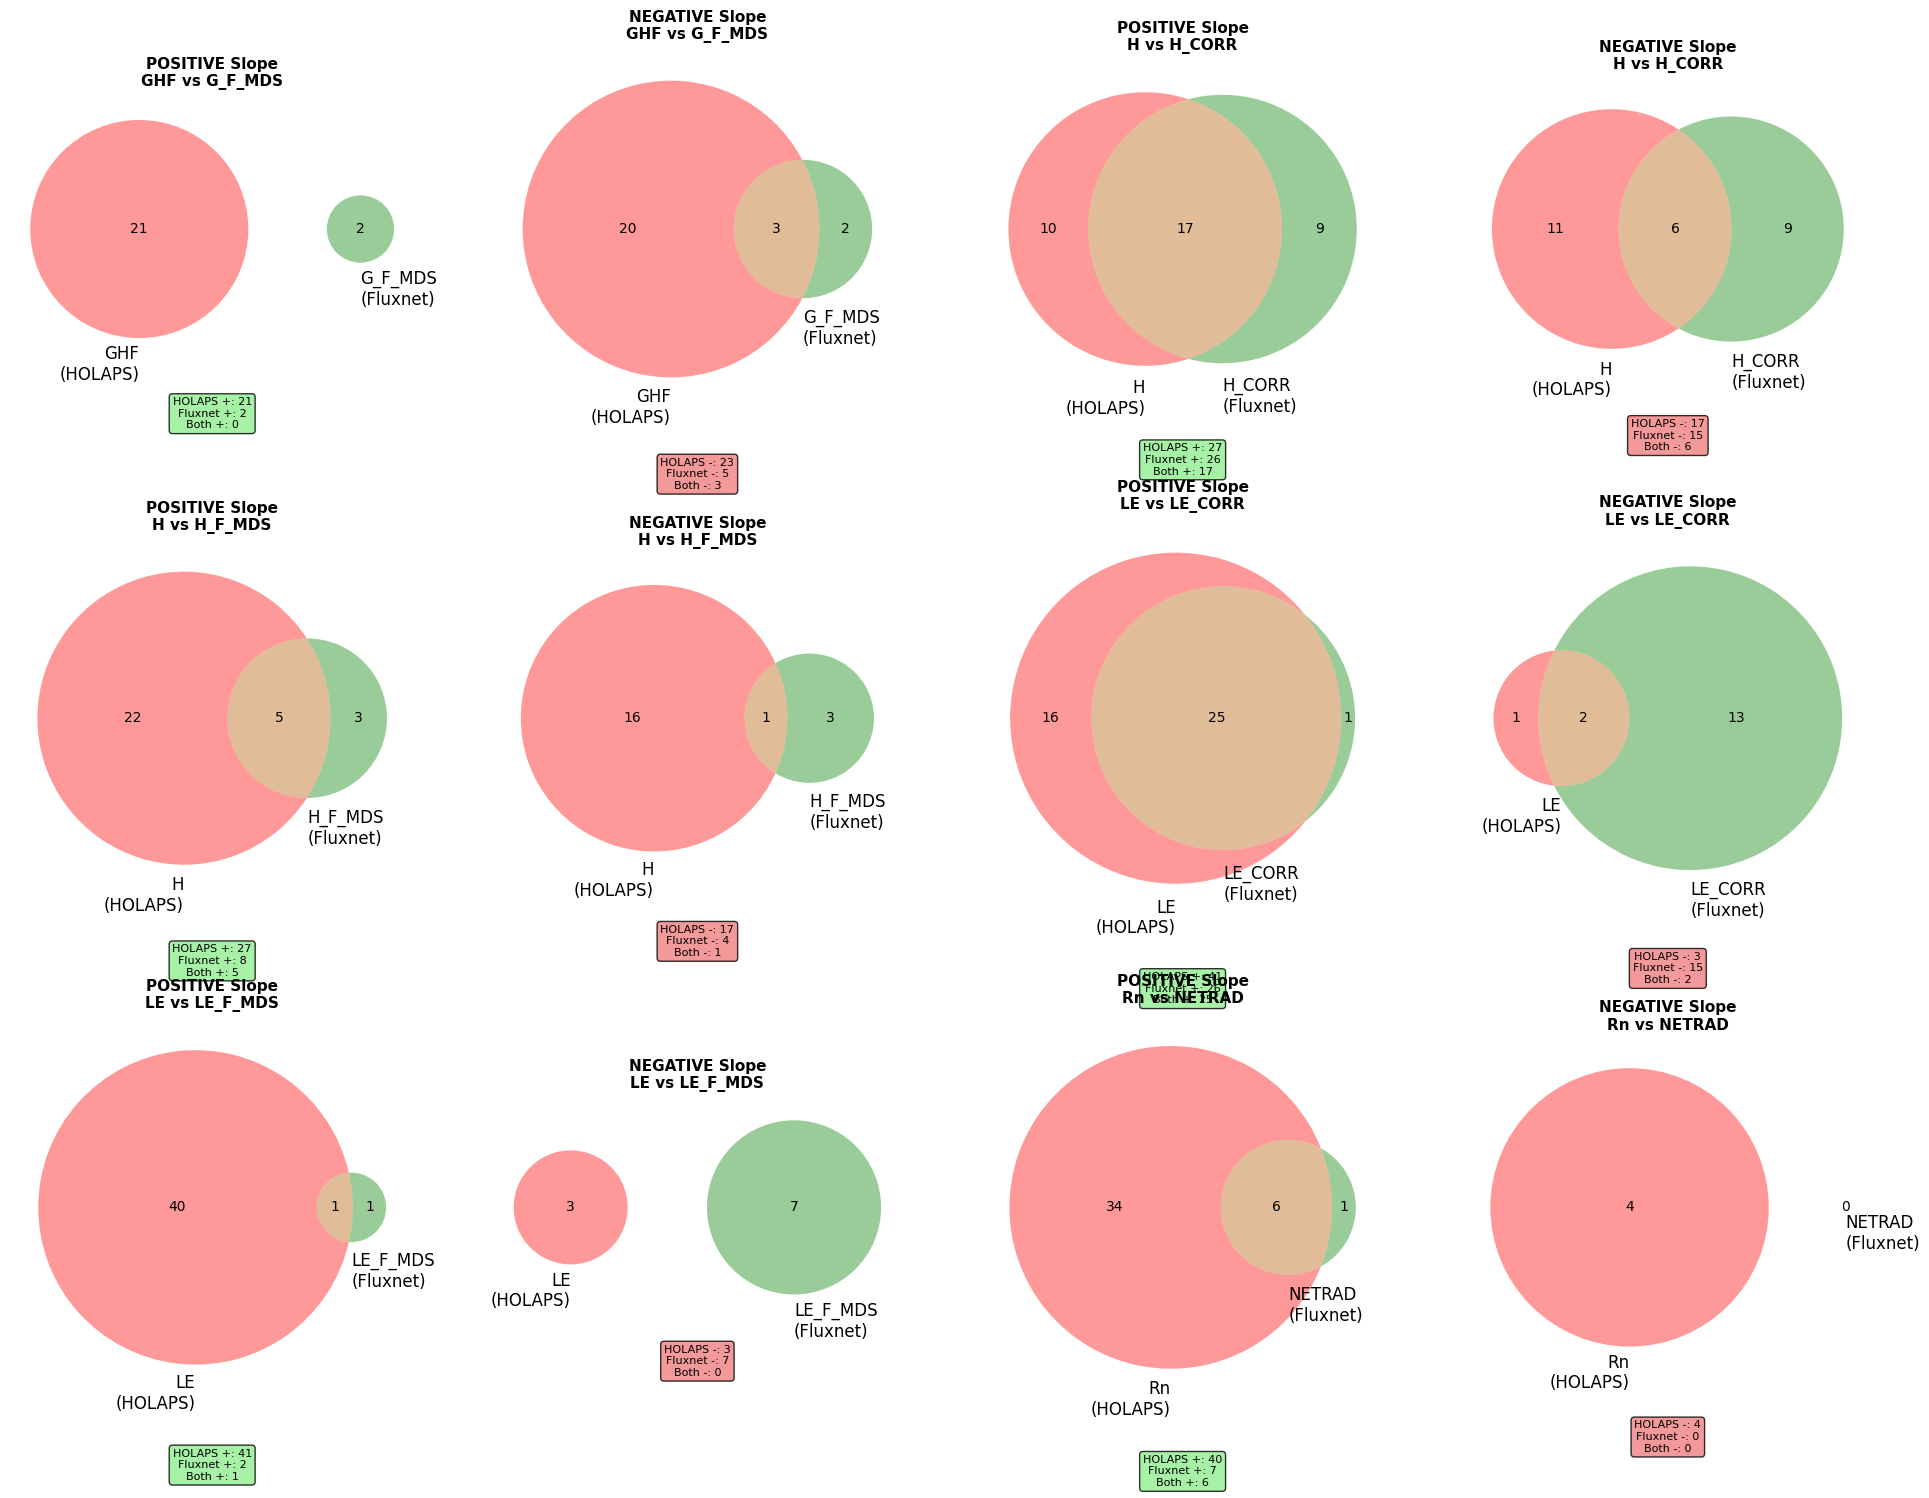

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib_venn import venn2

# Define parameter mapping between HOLAPS and Fluxnet
holaps_to_fluxnet = {
    'GHF': 'G_F_MDS',
    'H': ['H_CORR', 'H_F_MDS'],
    'LE': ['LE_CORR', 'LE_F_MDS'],
    'Rn': 'NETRAD',
    'Ta': 'TA_F',
    'Td': 'TS_F_MDS_1',
    'rain': 'P_F',
    'sm1': 'SWC_F_MDS_1'
}

# File paths
fluxnet_file = r'C:\Deepak\Comparison\comprehensive_selected_periods_analysis.xlsx'
holaps_file = r'C:\Deepak\Comparison\comprehensive_holaps_analysis.xlsx'
output_directory = r'C:\Deepak\Comparison\slope_sign_comparison'

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

def load_and_prepare_data():
    """Load and prepare data from both HOLAPS and Fluxnet"""
    
    # Load Fluxnet data
    print("Loading Fluxnet data...")
    fluxnet_df = pd.read_excel(fluxnet_file, sheet_name='All_Selected_Periods_Data')
    
    # Load HOLAPS data
    print("Loading HOLAPS data...")
    holaps_df = pd.read_excel(holaps_file, sheet_name='All_Data')
    
    # Clean station names
    fluxnet_df['station_clean'] = fluxnet_df['station'].str.replace('progressive_trend_tables_', '')
    holaps_df['station_clean'] = holaps_df['station'].str.replace('holaps_trend_tables_', '')
    
    # Get all 44 HOLAPS stations
    all_holaps_stations = set(holaps_df['station_clean'].unique())
    
    print(f"All HOLAPS stations: {len(all_holaps_stations)}")
    print(f"HOLAPS stations: {sorted(all_holaps_stations)}")
    
    return fluxnet_df, holaps_df, all_holaps_stations

def create_slope_sign_comparison(fluxnet_df, holaps_df, all_holaps_stations):
    """Create slope sign comparison for all parameter pairs"""
    
    comparison_results = []
    
    for season in ['yearly', 'JJA']:
        print(f"\nProcessing {season} season...")
        
        # Filter data by season
        fluxnet_season = fluxnet_df[fluxnet_df['season'] == season]
        holaps_season = holaps_df[holaps_df['season'] == season]
        
        for holaps_param, fluxnet_params in holaps_to_fluxnet.items():
            # Handle multiple mappings
            if isinstance(fluxnet_params, list):
                for fluxnet_param in fluxnet_params:
                    process_slope_sign_comparison(
                        holaps_season, fluxnet_season, 
                        holaps_param, fluxnet_param, 
                        season, comparison_results, all_holaps_stations
                    )
            else:
                process_slope_sign_comparison(
                    holaps_season, fluxnet_season, 
                    holaps_param, fluxnet_params, 
                    season, comparison_results, all_holaps_stations
                )
    
    return pd.DataFrame(comparison_results)

def process_slope_sign_comparison(holaps_data, fluxnet_data, holaps_param, fluxnet_param, season, results, all_holaps_stations):
    """Process slope sign comparison for one parameter pair"""
    
    # Get positive and negative slope stations for HOLAPS
    holaps_pos_stations = set()
    holaps_neg_stations = set()
    holaps_no_slope_stations = set()
    
    for station in all_holaps_stations:
        holaps_station_data = holaps_data[
            (holaps_data['station_clean'] == station) & 
            (holaps_data['parameter'] == holaps_param)
        ]
        
        if len(holaps_station_data) > 0:
            slope = holaps_station_data['slope'].iloc[0]
            if pd.notna(slope):
                if slope > 0:
                    holaps_pos_stations.add(station)
                else:
                    holaps_neg_stations.add(station)
            else:
                holaps_no_slope_stations.add(station)
        else:
            holaps_no_slope_stations.add(station)
    
    # Get positive and negative slope stations for Fluxnet
    fluxnet_pos_stations = set()
    fluxnet_neg_stations = set()
    fluxnet_no_slope_stations = set()
    
    fluxnet_param_data = fluxnet_data[fluxnet_data['parameter'] == fluxnet_param]
    
    for station in all_holaps_stations:
        fluxnet_station_data = fluxnet_param_data[fluxnet_param_data['station_clean'] == station]
        
        if len(fluxnet_station_data) > 0:
            slope = fluxnet_station_data['slope'].iloc[0]
            if pd.notna(slope):
                if slope > 0:
                    fluxnet_pos_stations.add(station)
                else:
                    fluxnet_neg_stations.add(station)
            else:
                fluxnet_no_slope_stations.add(station)
        else:
            fluxnet_no_slope_stations.add(station)
    
    # Calculate counts for Venn diagrams
    # Positive slope Venn: HOLAPS positive vs Fluxnet positive
    pos_holaps_only = len(holaps_pos_stations - fluxnet_pos_stations)
    pos_fluxnet_only = len(fluxnet_pos_stations - holaps_pos_stations)
    pos_both = len(holaps_pos_stations & fluxnet_pos_stations)
    
    # Negative slope Venn: HOLAPS negative vs Fluxnet negative
    neg_holaps_only = len(holaps_neg_stations - fluxnet_neg_stations)
    neg_fluxnet_only = len(fluxnet_neg_stations - holaps_neg_stations)
    neg_both = len(holaps_neg_stations & fluxnet_neg_stations)
    
    # Data availability
    holaps_with_slope = len(holaps_pos_stations) + len(holaps_neg_stations)
    fluxnet_with_slope = len(fluxnet_pos_stations) + len(fluxnet_neg_stations)
    
    results.append({
        'season': season,
        'holaps_parameter': holaps_param,
        'fluxnet_parameter': fluxnet_param,
        'total_holaps_stations': len(all_holaps_stations),
        
        # Positive slope Venn counts
        'pos_holaps_only': pos_holaps_only,
        'pos_fluxnet_only': pos_fluxnet_only,
        'pos_both': pos_both,
        
        # Negative slope Venn counts
        'neg_holaps_only': neg_holaps_only,
        'neg_fluxnet_only': neg_fluxnet_only,
        'neg_both': neg_both,
        
        # Data availability
        'holaps_with_slope': holaps_with_slope,
        'fluxnet_with_slope': fluxnet_with_slope,
        'holaps_no_slope': len(holaps_no_slope_stations),
        'fluxnet_no_slope': len(fluxnet_no_slope_stations),
        
        # Station lists
        'holaps_pos_stations': ', '.join(sorted(holaps_pos_stations)),
        'holaps_neg_stations': ', '.join(sorted(holaps_neg_stations)),
        'fluxnet_pos_stations': ', '.join(sorted(fluxnet_pos_stations)),
        'fluxnet_neg_stations': ', '.join(sorted(fluxnet_neg_stations))
    })

def create_combined_slope_venn_diagrams(comparison_df, all_holaps_stations):
    """Create combined Venn diagrams for all parameter pairs organized by season"""
    
    for season in ['yearly', 'JJA']:
        print(f"\nCreating combined slope sign Venn diagrams for {season} season...")
        
        season_data = comparison_df[comparison_df['season'] == season]
        
        # Create a figure with subplots for all parameters
        n_params = len(season_data)
        n_cols = 4  # 4 columns: 2 Venn diagrams per parameter (positive and negative)
        n_rows = (n_params + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 6 * n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        
        # Flatten axes for easy indexing
        flat_axes = axes.flatten()
        
        for idx, (_, row) in enumerate(season_data.iterrows()):
            ax_pos = flat_axes[2 * idx]
            ax_neg = flat_axes[2 * idx + 1]
            
            holaps_param = row['holaps_parameter']
            fluxnet_param = row['fluxnet_parameter']
            
            # Positive slope Venn diagram
            pos_holaps_only = row['pos_holaps_only']
            pos_fluxnet_only = row['pos_fluxnet_only']
            pos_both = row['pos_both']
            
            if pos_holaps_only + pos_fluxnet_only + pos_both > 0:
                venn2(subsets=(pos_holaps_only, pos_fluxnet_only, pos_both),
                      set_labels=(f'{holaps_param}\n(HOLAPS)', f'{fluxnet_param}\n(Fluxnet)'), 
                      ax=ax_pos)
            else:
                ax_pos.text(0.5, 0.5, 'No Positive\nSlope Stations', 
                           ha='center', va='center', fontsize=10, fontweight='bold')
            
            ax_pos.set_title(f'POSITIVE Slope\n{holaps_param} vs {fluxnet_param}', 
                           fontsize=11, fontweight='bold', pad=10)
            
            # Add statistics for positive plot
            pos_stats = (
                f'HOLAPS +: {pos_holaps_only + pos_both}\n'
                f'Fluxnet +: {pos_fluxnet_only + pos_both}\n'
                f'Both +: {pos_both}'
            )
            ax_pos.text(0.5, -0.15, pos_stats, transform=ax_pos.transAxes, fontsize=8,
                      ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
            
            # Negative slope Venn diagram
            neg_holaps_only = row['neg_holaps_only']
            neg_fluxnet_only = row['neg_fluxnet_only']
            neg_both = row['neg_both']
            
            if neg_holaps_only + neg_fluxnet_only + neg_both > 0:
                venn2(subsets=(neg_holaps_only, neg_fluxnet_only, neg_both),
                      set_labels=(f'{holaps_param}\n(HOLAPS)', f'{fluxnet_param}\n(Fluxnet)'), 
                      ax=ax_neg)
            else:
                ax_neg.text(0.5, 0.5, 'No Negative\nSlope Stations', 
                           ha='center', va='center', fontsize=10, fontweight='bold')
            
            ax_neg.set_title(f'NEGATIVE Slope\n{holaps_param} vs {fluxnet_param}', 
                           fontsize=11, fontweight='bold', pad=10)
            
            # Add statistics for negative plot
            neg_stats = (
                f'HOLAPS -: {neg_holaps_only + neg_both}\n'
                f'Fluxnet -: {neg_fluxnet_only + neg_both}\n'
                f'Both -: {neg_both}'
            )
            ax_neg.text(0.5, -0.15, neg_stats, transform=ax_neg.transAxes, fontsize=8,
                      ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
        
        # Hide unused subplots
        for idx in range(2 * n_params, len(flat_axes)):
            flat_axes[idx].set_visible(False)
        
        # Add overall title and statistics
        total_stats = (
            f'Total HOLAPS Stations: {len(all_holaps_stations)}\n'
            f'Season: {season}'
        )
        
        fig.text(0.02, 0.02, total_stats, fontsize=10,
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                 verticalalignment='bottom')
        
        plt.suptitle(f'Slope Sign Comparison: HOLAPS vs Fluxnet - {season} Season', 
                     fontsize=16, fontweight='bold', y=0.98)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save the combined figure
        filename = f'combined_slope_sign_venn_{season}.png'
        plt.savefig(os.path.join(output_directory, filename), dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"  Created combined Venn diagram: {filename}")

def create_individual_slope_venn_diagrams(comparison_df, all_holaps_stations):
    """Create individual slope sign Venn diagrams for detailed analysis"""
    
    for season in ['yearly', 'JJA']:
        print(f"\nCreating individual slope sign Venn diagrams for {season} season...")
        
        season_data = comparison_df[comparison_df['season'] == season]
        
        for _, row in season_data.iterrows():
            create_single_slope_venn_diagram(row, season, all_holaps_stations)

def create_single_slope_venn_diagram(comparison_row, season, all_holaps_stations):
    """Create a single detailed slope sign Venn diagram for one parameter pair"""
    
    holaps_param = comparison_row['holaps_parameter']
    fluxnet_param = comparison_row['fluxnet_parameter']
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot 1: POSITIVE slope stations Venn diagram
    pos_holaps_only = comparison_row['pos_holaps_only']
    pos_fluxnet_only = comparison_row['pos_fluxnet_only']
    pos_both = comparison_row['pos_both']
    
    if pos_holaps_only + pos_fluxnet_only + pos_both > 0:
        venn2(subsets=(pos_holaps_only, pos_fluxnet_only, pos_both),
              set_labels=(f'{holaps_param}\n(HOLAPS)', f'{fluxnet_param}\n(Fluxnet)'), 
              ax=ax1)
    else:
        ax1.text(0.5, 0.5, 'No Positive Slope Stations', ha='center', va='center', 
                transform=ax1.transAxes, fontsize=12, fontweight='bold')
    
    ax1.set_title('POSITIVE Slope Stations', fontsize=14, fontweight='bold')
    
    # Add statistics for positive plot
    pos_stats = (
        f'HOLAPS Positive: {pos_holaps_only + pos_both}\n'
        f'Fluxnet Positive: {pos_fluxnet_only + pos_both}\n'
        f'Both Positive: {pos_both}\n'
        f'HOLAPS Only: {pos_holaps_only}\n'
        f'Fluxnet Only: {pos_fluxnet_only}'
    )
    ax1.text(0.5, -0.2, pos_stats, transform=ax1.transAxes, fontsize=10,
            ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    # Plot 2: NEGATIVE slope stations Venn diagram
    neg_holaps_only = comparison_row['neg_holaps_only']
    neg_fluxnet_only = comparison_row['neg_fluxnet_only']
    neg_both = comparison_row['neg_both']
    
    if neg_holaps_only + neg_fluxnet_only + neg_both > 0:
        venn2(subsets=(neg_holaps_only, neg_fluxnet_only, neg_both),
              set_labels=(f'{holaps_param}\n(HOLAPS)', f'{fluxnet_param}\n(Fluxnet)'), 
              ax=ax2)
    else:
        ax2.text(0.5, 0.5, 'No Negative Slope Stations', ha='center', va='center', 
                transform=ax2.transAxes, fontsize=12, fontweight='bold')
    
    ax2.set_title('NEGATIVE Slope Stations', fontsize=14, fontweight='bold')
    
    # Add statistics for negative plot
    neg_stats = (
        f'HOLAPS Negative: {neg_holaps_only + neg_both}\n'
        f'Fluxnet Negative: {neg_fluxnet_only + neg_both}\n'
        f'Both Negative: {neg_both}\n'
        f'HOLAPS Only: {neg_holaps_only}\n'
        f'Fluxnet Only: {neg_fluxnet_only}'
    )
    ax2.text(0.5, -0.2, neg_stats, transform=ax2.transAxes, fontsize=10,
            ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    
    # Add overall statistics
    total_stats = (
        f'Total HOLAPS Stations: {len(all_holaps_stations)}\n'
        f'HOLAPS with Slope: {comparison_row["holaps_with_slope"]}\n'
        f'Fluxnet with Slope: {comparison_row["fluxnet_with_slope"]}\n'
        f'HOLAPS No Slope: {comparison_row["holaps_no_slope"]}\n'
        f'Fluxnet No Slope: {comparison_row["fluxnet_no_slope"]}'
    )
    
    fig.text(0.02, 0.02, total_stats, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
             verticalalignment='bottom')
    
    plt.suptitle(f'Slope Sign: {holaps_param} (HOLAPS) vs {fluxnet_param} (Fluxnet)\n{season} Season', 
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    
    # Save the figure
    filename = f'slope_sign_{holaps_param}_vs_{fluxnet_param}_{season}.png'
    plt.savefig(os.path.join(output_directory, filename), dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"  Created individual slope sign Venn diagram: {filename}")

def create_summary_report(comparison_df, all_holaps_stations):
    """Create summary report for slope sign comparison"""
    
    with pd.ExcelWriter(os.path.join(output_directory, 'slope_sign_comparison_summary.xlsx')) as writer:
        
        # Main comparison summary
        summary_data = []
        for season in ['yearly', 'JJA']:
            season_data = comparison_df[comparison_df['season'] == season]
            
            for _, row in season_data.iterrows():
                summary_data.append({
                    'Season': season,
                    'HOLAPS_Parameter': row['holaps_parameter'],
                    'Fluxnet_Parameter': row['fluxnet_parameter'],
                    'Total_HOLAPS_Stations': row['total_holaps_stations'],
                    
                    # Positive slope counts
                    'HOLAPS_Positive_Total': row['pos_holaps_only'] + row['pos_both'],
                    'Fluxnet_Positive_Total': row['pos_fluxnet_only'] + row['pos_both'],
                    'Both_Positive': row['pos_both'],
                    'HOLAPS_Only_Positive': row['pos_holaps_only'],
                    'Fluxnet_Only_Positive': row['pos_fluxnet_only'],
                    
                    # Negative slope counts
                    'HOLAPS_Negative_Total': row['neg_holaps_only'] + row['neg_both'],
                    'Fluxnet_Negative_Total': row['neg_fluxnet_only'] + row['neg_both'],
                    'Both_Negative': row['neg_both'],
                    'HOLAPS_Only_Negative': row['neg_holaps_only'],
                    'Fluxnet_Only_Negative': row['neg_fluxnet_only'],
                    
                    # Data availability
                    'HOLAPS_With_Slope': row['holaps_with_slope'],
                    'Fluxnet_With_Slope': row['fluxnet_with_slope'],
                    'HOLAPS_No_Slope': row['holaps_no_slope'],
                    'Fluxnet_No_Slope': row['fluxnet_no_slope']
                })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, sheet_name='Slope_Sign_Comparison', index=False)
        
        # Station lists
        station_lists_data = []
        for season in ['yearly', 'JJA']:
            season_data = comparison_df[comparison_df['season'] == season]
            
            for _, row in season_data.iterrows():
                station_lists_data.append({
                    'Season': season,
                    'HOLAPS_Parameter': row['holaps_parameter'],
                    'Fluxnet_Parameter': row['fluxnet_parameter'],
                    'HOLAPS_Positive_Stations': row['holaps_pos_stations'],
                    'HOLAPS_Negative_Stations': row['holaps_neg_stations'],
                    'Fluxnet_Positive_Stations': row['fluxnet_pos_stations'],
                    'Fluxnet_Negative_Stations': row['fluxnet_neg_stations']
                })
        
        station_lists_df = pd.DataFrame(station_lists_data)
        station_lists_df.to_excel(writer, sheet_name='Station_Lists', index=False)
        
        # All HOLAPS stations
        stations_df = pd.DataFrame({'All_HOLAPS_Stations': sorted(all_holaps_stations)})
        stations_df.to_excel(writer, sheet_name='All_HOLAPS_Stations', index=False)

def main():
    """Main function to run the slope sign Venn diagram comparison"""
    
    print("Starting Slope Sign Venn Diagram Comparison Analysis...")
    
    # Load data
    fluxnet_df, holaps_df, all_holaps_stations = load_and_prepare_data()
    
    # Create slope sign comparison
    comparison_df = create_slope_sign_comparison(fluxnet_df, holaps_df, all_holaps_stations)
    
    # Create combined Venn diagrams (all parameters in one plot)
    create_combined_slope_venn_diagrams(comparison_df, all_holaps_stations)
    
    # Create individual Venn diagrams for detailed analysis
    create_individual_slope_venn_diagrams(comparison_df, all_holaps_stations)
    
    # Create summary report
    create_summary_report(comparison_df, all_holaps_stations)
    
    print(f"\nSlope sign Venn diagram comparison completed!")
    print(f"Results saved to: {output_directory}")
    print(f"Main summary file: slope_sign_comparison_summary.xlsx")
    print(f"Total parameter pairs analyzed: {len(comparison_df)}")
    print(f"All 44 HOLAPS stations considered in analysis")

if __name__ == "__main__":
    main()

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib_venn import venn2

# Define parameter mapping between HOLAPS and Fluxnet
holaps_to_fluxnet = {
    'GHF': 'G_F_MDS',
    'H': ['H_CORR', 'H_F_MDS'],
    'LE': ['LE_CORR', 'LE_F_MDS'],
    'Rn': 'NETRAD',
    'Ta': 'TA_F',
    'Td': 'TS_F_MDS_1',
    'rain': 'P_F',
    'sm1': 'SWC_F_MDS_1'
}

# File paths
fluxnet_file = r'C:\Deepak\Comparison\comprehensive_selected_periods_analysis.xlsx'
holaps_file = r'C:\Deepak\Comparison\comprehensive_holaps_analysis.xlsx'
output_directory = r'C:\Deepak\Comparison\slope_sign_comparison'

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

def load_and_prepare_data():
    """Load and prepare data from both HOLAPS and Fluxnet"""
    
    # Load Fluxnet data
    print("Loading Fluxnet data...")
    fluxnet_df = pd.read_excel(fluxnet_file, sheet_name='All_Selected_Periods_Data')
    
    # Load HOLAPS data
    print("Loading HOLAPS data...")
    holaps_df = pd.read_excel(holaps_file, sheet_name='All_Data')
    
    # Clean station names
    fluxnet_df['station_clean'] = fluxnet_df['station'].str.replace('progressive_trend_tables_', '')
    holaps_df['station_clean'] = holaps_df['station'].str.replace('holaps_trend_tables_', '')
    
    # Get all 44 HOLAPS stations
    all_holaps_stations = set(holaps_df['station_clean'].unique())
    
    print(f"All HOLAPS stations: {len(all_holaps_stations)}")
    print(f"HOLAPS stations: {sorted(all_holaps_stations)}")
    
    return fluxnet_df, holaps_df, all_holaps_stations

def create_slope_sign_comparison(fluxnet_df, holaps_df, all_holaps_stations):
    """Create slope sign comparison for all parameter pairs"""
    
    comparison_results = []
    
    for season in ['yearly', 'JJA']:
        print(f"\nProcessing {season} season...")
        
        # Filter data by season
        fluxnet_season = fluxnet_df[fluxnet_df['season'] == season]
        holaps_season = holaps_df[holaps_df['season'] == season]
        
        for holaps_param, fluxnet_params in holaps_to_fluxnet.items():
            # Handle multiple mappings
            if isinstance(fluxnet_params, list):
                for fluxnet_param in fluxnet_params:
                    process_slope_sign_comparison(
                        holaps_season, fluxnet_season, 
                        holaps_param, fluxnet_param, 
                        season, comparison_results, all_holaps_stations
                    )
            else:
                process_slope_sign_comparison(
                    holaps_season, fluxnet_season, 
                    holaps_param, fluxnet_params, 
                    season, comparison_results, all_holaps_stations
                )
    
    return pd.DataFrame(comparison_results)

def process_slope_sign_comparison(holaps_data, fluxnet_data, holaps_param, fluxnet_param, season, results, all_holaps_stations):
    """Process slope sign comparison for one parameter pair"""
    
    # Get positive and negative slope stations for HOLAPS
    holaps_pos_stations = set()
    holaps_neg_stations = set()
    holaps_no_slope_stations = set()
    
    for station in all_holaps_stations:
        holaps_station_data = holaps_data[
            (holaps_data['station_clean'] == station) & 
            (holaps_data['parameter'] == holaps_param)
        ]
        
        if len(holaps_station_data) > 0:
            slope = holaps_station_data['slope'].iloc[0]
            if pd.notna(slope):
                if slope > 0:
                    holaps_pos_stations.add(station)
                else:
                    holaps_neg_stations.add(station)
            else:
                holaps_no_slope_stations.add(station)
        else:
            holaps_no_slope_stations.add(station)
    
    # Get positive and negative slope stations for Fluxnet
    fluxnet_pos_stations = set()
    fluxnet_neg_stations = set()
    fluxnet_no_slope_stations = set()
    
    fluxnet_param_data = fluxnet_data[fluxnet_data['parameter'] == fluxnet_param]
    
    for station in all_holaps_stations:
        fluxnet_station_data = fluxnet_param_data[fluxnet_param_data['station_clean'] == station]
        
        if len(fluxnet_station_data) > 0:
            slope = fluxnet_station_data['slope'].iloc[0]
            if pd.notna(slope):
                if slope > 0:
                    fluxnet_pos_stations.add(station)
                else:
                    fluxnet_neg_stations.add(station)
            else:
                fluxnet_no_slope_stations.add(station)
        else:
            fluxnet_no_slope_stations.add(station)
    
    # Calculate counts for Venn diagrams
    # Positive slope Venn: HOLAPS positive vs Fluxnet positive
    pos_holaps_only = len(holaps_pos_stations - fluxnet_pos_stations)
    pos_fluxnet_only = len(fluxnet_pos_stations - holaps_pos_stations)
    pos_both = len(holaps_pos_stations & fluxnet_pos_stations)
    
    # Negative slope Venn: HOLAPS negative vs Fluxnet negative
    neg_holaps_only = len(holaps_neg_stations - fluxnet_neg_stations)
    neg_fluxnet_only = len(fluxnet_neg_stations - holaps_neg_stations)
    neg_both = len(holaps_neg_stations & fluxnet_neg_stations)
    
    # Data availability
    holaps_with_slope = len(holaps_pos_stations) + len(holaps_neg_stations)
    fluxnet_with_slope = len(fluxnet_pos_stations) + len(fluxnet_neg_stations)
    
    results.append({
        'season': season,
        'holaps_parameter': holaps_param,
        'fluxnet_parameter': fluxnet_param,
        'total_holaps_stations': len(all_holaps_stations),
        
        # Positive slope Venn counts
        'pos_holaps_only': pos_holaps_only,
        'pos_fluxnet_only': pos_fluxnet_only,
        'pos_both': pos_both,
        
        # Negative slope Venn counts
        'neg_holaps_only': neg_holaps_only,
        'neg_fluxnet_only': neg_fluxnet_only,
        'neg_both': neg_both,
        
        # Data availability
        'holaps_with_slope': holaps_with_slope,
        'fluxnet_with_slope': fluxnet_with_slope,
        'holaps_no_slope': len(holaps_no_slope_stations),
        'fluxnet_no_slope': len(fluxnet_no_slope_stations),
        
        # Station lists
        'holaps_pos_stations': ', '.join(sorted(holaps_pos_stations)),
        'holaps_neg_stations': ', '.join(sorted(holaps_neg_stations)),
        'fluxnet_pos_stations': ', '.join(sorted(fluxnet_pos_stations)),
        'fluxnet_neg_stations': ', '.join(sorted(fluxnet_neg_stations))
    })

def create_combined_slope_venn_diagrams(comparison_df, all_holaps_stations):
    """Create combined Venn diagrams for all parameter pairs organized by season"""
    
    for season in ['yearly', 'JJA']:
        print(f"\nCreating combined slope sign Venn diagrams for {season} season...")
        
        season_data = comparison_df[comparison_df['season'] == season]
        
        # Calculate number of parameter pairs
        n_params = len(season_data)
        
        # Create multiple figures if needed to avoid overcrowding
        max_params_per_figure = 6  # Maximum 6 parameter pairs per figure (12 subplots)
        
        for fig_num in range(0, n_params, max_params_per_figure):
            end_idx = min(fig_num + max_params_per_figure, n_params)
            current_params = season_data.iloc[fig_num:end_idx]
            
            n_current_params = len(current_params)
            n_cols = 4  # 2 columns for positive, 2 for negative per parameter pair
            n_rows = (n_current_params * 2 + n_cols - 1) // n_cols  # Each parameter needs 2 rows
            
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
            
            # Handle single row case
            if n_rows == 1:
                axes = axes.reshape(1, -1)
            
            # Flatten axes for easy indexing
            flat_axes = axes.flatten()
            
            ax_idx = 0
            for _, row in current_params.iterrows():
                holaps_param = row['holaps_parameter']
                fluxnet_param = row['fluxnet_parameter']
                
                # Positive slope Venn diagram
                if ax_idx < len(flat_axes):
                    ax_pos = flat_axes[ax_idx]
                    ax_idx += 1
                    
                    pos_holaps_only = row['pos_holaps_only']
                    pos_fluxnet_only = row['pos_fluxnet_only']
                    pos_both = row['pos_both']
                    
                    if pos_holaps_only + pos_fluxnet_only + pos_both > 0:
                        venn2(subsets=(pos_holaps_only, pos_fluxnet_only, pos_both),
                              set_labels=(f'{holaps_param}\n(HOLAPS)', f'{fluxnet_param}\n(Fluxnet)'), 
                              ax=ax_pos)
                    else:
                        ax_pos.text(0.5, 0.5, 'No Positive\nSlope Stations', 
                                   ha='center', va='center', fontsize=10, fontweight='bold')
                    
                    ax_pos.set_title(f'POSITIVE: {holaps_param} vs {fluxnet_param}', 
                                   fontsize=11, fontweight='bold', pad=10)
                    
                    # Add statistics for positive plot
                    pos_stats = (
                        f'HOLAPS +: {pos_holaps_only + pos_both}\n'
                        f'Fluxnet +: {pos_fluxnet_only + pos_both}\n'
                        f'Both +: {pos_both}'
                    )
                    ax_pos.text(0.5, -0.2, pos_stats, transform=ax_pos.transAxes, fontsize=9,
                              ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
                
                # Negative slope Venn diagram
                if ax_idx < len(flat_axes):
                    ax_neg = flat_axes[ax_idx]
                    ax_idx += 1
                    
                    neg_holaps_only = row['neg_holaps_only']
                    neg_fluxnet_only = row['neg_fluxnet_only']
                    neg_both = row['neg_both']
                    
                    if neg_holaps_only + neg_fluxnet_only + neg_both > 0:
                        venn2(subsets=(neg_holaps_only, neg_fluxnet_only, neg_both),
                              set_labels=(f'{holaps_param}\n(HOLAPS)', f'{fluxnet_param}\n(Fluxnet)'), 
                              ax=ax_neg)
                    else:
                        ax_neg.text(0.5, 0.5, 'No Negative\nSlope Stations', 
                                   ha='center', va='center', fontsize=10, fontweight='bold')
                    
                    ax_neg.set_title(f'NEGATIVE: {holaps_param} vs {fluxnet_param}', 
                                   fontsize=11, fontweight='bold', pad=10)
                    
                    # Add statistics for negative plot
                    neg_stats = (
                        f'HOLAPS -: {neg_holaps_only + neg_both}\n'
                        f'Fluxnet -: {neg_fluxnet_only + neg_both}\n'
                        f'Both -: {neg_both}'
                    )
                    ax_neg.text(0.5, -0.2, neg_stats, transform=ax_neg.transAxes, fontsize=9,
                              ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
            
            # Hide unused subplots
            for idx in range(ax_idx, len(flat_axes)):
                flat_axes[idx].set_visible(False)
            
            # Add overall title and statistics
            total_stats = (
                f'Total HOLAPS Stations: {len(all_holaps_stations)}\n'
                f'Season: {season}\n'
                f'Parameters: {fig_num + 1}-{end_idx} of {n_params}'
            )
            
            fig.text(0.02, 0.02, total_stats, fontsize=10,
                     bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                     verticalalignment='bottom')
            
            plt.suptitle(f'Slope Sign Comparison: HOLAPS vs Fluxnet - {season} Season (Part {fig_num//max_params_per_figure + 1})', 
                         fontsize=16, fontweight='bold', y=0.98)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            
            # Save the combined figure
            part_suffix = f"_part{fig_num//max_params_per_figure + 1}" if n_params > max_params_per_figure else ""
            filename = f'combined_slope_sign_venn_{season}{part_suffix}.png'
            plt.savefig(os.path.join(output_directory, filename), dpi=300, bbox_inches='tight')
            plt.close()
            
            print(f"  Created combined Venn diagram: {filename}")

def create_individual_slope_venn_diagrams(comparison_df, all_holaps_stations):
    """Create individual slope sign Venn diagrams for detailed analysis"""
    
    for season in ['yearly', 'JJA']:
        print(f"\nCreating individual slope sign Venn diagrams for {season} season...")
        
        season_data = comparison_df[comparison_df['season'] == season]
        
        for _, row in season_data.iterrows():
            create_single_slope_venn_diagram(row, season, all_holaps_stations)

def create_single_slope_venn_diagram(comparison_row, season, all_holaps_stations):
    """Create a single detailed slope sign Venn diagram for one parameter pair"""
    
    holaps_param = comparison_row['holaps_parameter']
    fluxnet_param = comparison_row['fluxnet_parameter']
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot 1: POSITIVE slope stations Venn diagram
    pos_holaps_only = comparison_row['pos_holaps_only']
    pos_fluxnet_only = comparison_row['pos_fluxnet_only']
    pos_both = comparison_row['pos_both']
    
    if pos_holaps_only + pos_fluxnet_only + pos_both > 0:
        venn2(subsets=(pos_holaps_only, pos_fluxnet_only, pos_both),
              set_labels=(f'{holaps_param}\n(HOLAPS)', f'{fluxnet_param}\n(Fluxnet)'), 
              ax=ax1)
    else:
        ax1.text(0.5, 0.5, 'No Positive Slope Stations', ha='center', va='center', 
                transform=ax1.transAxes, fontsize=12, fontweight='bold')
    
    ax1.set_title('POSITIVE Slope Stations', fontsize=14, fontweight='bold')
    
    # Add statistics for positive plot
    pos_stats = (
        f'HOLAPS Positive: {pos_holaps_only + pos_both}\n'
        f'Fluxnet Positive: {pos_fluxnet_only + pos_both}\n'
        f'Both Positive: {pos_both}\n'
        f'HOLAPS Only: {pos_holaps_only}\n'
        f'Fluxnet Only: {pos_fluxnet_only}'
    )
    ax1.text(0.5, -0.2, pos_stats, transform=ax1.transAxes, fontsize=10,
            ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    # Plot 2: NEGATIVE slope stations Venn diagram
    neg_holaps_only = comparison_row['neg_holaps_only']
    neg_fluxnet_only = comparison_row['neg_fluxnet_only']
    neg_both = comparison_row['neg_both']
    
    if neg_holaps_only + neg_fluxnet_only + neg_both > 0:
        venn2(subsets=(neg_holaps_only, neg_fluxnet_only, neg_both),
              set_labels=(f'{holaps_param}\n(HOLAPS)', f'{fluxnet_param}\n(Fluxnet)'), 
              ax=ax2)
    else:
        ax2.text(0.5, 0.5, 'No Negative Slope Stations', ha='center', va='center', 
                transform=ax2.transAxes, fontsize=12, fontweight='bold')
    
    ax2.set_title('NEGATIVE Slope Stations', fontsize=14, fontweight='bold')
    
    # Add statistics for negative plot
    neg_stats = (
        f'HOLAPS Negative: {neg_holaps_only + neg_both}\n'
        f'Fluxnet Negative: {neg_fluxnet_only + neg_both}\n'
        f'Both Negative: {neg_both}\n'
        f'HOLAPS Only: {neg_holaps_only}\n'
        f'Fluxnet Only: {neg_fluxnet_only}'
    )
    ax2.text(0.5, -0.2, neg_stats, transform=ax2.transAxes, fontsize=10,
            ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    
    # Add overall statistics
    total_stats = (
        f'Total HOLAPS Stations: {len(all_holaps_stations)}\n'
        f'HOLAPS with Slope: {comparison_row["holaps_with_slope"]}\n'
        f'Fluxnet with Slope: {comparison_row["fluxnet_with_slope"]}\n'
        f'HOLAPS No Slope: {comparison_row["holaps_no_slope"]}\n'
        f'Fluxnet No Slope: {comparison_row["fluxnet_no_slope"]}'
    )
    
    fig.text(0.02, 0.02, total_stats, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
             verticalalignment='bottom')
    
    plt.suptitle(f'Slope Sign: {holaps_param} (HOLAPS) vs {fluxnet_param} (Fluxnet)\n{season} Season', 
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    
    # Save the figure
    filename = f'slope_sign_{holaps_param}_vs_{fluxnet_param}_{season}.png'
    plt.savefig(os.path.join(output_directory, filename), dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"  Created individual slope sign Venn diagram: {filename}")

def create_summary_report(comparison_df, all_holaps_stations):
    """Create summary report for slope sign comparison"""
    
    with pd.ExcelWriter(os.path.join(output_directory, 'slope_sign_comparison_summary.xlsx')) as writer:
        
        # Main comparison summary
        summary_data = []
        for season in ['yearly', 'JJA']:
            season_data = comparison_df[comparison_df['season'] == season]
            
            for _, row in season_data.iterrows():
                summary_data.append({
                    'Season': season,
                    'HOLAPS_Parameter': row['holaps_parameter'],
                    'Fluxnet_Parameter': row['fluxnet_parameter'],
                    'Total_HOLAPS_Stations': row['total_holaps_stations'],
                    
                    # Positive slope counts
                    'HOLAPS_Positive_Total': row['pos_holaps_only'] + row['pos_both'],
                    'Fluxnet_Positive_Total': row['pos_fluxnet_only'] + row['pos_both'],
                    'Both_Positive': row['pos_both'],
                    'HOLAPS_Only_Positive': row['pos_holaps_only'],
                    'Fluxnet_Only_Positive': row['pos_fluxnet_only'],
                    
                    # Negative slope counts
                    'HOLAPS_Negative_Total': row['neg_holaps_only'] + row['neg_both'],
                    'Fluxnet_Negative_Total': row['neg_fluxnet_only'] + row['neg_both'],
                    'Both_Negative': row['neg_both'],
                    'HOLAPS_Only_Negative': row['neg_holaps_only'],
                    'Fluxnet_Only_Negative': row['neg_fluxnet_only'],
                    
                    # Data availability
                    'HOLAPS_With_Slope': row['holaps_with_slope'],
                    'Fluxnet_With_Slope': row['fluxnet_with_slope'],
                    'HOLAPS_No_Slope': row['holaps_no_slope'],
                    'Fluxnet_No_Slope': row['fluxnet_no_slope']
                })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, sheet_name='Slope_Sign_Comparison', index=False)
        
        # Station lists
        station_lists_data = []
        for season in ['yearly', 'JJA']:
            season_data = comparison_df[comparison_df['season'] == season]
            
            for _, row in season_data.iterrows():
                station_lists_data.append({
                    'Season': season,
                    'HOLAPS_Parameter': row['holaps_parameter'],
                    'Fluxnet_Parameter': row['fluxnet_parameter'],
                    'HOLAPS_Positive_Stations': row['holaps_pos_stations'],
                    'HOLAPS_Negative_Stations': row['holaps_neg_stations'],
                    'Fluxnet_Positive_Stations': row['fluxnet_pos_stations'],
                    'Fluxnet_Negative_Stations': row['fluxnet_neg_stations']
                })
        
        station_lists_df = pd.DataFrame(station_lists_data)
        station_lists_df.to_excel(writer, sheet_name='Station_Lists', index=False)
        
        # All HOLAPS stations
        stations_df = pd.DataFrame({'All_HOLAPS_Stations': sorted(all_holaps_stations)})
        stations_df.to_excel(writer, sheet_name='All_HOLAPS_Stations', index=False)

def main():
    """Main function to run the slope sign Venn diagram comparison"""
    
    print("Starting Slope Sign Venn Diagram Comparison Analysis...")
    
    # Load data
    fluxnet_df, holaps_df, all_holaps_stations = load_and_prepare_data()
    
    # Create slope sign comparison
    comparison_df = create_slope_sign_comparison(fluxnet_df, holaps_df, all_holaps_stations)
    
    # Create combined Venn diagrams (all parameters in one plot)
    create_combined_slope_venn_diagrams(comparison_df, all_holaps_stations)
    
    # Create individual Venn diagrams for detailed analysis
    create_individual_slope_venn_diagrams(comparison_df, all_holaps_stations)
    
    # Create summary report
    create_summary_report(comparison_df, all_holaps_stations)
    
    print(f"\nSlope sign Venn diagram comparison completed!")
    print(f"Results saved to: {output_directory}")
    print(f"Main summary file: slope_sign_comparison_summary.xlsx")
    print(f"Total parameter pairs analyzed: {len(comparison_df)}")
    print(f"All 44 HOLAPS stations considered in analysis")

if __name__ == "__main__":
    main()

Starting Slope Sign Venn Diagram Comparison Analysis...
Loading Fluxnet data...
Loading HOLAPS data...
All HOLAPS stations: 44
HOLAPS stations: ['AT-Neu', 'BE-Bra', 'BE-Lon', 'BE-Vie', 'CH-Cha', 'CH-Dav', 'CH-Fru', 'CZ-BK1', 'CZ-wet', 'DE-Geb', 'DE-Gri', 'DE-Hai', 'DE-HoH', 'DE-Hzd', 'DE-Kli', 'DE-Lnf', 'DE-Obe', 'DE-RuR', 'DE-RuS', 'DE-Tha', 'DK-Sor', 'ES-Agu', 'ES-LJu', 'FR-Aur', 'FR-Bil', 'FR-Gri', 'FR-Hes', 'FR-LBr', 'FR-Lam', 'IT-BCi', 'IT-Col', 'IT-Cp2', 'IT-Cpz', 'IT-Lav', 'IT-MBo', 'IT-Ren', 'IT-Ro2', 'IT-SR2', 'IT-SRo', 'IT-Tor', 'IT-TrF', 'NL-Loo', 'RU-Fyo', 'SE-Htm']

Processing yearly season...

Processing JJA season...

Creating combined slope sign Venn diagrams for yearly season...
  Created combined Venn diagram: combined_slope_sign_venn_yearly_part1.png
  Created combined Venn diagram: combined_slope_sign_venn_yearly_part2.png

Creating combined slope sign Venn diagrams for JJA season...
  Created combined Venn diagram: combined_slope_sign_venn_JJA_part1.png
  Created c

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib_venn import venn2

# Define parameter mapping between HOLAPS and Fluxnet
holaps_to_fluxnet = {
    'GHF': 'G_F_MDS',
    'H': ['H_CORR', 'H_F_MDS'],
    'LE': ['LE_CORR', 'LE_F_MDS'],
    'Rn': 'NETRAD',
    'Ta': 'TA_F',
    'Td': 'TS_F_MDS_1',
    'rain': 'P_F',
    'sm1': 'SWC_F_MDS_1'
}

# File paths
fluxnet_file = r'C:\Deepak\Comparison\comprehensive_selected_periods_analysis.xlsx'
holaps_file = r'C:\Deepak\Comparison\comprehensive_holaps_analysis.xlsx'
output_directory = r'C:\Deepak\Comparison\common_stations_slope_comparison'

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

def load_and_prepare_data():
    """Load and prepare data from both HOLAPS and Fluxnet"""
    
    # Load Fluxnet data
    print("Loading Fluxnet data...")
    fluxnet_df = pd.read_excel(fluxnet_file, sheet_name='All_Selected_Periods_Data')
    
    # Load HOLAPS data
    print("Loading HOLAPS data...")
    holaps_df = pd.read_excel(holaps_file, sheet_name='All_Data')
    
    # Clean station names
    fluxnet_df['station_clean'] = fluxnet_df['station'].str.replace('progressive_trend_tables_', '')
    holaps_df['station_clean'] = holaps_df['station'].str.replace('holaps_trend_tables_', '')
    
    # Get all 44 HOLAPS stations
    all_holaps_stations = set(holaps_df['station_clean'].unique())
    
    print(f"All HOLAPS stations: {len(all_holaps_stations)}")
    print(f"HOLAPS stations: {sorted(all_holaps_stations)}")
    
    return fluxnet_df, holaps_df, all_holaps_stations

def create_common_stations_slope_comparison(fluxnet_df, holaps_df, all_holaps_stations):
    """Create slope sign comparison for common stations only"""
    
    comparison_results = []
    
    for season in ['yearly', 'JJA']:
        print(f"\nProcessing {season} season...")
        
        # Filter data by season
        fluxnet_season = fluxnet_df[fluxnet_df['season'] == season]
        holaps_season = holaps_df[holaps_df['season'] == season]
        
        for holaps_param, fluxnet_params in holaps_to_fluxnet.items():
            # Handle multiple mappings
            if isinstance(fluxnet_params, list):
                for fluxnet_param in fluxnet_params:
                    process_common_stations_slope_comparison(
                        holaps_season, fluxnet_season, 
                        holaps_param, fluxnet_param, 
                        season, comparison_results, all_holaps_stations
                    )
            else:
                process_common_stations_slope_comparison(
                    holaps_season, fluxnet_season, 
                    holaps_param, fluxnet_params, 
                    season, comparison_results, all_holaps_stations
                )
    
    return pd.DataFrame(comparison_results)

def process_common_stations_slope_comparison(holaps_data, fluxnet_data, holaps_param, fluxnet_param, season, results, all_holaps_stations):
    """Process slope sign comparison for common stations only"""
    
    # Find common stations with valid slopes for both datasets
    common_stations = set()
    holaps_pos_stations = set()
    holaps_neg_stations = set()
    fluxnet_pos_stations = set()
    fluxnet_neg_stations = set()
    
    # Agreement categories
    both_positive_stations = set()
    both_negative_stations = set()
    holaps_pos_fluxnet_neg_stations = set()
    holaps_neg_fluxnet_pos_stations = set()
    
    for station in all_holaps_stations:
        # Get HOLAPS data
        holaps_station_data = holaps_data[
            (holaps_data['station_clean'] == station) & 
            (holaps_data['parameter'] == holaps_param)
        ]
        
        # Get Fluxnet data
        fluxnet_station_data = fluxnet_data[
            (fluxnet_data['station_clean'] == station) & 
            (fluxnet_data['parameter'] == fluxnet_param)
        ]
        
        # Check if both have valid slopes
        holaps_has_slope = (len(holaps_station_data) > 0 and 
                           pd.notna(holaps_station_data['slope'].iloc[0]))
        fluxnet_has_slope = (len(fluxnet_station_data) > 0 and 
                            pd.notna(fluxnet_station_data['slope'].iloc[0]))
        
        if holaps_has_slope and fluxnet_has_slope:
            common_stations.add(station)
            
            holaps_slope = holaps_station_data['slope'].iloc[0]
            fluxnet_slope = fluxnet_station_data['slope'].iloc[0]
            
            # Categorize HOLAPS slope
            if holaps_slope > 0:
                holaps_pos_stations.add(station)
            else:
                holaps_neg_stations.add(station)
            
            # Categorize Fluxnet slope
            if fluxnet_slope > 0:
                fluxnet_pos_stations.add(station)
            else:
                fluxnet_neg_stations.add(station)
            
            # Categorize agreement
            if holaps_slope > 0 and fluxnet_slope > 0:
                both_positive_stations.add(station)
            elif holaps_slope < 0 and fluxnet_slope < 0:
                both_negative_stations.add(station)
            elif holaps_slope > 0 and fluxnet_slope < 0:
                holaps_pos_fluxnet_neg_stations.add(station)
            elif holaps_slope < 0 and fluxnet_slope > 0:
                holaps_neg_fluxnet_pos_stations.add(station)
    
    # Calculate agreement statistics
    total_common = len(common_stations)
    agreement_count = len(both_positive_stations) + len(both_negative_stations)
    disagreement_count = len(holaps_pos_fluxnet_neg_stations) + len(holaps_neg_fluxnet_pos_stations)
    
    agreement_rate = (agreement_count / total_common * 100) if total_common > 0 else 0
    
    results.append({
        'season': season,
        'holaps_parameter': holaps_param,
        'fluxnet_parameter': fluxnet_param,
        'total_common_stations': total_common,
        
        # Agreement categories
        'both_positive': len(both_positive_stations),
        'both_negative': len(both_negative_stations),
        'holaps_pos_fluxnet_neg': len(holaps_pos_fluxnet_neg_stations),
        'holaps_neg_fluxnet_pos': len(holaps_neg_fluxnet_pos_stations),
        
        # Agreement statistics
        'agreement_count': agreement_count,
        'disagreement_count': disagreement_count,
        'agreement_rate': agreement_rate,
        
        # Station lists
        'common_stations': ', '.join(sorted(common_stations)),
        'both_positive_stations': ', '.join(sorted(both_positive_stations)),
        'both_negative_stations': ', '.join(sorted(both_negative_stations)),
        'holaps_pos_fluxnet_neg_stations': ', '.join(sorted(holaps_pos_fluxnet_neg_stations)),
        'holaps_neg_fluxnet_pos_stations': ', '.join(sorted(holaps_neg_fluxnet_pos_stations))
    })

def create_combined_slope_agreement_diagrams(comparison_df):
    """Create combined agreement diagrams for all parameter pairs"""
    
    for season in ['yearly', 'JJA']:
        print(f"\nCreating combined slope agreement diagrams for {season} season...")
        
        season_data = comparison_df[comparison_df['season'] == season]
        
        # Calculate number of parameter pairs
        n_params = len(season_data)
        
        # Create multiple figures if needed to avoid overcrowding
        max_params_per_figure = 8
        
        for fig_num in range(0, n_params, max_params_per_figure):
            end_idx = min(fig_num + max_params_per_figure, n_params)
            current_params = season_data.iloc[fig_num:end_idx]
            
            n_current_params = len(current_params)
            n_cols = 2
            n_rows = (n_current_params + n_cols - 1) // n_cols
            
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
            
            # Handle single row/column cases
            if n_rows == 1 and n_cols == 1:
                axes = np.array([axes])
            elif n_rows == 1:
                axes = axes.reshape(1, -1)
            elif n_cols == 1:
                axes = axes.reshape(-1, 1)
            
            # Flatten axes for easy indexing
            flat_axes = axes.flatten()
            
            for idx, (_, row) in enumerate(current_params.iterrows()):
                if idx < len(flat_axes):
                    ax = flat_axes[idx]
                    
                    holaps_param = row['holaps_parameter']
                    fluxnet_param = row['fluxnet_parameter']
                    
                    # Create bar chart for agreement categories
                    categories = ['Both +', 'Both -', 'HOLAPS+\\nFluxnet-', 'HOLAPS-\\nFluxnet+']
                    counts = [
                        row['both_positive'],
                        row['both_negative'],
                        row['holaps_pos_fluxnet_neg'],
                        row['holaps_neg_fluxnet_pos']
                    ]
                    
                    colors = ['green', 'red', 'orange', 'blue']
                    
                    bars = ax.bar(categories, counts, color=colors, alpha=0.7)
                    
                    # Add value labels on bars
                    for bar, count in zip(bars, counts):
                        height = bar.get_height()
                        if height > 0:
                            ax.text(bar.get_x() + bar.get_width()/2., height,
                                   f'{count}', ha='center', va='bottom', fontweight='bold')
                    
                    ax.set_title(f'{holaps_param} vs {fluxnet_param}\nAgreement: {row["agreement_rate"]:.1f}%', 
                               fontsize=12, fontweight='bold')
                    ax.set_ylabel('Number of Stations')
                    ax.grid(True, alpha=0.3)
                    
                    # Rotate x-axis labels for better readability
                    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
            
            # Hide unused subplots
            for idx in range(len(current_params), len(flat_axes)):
                flat_axes[idx].set_visible(False)
            
            plt.suptitle(f'Slope Sign Agreement: HOLAPS vs Fluxnet - {season} Season (Part {fig_num//max_params_per_figure + 1})', 
                         fontsize=16, fontweight='bold', y=0.98)
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            
            # Save the combined figure
            part_suffix = f"_part{fig_num//max_params_per_figure + 1}" if n_params > max_params_per_figure else ""
            filename = f'combined_slope_agreement_{season}{part_suffix}.png'
            plt.savefig(os.path.join(output_directory, filename), dpi=300, bbox_inches='tight')
            plt.close()
            
            print(f"  Created combined agreement diagram: {filename}")

def create_individual_slope_venn_diagrams(comparison_df):
    """Create individual Venn diagrams for common stations slope comparison"""
    
    for season in ['yearly', 'JJA']:
        print(f"\nCreating individual slope Venn diagrams for {season} season...")
        
        season_data = comparison_df[comparison_df['season'] == season]
        
        for _, row in season_data.iterrows():
            create_single_slope_venn_diagram(row, season)

def create_single_slope_venn_diagram(comparison_row, season):
    """Create a single Venn diagram for common stations slope comparison"""
    
    holaps_param = comparison_row['holaps_parameter']
    fluxnet_param = comparison_row['fluxnet_parameter']
    total_common = comparison_row['total_common_stations']
    
    if total_common == 0:
        print(f"  No common stations for {holaps_param} vs {fluxnet_param} in {season}")
        return
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Prepare data for Venn diagram
    holaps_pos = comparison_row['both_positive'] + comparison_row['holaps_pos_fluxnet_neg']
    fluxnet_pos = comparison_row['both_positive'] + comparison_row['holaps_neg_fluxnet_pos']
    both_pos = comparison_row['both_positive']
    
    # Create Venn diagram for positive slopes
    if holaps_pos + fluxnet_pos + both_pos > 0:
        venn2(subsets=(holaps_pos - both_pos, fluxnet_pos - both_pos, both_pos),
              set_labels=(f'{holaps_param}\nPositive', f'{fluxnet_param}\nPositive'), 
              ax=ax)
    else:
        ax.text(0.5, 0.5, 'No Positive Slopes\nin Common Stations', 
                ha='center', va='center', fontsize=12, fontweight='bold')
    
    # Add detailed statistics
    stats_text = (
        f'Common Stations: {total_common}\n\n'
        f'Agreement: {comparison_row["agreement_count"]} stations ({comparison_row["agreement_rate"]:.1f}%)\n'
        f'• Both Positive: {comparison_row["both_positive"]}\n'
        f'• Both Negative: {comparison_row["both_negative"]}\n\n'
        f'Disagreement: {comparison_row["disagreement_count"]} stations\n'
        f'• HOLAPS+ / Fluxnet-: {comparison_row["holaps_pos_fluxnet_neg"]}\n'
        f'• HOLAPS- / Fluxnet+: {comparison_row["holaps_neg_fluxnet_pos"]}'
    )
    
    ax.text(0.5, -0.2, stats_text, transform=ax.transAxes, fontsize=10,
            ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.title(f'Slope Sign Comparison: {holaps_param} (HOLAPS) vs {fluxnet_param} (Fluxnet)\n{season} Season - Common Stations Only', 
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout(rect=[0, 0, 1, 0.85])
    
    # Save the figure
    filename = f'slope_venn_common_{holaps_param}_vs_{fluxnet_param}_{season}.png'
    plt.savefig(os.path.join(output_directory, filename), dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"  Created Venn diagram: {filename}")

def create_summary_report(comparison_df):
    """Create summary report for common stations slope comparison"""
    
    with pd.ExcelWriter(os.path.join(output_directory, 'common_stations_slope_comparison_summary.xlsx')) as writer:
        
        # Main comparison summary
        summary_data = []
        for season in ['yearly', 'JJA']:
            season_data = comparison_df[comparison_df['season'] == season]
            
            for _, row in season_data.iterrows():
                summary_data.append({
                    'Season': season,
                    'HOLAPS_Parameter': row['holaps_parameter'],
                    'Fluxnet_Parameter': row['fluxnet_parameter'],
                    'Total_Common_Stations': row['total_common_stations'],
                    
                    # Agreement categories
                    'Both_Positive': row['both_positive'],
                    'Both_Negative': row['both_negative'],
                    'HOLAPS_Pos_Fluxnet_Neg': row['holaps_pos_fluxnet_neg'],
                    'HOLAPS_Neg_Fluxnet_Pos': row['holaps_neg_fluxnet_pos'],
                    
                    # Agreement statistics
                    'Agreement_Count': row['agreement_count'],
                    'Disagreement_Count': row['disagreement_count'],
                    'Agreement_Rate_Percent': row['agreement_rate'],
                    
                    # Station lists
                    'Common_Stations': row['common_stations'],
                    'Both_Positive_Stations': row['both_positive_stations'],
                    'Both_Negative_Stations': row['both_negative_stations'],
                    'HOLAPS_Pos_Fluxnet_Neg_Stations': row['holaps_pos_fluxnet_neg_stations'],
                    'HOLAPS_Neg_Fluxnet_Pos_Stations': row['holaps_neg_fluxnet_pos_stations']
                })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, sheet_name='Slope_Comparison_Summary', index=False)
        
        # Create agreement summary table
        agreement_summary = []
        for season in ['yearly', 'JJA']:
            season_data = comparison_df[comparison_df['season'] == season]
            
            for _, row in season_data.iterrows():
                agreement_summary.append({
                    'Season': season,
                    'HOLAPS_Parameter': row['holaps_parameter'],
                    'Fluxnet_Parameter': row['fluxnet_parameter'],
                    'Total_Common_Stations': row['total_common_stations'],
                    'Agreement_Rate_Percent': row['agreement_rate'],
                    'Agreement_Level': 'High' if row['agreement_rate'] >= 70 else 
                                      'Medium' if row['agreement_rate'] >= 50 else 'Low'
                })
        
        agreement_df = pd.DataFrame(agreement_summary)
        agreement_df.to_excel(writer, sheet_name='Agreement_Summary', index=False)

def main():
    """Main function to run the common stations slope sign comparison"""
    
    print("Starting Common Stations Slope Sign Comparison Analysis...")
    
    # Load data
    fluxnet_df, holaps_df, all_holaps_stations = load_and_prepare_data()
    
    # Create common stations slope comparison
    comparison_df = create_common_stations_slope_comparison(fluxnet_df, holaps_df, all_holaps_stations)
    
    # Create combined agreement diagrams
    create_combined_slope_agreement_diagrams(comparison_df)
    
    # Create individual Venn diagrams
    create_individual_slope_venn_diagrams(comparison_df)
    
    # Create summary report
    create_summary_report(comparison_df)
    
    print(f"\nCommon stations slope sign comparison completed!")
    print(f"Results saved to: {output_directory}")
    print(f"Main summary file: common_stations_slope_comparison_summary.xlsx")
    print(f"Total parameter pairs analyzed: {len(comparison_df)}")
    print(f"Focus: Common stations with valid slopes in both datasets")

if __name__ == "__main__":
    main()

Starting Common Stations Slope Sign Comparison Analysis...
Loading Fluxnet data...
Loading HOLAPS data...
All HOLAPS stations: 44
HOLAPS stations: ['AT-Neu', 'BE-Bra', 'BE-Lon', 'BE-Vie', 'CH-Cha', 'CH-Dav', 'CH-Fru', 'CZ-BK1', 'CZ-wet', 'DE-Geb', 'DE-Gri', 'DE-Hai', 'DE-HoH', 'DE-Hzd', 'DE-Kli', 'DE-Lnf', 'DE-Obe', 'DE-RuR', 'DE-RuS', 'DE-Tha', 'DK-Sor', 'ES-Agu', 'ES-LJu', 'FR-Aur', 'FR-Bil', 'FR-Gri', 'FR-Hes', 'FR-LBr', 'FR-Lam', 'IT-BCi', 'IT-Col', 'IT-Cp2', 'IT-Cpz', 'IT-Lav', 'IT-MBo', 'IT-Ren', 'IT-Ro2', 'IT-SR2', 'IT-SRo', 'IT-Tor', 'IT-TrF', 'NL-Loo', 'RU-Fyo', 'SE-Htm']

Processing yearly season...

Processing JJA season...

Creating combined slope agreement diagrams for yearly season...
  Created combined agreement diagram: combined_slope_agreement_yearly_part1.png
  Created combined agreement diagram: combined_slope_agreement_yearly_part2.png

Creating combined slope agreement diagrams for JJA season...
  Created combined agreement diagram: combined_slope_agreement_JJA_par

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib_venn import venn2

# Define parameter mapping between HOLAPS and Fluxnet
holaps_to_fluxnet = {
    'GHF': 'G_F_MDS',
    'H': ['H_CORR', 'H_F_MDS'],
    'LE': ['LE_CORR', 'LE_F_MDS'],
    'Rn': 'NETRAD',
    'Ta': 'TA_F',
    'Td': 'TS_F_MDS_1',
    'rain': 'P_F',
    'sm1': 'SWC_F_MDS_1'
}

# File paths
fluxnet_file = r'C:\Deepak\Comparison\comprehensive_selected_periods_analysis.xlsx'
holaps_file = r'C:\Deepak\Comparison\comprehensive_holaps_analysis.xlsx'
output_directory = r'C:\Deepak\Comparison\slope_agreement_venn'

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

def load_and_prepare_data():
    """Load and prepare data from both HOLAPS and Fluxnet"""
    
    # Load Fluxnet data
    print("Loading Fluxnet data...")
    fluxnet_df = pd.read_excel(fluxnet_file, sheet_name='All_Selected_Periods_Data')
    
    # Load HOLAPS data
    print("Loading HOLAPS data...")
    holaps_df = pd.read_excel(holaps_file, sheet_name='All_Data')
    
    # Clean station names
    fluxnet_df['station_clean'] = fluxnet_df['station'].str.replace('progressive_trend_tables_', '')
    holaps_df['station_clean'] = holaps_df['station'].str.replace('holaps_trend_tables_', '')
    
    # Get all 44 HOLAPS stations
    all_holaps_stations = set(holaps_df['station_clean'].unique())
    
    print(f"All HOLAPS stations: {len(all_holaps_stations)}")
    print(f"HOLAPS stations: {sorted(all_holaps_stations)}")
    
    return fluxnet_df, holaps_df, all_holaps_stations

def create_slope_agreement_comparison(fluxnet_df, holaps_df, all_holaps_stations):
    """Create slope agreement comparison for common stations only"""
    
    comparison_results = []
    
    for season in ['yearly', 'JJA']:
        print(f"\nProcessing {season} season...")
        
        # Filter data by season
        fluxnet_season = fluxnet_df[fluxnet_df['season'] == season]
        holaps_season = holaps_df[holaps_df['season'] == season]
        
        for holaps_param, fluxnet_params in holaps_to_fluxnet.items():
            # Handle multiple mappings
            if isinstance(fluxnet_params, list):
                for fluxnet_param in fluxnet_params:
                    process_slope_agreement_comparison(
                        holaps_season, fluxnet_season, 
                        holaps_param, fluxnet_param, 
                        season, comparison_results, all_holaps_stations
                    )
            else:
                process_slope_agreement_comparison(
                    holaps_season, fluxnet_season, 
                    holaps_param, fluxnet_params, 
                    season, comparison_results, all_holaps_stations
                )
    
    return pd.DataFrame(comparison_results)

def process_slope_agreement_comparison(holaps_data, fluxnet_data, holaps_param, fluxnet_param, season, results, all_holaps_stations):
    """Process slope agreement comparison for common stations only"""
    
    # Find common stations with valid slopes for both datasets
    common_stations = set()
    
    # Positive slope sets
    holaps_pos_stations = set()
    fluxnet_pos_stations = set()
    
    # Negative slope sets  
    holaps_neg_stations = set()
    fluxnet_neg_stations = set()
    
    for station in all_holaps_stations:
        # Get HOLAPS data
        holaps_station_data = holaps_data[
            (holaps_data['station_clean'] == station) & 
            (holaps_data['parameter'] == holaps_param)
        ]
        
        # Get Fluxnet data
        fluxnet_station_data = fluxnet_data[
            (fluxnet_data['station_clean'] == station) & 
            (fluxnet_data['parameter'] == fluxnet_param)
        ]
        
        # Check if both have valid slopes
        holaps_has_slope = (len(holaps_station_data) > 0 and 
                           pd.notna(holaps_station_data['slope'].iloc[0]))
        fluxnet_has_slope = (len(fluxnet_station_data) > 0 and 
                            pd.notna(fluxnet_station_data['slope'].iloc[0]))
        
        if holaps_has_slope and fluxnet_has_slope:
            common_stations.add(station)
            
            holaps_slope = holaps_station_data['slope'].iloc[0]
            fluxnet_slope = fluxnet_station_data['slope'].iloc[0]
            
            # Categorize slopes
            if holaps_slope > 0:
                holaps_pos_stations.add(station)
            else:
                holaps_neg_stations.add(station)
            
            if fluxnet_slope > 0:
                fluxnet_pos_stations.add(station)
            else:
                fluxnet_neg_stations.add(station)
    
    # Calculate agreement statistics
    total_common = len(common_stations)
    
    # Positive agreement
    both_positive = len(holaps_pos_stations & fluxnet_pos_stations)
    pos_holaps_only = len(holaps_pos_stations - fluxnet_pos_stations)
    pos_fluxnet_only = len(fluxnet_pos_stations - holaps_pos_stations)
    
    # Negative agreement
    both_negative = len(holaps_neg_stations & fluxnet_neg_stations)
    neg_holaps_only = len(holaps_neg_stations - fluxnet_neg_stations)
    neg_fluxnet_only = len(fluxnet_neg_stations - holaps_neg_stations)
    
    # Overall agreement
    total_agreement = both_positive + both_negative
    agreement_rate = (total_agreement / total_common * 100) if total_common > 0 else 0
    
    results.append({
        'season': season,
        'holaps_parameter': holaps_param,
        'fluxnet_parameter': fluxnet_param,
        'total_common_stations': total_common,
        
        # Positive slope Venn data
        'pos_holaps_only': pos_holaps_only,
        'pos_fluxnet_only': pos_fluxnet_only,
        'pos_both': both_positive,
        
        # Negative slope Venn data
        'neg_holaps_only': neg_holaps_only,
        'neg_fluxnet_only': neg_fluxnet_only,
        'neg_both': both_negative,
        
        # Agreement statistics
        'total_agreement': total_agreement,
        'agreement_rate': agreement_rate,
        
        # Station lists
        'common_stations': ', '.join(sorted(common_stations)),
        'both_positive_stations': ', '.join(sorted(holaps_pos_stations & fluxnet_pos_stations)),
        'both_negative_stations': ', '.join(sorted(holaps_neg_stations & fluxnet_neg_stations))
    })

def create_combined_slope_venn_diagrams(comparison_df):
    """Create combined Venn diagrams showing both positive and negative slope agreements"""
    
    for season in ['yearly', 'JJA']:
        print(f"\nCreating combined slope agreement Venn diagrams for {season} season...")
        
        season_data = comparison_df[comparison_df['season'] == season]
        
        # Calculate number of parameter pairs
        n_params = len(season_data)
        
        # Create multiple figures if needed to avoid overcrowding
        max_params_per_figure = 6
        
        for fig_num in range(0, n_params, max_params_per_figure):
            end_idx = min(fig_num + max_params_per_figure, n_params)
            current_params = season_data.iloc[fig_num:end_idx]
            
            n_current_params = len(current_params)
            n_cols = 2  # Two columns: Positive and Negative
            n_rows = n_current_params
            
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
            
            # Handle single parameter case
            if n_rows == 1:
                axes = axes.reshape(1, -1)
            
            for idx, (_, row) in enumerate(current_params.iterrows()):
                holaps_param = row['holaps_parameter']
                fluxnet_param = row['fluxnet_parameter']
                total_common = row['total_common_stations']
                
                # Positive slope Venn diagram
                ax_pos = axes[idx, 0] if n_rows > 1 else axes[0]
                
                pos_holaps_only = row['pos_holaps_only']
                pos_fluxnet_only = row['pos_fluxnet_only']
                pos_both = row['pos_both']
                
                if pos_holaps_only + pos_fluxnet_only + pos_both > 0:
                    venn2(subsets=(pos_holaps_only, pos_fluxnet_only, pos_both),
                          set_labels=(f'{holaps_param}\n(HOLAPS)', f'{fluxnet_param}\n(Fluxnet)'), 
                          ax=ax_pos)
                    ax_pos.set_title(f'POSITIVE Slope Agreement\n({pos_both} stations agree)', 
                                   fontsize=12, fontweight='bold', pad=10)
                else:
                    ax_pos.text(0.5, 0.5, 'No Positive\nSlope Stations', 
                               ha='center', va='center', fontsize=10, fontweight='bold')
                    ax_pos.set_title('POSITIVE Slope Agreement', fontsize=12, fontweight='bold')
                
                # Add statistics for positive plot
                pos_stats = (
                    f'HOLAPS +: {pos_holaps_only + pos_both}\n'
                    f'Fluxnet +: {pos_fluxnet_only + pos_both}\n'
                    f'Both +: {pos_both}\n'
                    f'HOLAPS Only: {pos_holaps_only}\n'
                    f'Fluxnet Only: {pos_fluxnet_only}'
                )
                ax_pos.text(0.5, -0.25, pos_stats, transform=ax_pos.transAxes, fontsize=9,
                          ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
                
                # Negative slope Venn diagram
                ax_neg = axes[idx, 1] if n_rows > 1 else axes[1]
                
                neg_holaps_only = row['neg_holaps_only']
                neg_fluxnet_only = row['neg_fluxnet_only']
                neg_both = row['neg_both']
                
                if neg_holaps_only + neg_fluxnet_only + neg_both > 0:
                    venn2(subsets=(neg_holaps_only, neg_fluxnet_only, neg_both),
                          set_labels=(f'{holaps_param}\n(HOLAPS)', f'{fluxnet_param}\n(Fluxnet)'), 
                          ax=ax_neg)
                    ax_neg.set_title(f'NEGATIVE Slope Agreement\n({neg_both} stations agree)', 
                                   fontsize=12, fontweight='bold', pad=10)
                else:
                    ax_neg.text(0.5, 0.5, 'No Negative\nSlope Stations', 
                               ha='center', va='center', fontsize=10, fontweight='bold')
                    ax_neg.set_title('NEGATIVE Slope Agreement', fontsize=12, fontweight='bold')
                
                # Add statistics for negative plot
                neg_stats = (
                    f'HOLAPS -: {neg_holaps_only + neg_both}\n'
                    f'Fluxnet -: {neg_fluxnet_only + neg_both}\n'
                    f'Both -: {neg_both}\n'
                    f'HOLAPS Only: {neg_holaps_only}\n'
                    f'Fluxnet Only: {neg_fluxnet_only}'
                )
                ax_neg.text(0.5, -0.25, neg_stats, transform=ax_neg.transAxes, fontsize=9,
                          ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
                
                # Add parameter label on the left side for each row
                if n_rows > 1:
                    fig.text(0.02, 0.95 - (idx * 0.9/n_rows), 
                            f'{holaps_param} vs {fluxnet_param}\nCommon: {total_common} stations\nAgreement: {row["agreement_rate"]:.1f}%', 
                            fontsize=10, ha='left', va='top',
                            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
            
            # Add overall title and statistics for single parameter case
            if n_rows == 1:
                fig.text(0.02, 0.95, 
                        f'{holaps_param} vs {fluxnet_param}\nCommon: {total_common} stations\nAgreement: {row["agreement_rate"]:.1f}%', 
                        fontsize=10, ha='left', va='top',
                        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
            
            plt.suptitle(f'Slope Sign Agreement: HOLAPS vs Fluxnet - {season} Season (Part {fig_num//max_params_per_figure + 1})', 
                         fontsize=16, fontweight='bold', y=0.98)
            plt.tight_layout(rect=[0.1, 0, 1, 0.96])
            
            # Save the combined figure
            part_suffix = f"_part{fig_num//max_params_per_figure + 1}" if n_params > max_params_per_figure else ""
            filename = f'combined_slope_agreement_venn_{season}{part_suffix}.png'
            plt.savefig(os.path.join(output_directory, filename), dpi=300, bbox_inches='tight')
            plt.close()
            
            print(f"  Created combined Venn diagram: {filename}")

def create_individual_slope_venn_diagrams(comparison_df):
    """Create individual Venn diagrams for each parameter pair showing both positive and negative agreements"""
    
    for season in ['yearly', 'JJA']:
        print(f"\nCreating individual slope agreement Venn diagrams for {season} season...")
        
        season_data = comparison_df[comparison_df['season'] == season]
        
        for _, row in season_data.iterrows():
            create_single_parameter_venn_diagram(row, season)

def create_single_parameter_venn_diagram(comparison_row, season):
    """Create a single Venn diagram showing both positive and negative slope agreements"""
    
    holaps_param = comparison_row['holaps_parameter']
    fluxnet_param = comparison_row['fluxnet_parameter']
    total_common = comparison_row['total_common_stations']
    
    if total_common == 0:
        print(f"  No common stations for {holaps_param} vs {fluxnet_param} in {season}")
        return
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot 1: POSITIVE slope agreement
    pos_holaps_only = comparison_row['pos_holaps_only']
    pos_fluxnet_only = comparison_row['pos_fluxnet_only']
    pos_both = comparison_row['pos_both']
    
    if pos_holaps_only + pos_fluxnet_only + pos_both > 0:
        venn2(subsets=(pos_holaps_only, pos_fluxnet_only, pos_both),
              set_labels=(f'{holaps_param}\n(HOLAPS)', f'{fluxnet_param}\n(Fluxnet)'), 
              ax=ax1)
    else:
        ax1.text(0.5, 0.5, 'No Positive\nSlope Stations', 
                ha='center', va='center', fontsize=12, fontweight='bold')
    
    ax1.set_title('POSITIVE Slope Agreement', fontsize=14, fontweight='bold')
    
    # Add statistics for positive plot
    pos_stats = (
        f'HOLAPS Positive: {pos_holaps_only + pos_both}\n'
        f'Fluxnet Positive: {pos_fluxnet_only + pos_both}\n'
        f'Both Positive: {pos_both}\n'
        f'HOLAPS Only: {pos_holaps_only}\n'
        f'Fluxnet Only: {pos_fluxnet_only}'
    )
    ax1.text(0.5, -0.2, pos_stats, transform=ax1.transAxes, fontsize=10,
            ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    # Plot 2: NEGATIVE slope agreement
    neg_holaps_only = comparison_row['neg_holaps_only']
    neg_fluxnet_only = comparison_row['neg_fluxnet_only']
    neg_both = comparison_row['neg_both']
    
    if neg_holaps_only + neg_fluxnet_only + neg_both > 0:
        venn2(subsets=(neg_holaps_only, neg_fluxnet_only, neg_both),
              set_labels=(f'{holaps_param}\n(HOLAPS)', f'{fluxnet_param}\n(Fluxnet)'), 
              ax=ax2)
    else:
        ax2.text(0.5, 0.5, 'No Negative\nSlope Stations', 
                ha='center', va='center', fontsize=12, fontweight='bold')
    
    ax2.set_title('NEGATIVE Slope Agreement', fontsize=14, fontweight='bold')
    
    # Add statistics for negative plot
    neg_stats = (
        f'HOLAPS Negative: {neg_holaps_only + neg_both}\n'
        f'Fluxnet Negative: {neg_fluxnet_only + neg_both}\n'
        f'Both Negative: {neg_both}\n'
        f'HOLAPS Only: {neg_holaps_only}\n'
        f'Fluxnet Only: {neg_fluxnet_only}'
    )
    ax2.text(0.5, -0.2, neg_stats, transform=ax2.transAxes, fontsize=10,
            ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    
    # Add overall statistics
    total_stats = (
        f'Total Common Stations: {total_common}\n'
        f'Overall Agreement: {comparison_row["total_agreement"]} stations\n'
        f'Agreement Rate: {comparison_row["agreement_rate"]:.1f}%'
    )
    
    fig.text(0.02, 0.02, total_stats, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
             verticalalignment='bottom')
    
    plt.suptitle(f'Slope Sign Agreement: {holaps_param} (HOLAPS) vs {fluxnet_param} (Fluxnet)\n{season} Season', 
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    
    # Save the figure
    filename = f'slope_agreement_venn_{holaps_param}_vs_{fluxnet_param}_{season}.png'
    plt.savefig(os.path.join(output_directory, filename), dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"  Created individual Venn diagram: {filename}")

def create_summary_report(comparison_df):
    """Create summary report for slope agreement comparison"""
    
    with pd.ExcelWriter(os.path.join(output_directory, 'slope_agreement_summary.xlsx')) as writer:
        
        # Main comparison summary
        summary_data = []
        for season in ['yearly', 'JJA']:
            season_data = comparison_df[comparison_df['season'] == season]
            
            for _, row in season_data.iterrows():
                summary_data.append({
                    'Season': season,
                    'HOLAPS_Parameter': row['holaps_parameter'],
                    'Fluxnet_Parameter': row['fluxnet_parameter'],
                    'Total_Common_Stations': row['total_common_stations'],
                    
                    # Positive slope agreement
                    'Positive_Agreement_Count': row['pos_both'],
                    'HOLAPS_Only_Positive': row['pos_holaps_only'],
                    'Fluxnet_Only_Positive': row['pos_fluxnet_only'],
                    
                    # Negative slope agreement
                    'Negative_Agreement_Count': row['neg_both'],
                    'HOLAPS_Only_Negative': row['neg_holaps_only'],
                    'Fluxnet_Only_Negative': row['neg_fluxnet_only'],
                    
                    # Overall agreement
                    'Total_Agreement': row['total_agreement'],
                    'Agreement_Rate_Percent': row['agreement_rate'],
                    
                    # Station lists
                    'Common_Stations': row['common_stations'],
                    'Both_Positive_Stations': row['both_positive_stations'],
                    'Both_Negative_Stations': row['both_negative_stations']
                })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, sheet_name='Slope_Agreement_Summary', index=False)

def main():
    """Main function to run the slope agreement Venn diagram comparison"""
    
    print("Starting Slope Agreement Venn Diagram Analysis...")
    
    # Load data
    fluxnet_df, holaps_df, all_holaps_stations = load_and_prepare_data()
    
    # Create slope agreement comparison
    comparison_df = create_slope_agreement_comparison(fluxnet_df, holaps_df, all_holaps_stations)
    
    # Create combined Venn diagrams
    create_combined_slope_venn_diagrams(comparison_df)
    
    # Create individual Venn diagrams
    create_individual_slope_venn_diagrams(comparison_df)
    
    # Create summary report
    create_summary_report(comparison_df)
    
    print(f"\nSlope agreement Venn diagram analysis completed!")
    print(f"Results saved to: {output_directory}")
    print(f"Main summary file: slope_agreement_summary.xlsx")
    print(f"Total parameter pairs analyzed: {len(comparison_df)}")
    print(f"Focus: Common stations with valid slopes in both datasets")

if __name__ == "__main__":
    main()

Starting Slope Agreement Venn Diagram Analysis...
Loading Fluxnet data...
Loading HOLAPS data...
All HOLAPS stations: 44
HOLAPS stations: ['AT-Neu', 'BE-Bra', 'BE-Lon', 'BE-Vie', 'CH-Cha', 'CH-Dav', 'CH-Fru', 'CZ-BK1', 'CZ-wet', 'DE-Geb', 'DE-Gri', 'DE-Hai', 'DE-HoH', 'DE-Hzd', 'DE-Kli', 'DE-Lnf', 'DE-Obe', 'DE-RuR', 'DE-RuS', 'DE-Tha', 'DK-Sor', 'ES-Agu', 'ES-LJu', 'FR-Aur', 'FR-Bil', 'FR-Gri', 'FR-Hes', 'FR-LBr', 'FR-Lam', 'IT-BCi', 'IT-Col', 'IT-Cp2', 'IT-Cpz', 'IT-Lav', 'IT-MBo', 'IT-Ren', 'IT-Ro2', 'IT-SR2', 'IT-SRo', 'IT-Tor', 'IT-TrF', 'NL-Loo', 'RU-Fyo', 'SE-Htm']

Processing yearly season...

Processing JJA season...

Creating combined slope agreement Venn diagrams for yearly season...
  Created combined Venn diagram: combined_slope_agreement_venn_yearly_part1.png
  Created combined Venn diagram: combined_slope_agreement_venn_yearly_part2.png

Creating combined slope agreement Venn diagrams for JJA season...
  Created combined Venn diagram: combined_slope_agreement_venn_JJA_pa

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib_venn import venn2

# Configuration
holaps_to_fluxnet = {
    'GHF': 'G_F_MDS', 'H': ['H_CORR', 'H_F_MDS'], 'LE': ['LE_CORR', 'LE_F_MDS'],
    'Rn': 'NETRAD', 'Ta': 'TA_F', 'Td': 'TS_F_MDS_1', 'rain': 'P_F', 'sm1': 'SWC_F_MDS_1'
}

fluxnet_file = r'C:\Deepak\Comparison\comprehensive_selected_periods_analysis.xlsx'
holaps_file = r'C:\Deepak\Comparison\comprehensive_holaps_analysis.xlsx'
output_dir = r'C:\Deepak\Comparison\slope_agreement_venn3'
os.makedirs(output_dir, exist_ok=True)

def load_data():
    """Load and prepare data"""
    fluxnet_df = pd.read_excel(fluxnet_file, sheet_name='All_Selected_Periods_Data')
    holaps_df = pd.read_excel(holaps_file, sheet_name='All_Data')
    
    # Clean station names
    for df in [fluxnet_df, holaps_df]:
        df['station_clean'] = df['station'].str.replace('(progressive|holaps)_trend_tables_', '', regex=True)
    
    all_stations = set(holaps_df['station_clean'].unique())
    return fluxnet_df, holaps_df, all_stations

def get_slope_signs(data, station, param):
    """Get slope sign for a station and parameter"""
    station_data = data[data['station_clean'] == station]
    param_data = station_data[station_data['parameter'] == param]
    
    if len(param_data) > 0 and pd.notna(param_data['slope'].iloc[0]):
        return 1 if param_data['slope'].iloc[0] > 0 else -1
    return 0  # No data

def analyze_slope_agreement():
    """Main analysis function"""
    fluxnet_df, holaps_df, all_stations = load_data()
    results = []
    
    for season in ['yearly', 'JJA']:
        fluxnet_season = fluxnet_df[fluxnet_df['season'] == season]
        holaps_season = holaps_df[holaps_df['season'] == season]
        
        for holaps_param, fluxnet_params in holaps_to_fluxnet.items():
            params = [fluxnet_params] if isinstance(fluxnet_params, str) else fluxnet_params
            
            for fluxnet_param in params:
                # Find common stations with valid slopes
                common_stations = []
                pos_agreement = []
                neg_agreement = []
                
                for station in all_stations:
                    holaps_slope = get_slope_signs(holaps_season, station, holaps_param)
                    fluxnet_slope = get_slope_signs(fluxnet_season, station, fluxnet_param)
                    
                    if holaps_slope != 0 and fluxnet_slope != 0:  # Both have data
                        common_stations.append(station)
                        if holaps_slope > 0 and fluxnet_slope > 0:
                            pos_agreement.append(station)
                        elif holaps_slope < 0 and fluxnet_slope < 0:
                            neg_agreement.append(station)
                
                if common_stations:
                    # Calculate Venn diagram values
                    holaps_pos = len([s for s in common_stations if get_slope_signs(holaps_season, s, holaps_param) > 0])
                    fluxnet_pos = len([s for s in common_stations if get_slope_signs(fluxnet_season, s, fluxnet_param) > 0])
                    both_pos = len(pos_agreement)
                    both_neg = len(neg_agreement)
                    
                    results.append({
                        'season': season, 'holaps_param': holaps_param, 'fluxnet_param': fluxnet_param,
                        'common_stations': len(common_stations), 'agreement_rate': (both_pos + both_neg) / len(common_stations) * 100,
                        'pos_data': (holaps_pos - both_pos, fluxnet_pos - both_pos, both_pos),
                        'neg_data': (len(common_stations) - holaps_pos - both_neg, len(common_stations) - fluxnet_pos - both_neg, both_neg)
                    })
                    
                    # Create Venn diagrams
                    create_venn_diagram(results[-1], season)
    
    # Save summary
    pd.DataFrame(results).to_excel(os.path.join(output_dir, 'slope_agreement_summary.xlsx'), index=False)
    print(f"Analysis complete! Results saved to {output_dir}")

def create_venn_diagram(result, season):
    """Create dual Venn diagram for positive and negative slope agreement"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Positive slope agreement
    if sum(result['pos_data']) > 0:
        venn2(result['pos_data'], 
              set_labels=(f"{result['holaps_param']}\n(HOLAPS)", f"{result['fluxnet_param']}\n(Fluxnet)"), 
              ax=ax1)
    
    # Negative slope agreement  
    if sum(result['neg_data']) > 0:
        venn2(result['neg_data'],
              set_labels=(f"{result['holaps_param']}\n(HOLAPS)", f"{result['fluxnet_param']}\n(Fluxnet)"), 
              ax=ax2)
    
    # Titles and styling
    for ax, title, color in [(ax1, 'POSITIVE Slope Agreement', 'lightgreen'), 
                            (ax2, 'NEGATIVE Slope Agreement', 'lightcoral')]:
        ax.set_title(title, fontweight='bold')
        ax.text(0.5, -0.15, f"HOLAPS: {result['pos_data' if 'POSITIVE' in title else 'neg_data'][0] + result['pos_data' if 'POSITIVE' in title else 'neg_data'][2]}\n"
                            f"Fluxnet: {result['pos_data' if 'POSITIVE' in title else 'neg_data'][1] + result['pos_data' if 'POSITIVE' in title else 'neg_data'][2]}\n"
                            f"Both: {result['pos_data' if 'POSITIVE' in title else 'neg_data'][2]}",
                transform=ax.transAxes, ha='center', va='top', 
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.8))
    
    plt.suptitle(f"{result['holaps_param']} vs {result['fluxnet_param']} - {season}\n"
                f"Common Stations: {result['common_stations']} | Agreement: {result['agreement_rate']:.1f}%", 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    filename = f"venn_{result['holaps_param']}_vs_{result['fluxnet_param']}_{season}.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
    plt.close()

if __name__ == "__main__":
    analyze_slope_agreement()

Analysis complete! Results saved to C:\Deepak\Comparison\slope_agreement_venn3


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib_venn import venn2

# Configuration
holaps_to_fluxnet = {
    'GHF': 'G_F_MDS', 'H': ['H_CORR', 'H_F_MDS'], 'LE': ['LE_CORR', 'LE_F_MDS'],
    'Rn': 'NETRAD', 'Ta': 'TA_F', 'Td': 'TS_F_MDS_1', 'rain': 'P_F', 'sm1': 'SWC_F_MDS_1'
}

fluxnet_file = r'C:\Deepak\Comparison\comprehensive_selected_periods_analysis.xlsx'
holaps_file = r'C:\Deepak\Comparison\comprehensive_holaps_analysis.xlsx'
output_dir = r'C:\Deepak\Comparison\slope_agreement_venn_significant_corrected'
os.makedirs(output_dir, exist_ok=True)

def load_data():
    """Load and prepare data"""
    fluxnet_df = pd.read_excel(fluxnet_file, sheet_name='All_Selected_Periods_Data')
    holaps_df = pd.read_excel(holaps_file, sheet_name='All_Data')
    
    # Clean station names
    for df in [fluxnet_df, holaps_df]:
        df['station_clean'] = df['station'].str.replace('(progressive|holaps)_trend_tables_', '', regex=True)
    
    all_stations = set(holaps_df['station_clean'].unique())
    return fluxnet_df, holaps_df, all_stations

def get_slope_and_significance(data, station, param):
    """Get slope sign and significance for a station and parameter"""
    station_data = data[data['station_clean'] == station]
    param_data = station_data[station_data['parameter'] == param]
    
    if len(param_data) > 0 and pd.notna(param_data['slope'].iloc[0]):
        slope_sign = 1 if param_data['slope'].iloc[0] > 0 else -1
        # Check for significance (p-value < 0.05 or significance flag)
        if 'p_value' in param_data.columns and pd.notna(param_data['p_value'].iloc[0]):
            significant = param_data['p_value'].iloc[0] < 0.2
        elif 'significant' in param_data.columns and pd.notna(param_data['significant'].iloc[0]):
            significant = bool(param_data['significant'].iloc[0])
        else:
            significant = False
        return slope_sign, significant
    return 0, False  # No data

def analyze_slope_agreement():
    """Main analysis function"""
    fluxnet_df, holaps_df, all_stations = load_data()
    results = []
    
    for season in ['yearly', 'JJA']:
        fluxnet_season = fluxnet_df[fluxnet_df['season'] == season]
        holaps_season = holaps_df[holaps_df['season'] == season]
        
        for holaps_param, fluxnet_params in holaps_to_fluxnet.items():
            params = [fluxnet_params] if isinstance(fluxnet_params, str) else fluxnet_params
            
            for fluxnet_param in params:
                print(f"Processing {season}: {holaps_param} vs {fluxnet_param}")
                
                # Initialize counters
                holaps_only_sig = []
                fluxnet_only_sig = []
                both_sig_agree = []  # Both significant AND agree on sign
                both_sig_disagree = []  # Both significant BUT disagree on sign
                
                for station in all_stations:
                    holaps_slope, holaps_sig = get_slope_and_significance(holaps_season, station, holaps_param)
                    fluxnet_slope, fluxnet_sig = get_slope_and_significance(fluxnet_season, station, fluxnet_param)
                    
                    if holaps_sig and not fluxnet_sig:
                        holaps_only_sig.append(station)
                    elif fluxnet_sig and not holaps_sig:
                        fluxnet_only_sig.append(station)
                    elif holaps_sig and fluxnet_sig:
                        # Both are significant
                        if holaps_slope == fluxnet_slope:
                            both_sig_agree.append(station)
                        else:
                            both_sig_disagree.append(station)
                
                # Calculate Venn diagram values
                holaps_only_count = len(holaps_only_sig)
                fluxnet_only_count = len(fluxnet_only_sig)
                both_agree_count = len(both_sig_agree)
                both_disagree_count = len(both_sig_disagree)
                
                # Total significant stations in each dataset
                total_holaps_sig = holaps_only_count + both_agree_count + both_disagree_count
                total_fluxnet_sig = fluxnet_only_count + both_agree_count + both_disagree_count
                total_both_sig = both_agree_count + both_disagree_count
                
                # Venn data: (holaps_only, fluxnet_only, both_sig)
                venn_data = (holaps_only_count, fluxnet_only_count, total_both_sig)
                
                # Agreement rate (only considering stations where both are significant)
                if total_both_sig > 0:
                    agreement_rate = (both_agree_count / total_both_sig) * 100
                else:
                    agreement_rate = 0
                
                # Only create Venn diagram if there are significant stations
                if sum(venn_data) > 0:
                    result = {
                        'season': season, 
                        'holaps_param': holaps_param, 
                        'fluxnet_param': fluxnet_param,
                        'holaps_significant': total_holaps_sig,
                        'fluxnet_significant': total_fluxnet_sig,
                        'holaps_only': holaps_only_count,
                        'fluxnet_only': fluxnet_only_count,
                        'both_sig_total': total_both_sig,
                        'both_sig_agree': both_agree_count,
                        'both_sig_disagree': both_disagree_count,
                        'agreement_count': both_agree_count,
                        'agreement_rate': agreement_rate,
                        'venn_data': venn_data
                    }
                    
                    results.append(result)
                    
                    # Debug print
                    print(f"  HOLAPS sig: {total_holaps_sig}, Fluxnet sig: {total_fluxnet_sig}")
                    print(f"  HOLAPS only: {holaps_only_count}, Fluxnet only: {fluxnet_only_count}")
                    print(f"  Both sig: {total_both_sig} (Agree: {both_agree_count}, Disagree: {both_disagree_count})")
                    print(f"  Agreement rate: {agreement_rate:.1f}%")
                    print(f"  Venn data: {venn_data}")
                    print()
                    
                    # Create single Venn diagram
                    create_single_venn_diagram(result, season)
    
    # Save summary
    if results:
        pd.DataFrame(results).to_excel(os.path.join(output_dir, 'significant_slope_agreement_summary.xlsx'), index=False)
    print(f"Analysis complete! Results saved to {output_dir}")

def create_single_venn_diagram(result, season):
    """Create single Venn diagram showing significant stations with sign agreement"""
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Create Venn diagram
    v = venn2(result['venn_data'], 
             set_labels=(f"{result['holaps_param']}\n(HOLAPS)", f"{result['fluxnet_param']}\n(Fluxnet)"), 
             ax=ax,
             set_colors=('lightblue', 'lightcoral'),
             alpha=0.7)
    
    # Customize the intersection color
    if v:
        try:
            # Set intersection color to green
            if len(v.patches) >= 3:
                v.patches[2].set_facecolor('lightgreen')
        except (AttributeError, IndexError):
            pass
    
    # Add detailed information
    total_sig_stations = result['holaps_significant'] + result['fluxnet_significant'] - result['both_sig_total']
    
    info_text = (f"HOLAPS Significant: {result['holaps_significant']}\n"
                f"Fluxnet Significant: {result['fluxnet_significant']}\n"
                f"Both Significant: {result['both_sig_total']}\n"
                f"  - Agree on sign: {result['both_sig_agree']}\n"
                f"  - Disagree on sign: {result['both_sig_disagree']}\n"
                f"Agreement Rate: {result['agreement_rate']:.1f}%")
    
    ax.text(0.5, -0.20, info_text, transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
            fontsize=10)
    
    # Set title
    plt.title(f"SIGNIFICANT SLOPES (p < 0.2)\n"
             f"{result['holaps_param']} (HOLAPS) vs {result['fluxnet_param']} (Fluxnet) - {season}\n"
             f"Green = Both significant & same sign",
             fontsize=12, fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    filename = f"significant_venn_{result['holaps_param']}_vs_{result['fluxnet_param']}_{season}.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
    plt.close()

if __name__ == "__main__":
    analyze_slope_agreement()

Processing yearly: GHF vs G_F_MDS
  HOLAPS sig: 0, Fluxnet sig: 3
  HOLAPS only: 0, Fluxnet only: 3
  Both sig: 0 (Agree: 0, Disagree: 0)
  Agreement rate: 0.0%
  Venn data: (0, 3, 0)

Processing yearly: H vs H_CORR
  HOLAPS sig: 17, Fluxnet sig: 17
  HOLAPS only: 8, Fluxnet only: 8
  Both sig: 9 (Agree: 6, Disagree: 3)
  Agreement rate: 66.7%
  Venn data: (8, 8, 9)

Processing yearly: H vs H_F_MDS
  HOLAPS sig: 17, Fluxnet sig: 4
  HOLAPS only: 17, Fluxnet only: 4
  Both sig: 0 (Agree: 0, Disagree: 0)
  Agreement rate: 0.0%
  Venn data: (17, 4, 0)

Processing yearly: LE vs LE_CORR
  HOLAPS sig: 36, Fluxnet sig: 17
  HOLAPS only: 23, Fluxnet only: 4
  Both sig: 13 (Agree: 9, Disagree: 4)
  Agreement rate: 69.2%
  Venn data: (23, 4, 13)

Processing yearly: LE vs LE_F_MDS
  HOLAPS sig: 36, Fluxnet sig: 6
  HOLAPS only: 30, Fluxnet only: 0
  Both sig: 6 (Agree: 1, Disagree: 5)
  Agreement rate: 16.7%
  Venn data: (30, 0, 6)

Processing yearly: Rn vs NETRAD
  HOLAPS sig: 31, Fluxnet sig: 4

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib_venn import venn2

# Configuration
holaps_to_fluxnet = {
    'GHF': 'G_F_MDS', 'H': ['H_CORR', 'H_F_MDS'], 'LE': ['LE_CORR', 'LE_F_MDS'],
    'Rn': 'NETRAD', 'Ta': 'TA_F', 'Td': 'TS_F_MDS_1', 'rain': 'P_F', 'sm1': 'SWC_F_MDS_1'
}

fluxnet_file = r'C:\Deepak\Comparison\comprehensive_selected_periods_analysis.xlsx'
holaps_file = r'C:\Deepak\Comparison\comprehensive_holaps_analysis.xlsx'
output_dir = r'C:\Deepak\Comparison\slope_agreement_venn_common_stations'
os.makedirs(output_dir, exist_ok=True)

def load_data():
    """Load and prepare data"""
    fluxnet_df = pd.read_excel(fluxnet_file, sheet_name='All_Selected_Periods_Data')
    holaps_df = pd.read_excel(holaps_file, sheet_name='All_Data')
    
    # Clean station names
    for df in [fluxnet_df, holaps_df]:
        df['station_clean'] = df['station'].str.replace('(progressive|holaps)_trend_tables_', '', regex=True)
    
    # Get common stations that have data in both datasets
    fluxnet_stations = set(fluxnet_df['station_clean'].unique())
    holaps_stations = set(holaps_df['station_clean'].unique())
    common_stations = fluxnet_stations & holaps_stations
    
    print(f"Total HOLAPS stations: {len(holaps_stations)}")
    print(f"Total Fluxnet stations: {len(fluxnet_stations)}")
    print(f"Common stations: {len(common_stations)}")
    
    return fluxnet_df, holaps_df, common_stations

def get_slope_and_significance(data, station, param):
    """Get slope sign and significance for a station and parameter"""
    station_data = data[data['station_clean'] == station]
    param_data = station_data[station_data['parameter'] == param]
    
    if len(param_data) > 0 and pd.notna(param_data['slope'].iloc[0]):
        slope_sign = 1 if param_data['slope'].iloc[0] > 0 else -1
        # Check for significance (p-value < 0.2)
        if 'p_value' in param_data.columns and pd.notna(param_data['p_value'].iloc[0]):
            significant = param_data['p_value'].iloc[0] < 0.2
        elif 'significant' in param_data.columns and pd.notna(param_data['significant'].iloc[0]):
            significant = bool(param_data['significant'].iloc[0])
        else:
            significant = False
        return slope_sign, significant
    return 0, False  # No data

def analyze_slope_agreement():
    """Main analysis function"""
    fluxnet_df, holaps_df, common_stations = load_data()
    results = []
    
    for season in ['yearly', 'JJA']:
        fluxnet_season = fluxnet_df[fluxnet_df['season'] == season]
        holaps_season = holaps_df[holaps_df['season'] == season]
        
        for holaps_param, fluxnet_params in holaps_to_fluxnet.items():
            params = [fluxnet_params] if isinstance(fluxnet_params, str) else fluxnet_params
            
            for fluxnet_param in params:
                print(f"Processing {season}: {holaps_param} vs {fluxnet_param}")
                
                # Initialize counters - only for common stations
                holaps_only_sig = []
                fluxnet_only_sig = []
                both_sig_agree = []  # Both significant AND agree on sign
                both_sig_disagree = []  # Both significant BUT disagree on sign
                no_sig_data = []  # No significant data in either
                
                for station in common_stations:
                    holaps_slope, holaps_sig = get_slope_and_significance(holaps_season, station, holaps_param)
                    fluxnet_slope, fluxnet_sig = get_slope_and_significance(fluxnet_season, station, fluxnet_param)
                    
                    # Check if we have valid slope data (not just significance)
                    holaps_has_data = holaps_slope != 0
                    fluxnet_has_data = fluxnet_slope != 0
                    
                    if not holaps_has_data and not fluxnet_has_data:
                        no_sig_data.append(station)
                        continue
                    
                    if holaps_sig and holaps_has_data and not (fluxnet_sig and fluxnet_has_data):
                        holaps_only_sig.append(station)
                    elif fluxnet_sig and fluxnet_has_data and not (holaps_sig and holaps_has_data):
                        fluxnet_only_sig.append(station)
                    elif holaps_sig and fluxnet_sig and holaps_has_data and fluxnet_has_data:
                        # Both are significant and have data
                        if holaps_slope == fluxnet_slope:
                            both_sig_agree.append(station)
                        else:
                            both_sig_disagree.append(station)
                
                # Calculate Venn diagram values
                holaps_only_count = len(holaps_only_sig)
                fluxnet_only_count = len(fluxnet_only_sig)
                both_agree_count = len(both_sig_agree)
                both_disagree_count = len(both_sig_disagree)
                total_analyzed = holaps_only_count + fluxnet_only_count + both_agree_count + both_disagree_count
                
                # Total significant stations in each dataset
                total_holaps_sig = holaps_only_count + both_agree_count + both_disagree_count
                total_fluxnet_sig = fluxnet_only_count + both_agree_count + both_disagree_count
                total_both_sig = both_agree_count + both_disagree_count
                
                # Venn data: (holaps_only, fluxnet_only, both_sig)
                venn_data = (holaps_only_count, fluxnet_only_count, total_both_sig)
                
                # Agreement rate (only considering stations where both are significant)
                if total_both_sig > 0:
                    agreement_rate = (both_agree_count / total_both_sig) * 100
                else:
                    agreement_rate = 0
                
                # Only create Venn diagram if there are significant stations
                if sum(venn_data) > 0:
                    result = {
                        'season': season, 
                        'holaps_param': holaps_param, 
                        'fluxnet_param': fluxnet_param,
                        'common_stations_total': len(common_stations),
                        'stations_with_data': total_analyzed,
                        'holaps_significant': total_holaps_sig,
                        'fluxnet_significant': total_fluxnet_sig,
                        'holaps_only': holaps_only_count,
                        'fluxnet_only': fluxnet_only_count,
                        'both_sig_total': total_both_sig,
                        'both_sig_agree': both_agree_count,
                        'both_sig_disagree': both_disagree_count,
                        'agreement_count': both_agree_count,
                        'agreement_rate': agreement_rate,
                        'venn_data': venn_data
                    }
                    
                    results.append(result)
                    
                    # Debug print
                    print(f"  Common stations: {len(common_stations)}")
                    print(f"  Stations with data: {total_analyzed}")
                    print(f"  HOLAPS sig: {total_holaps_sig}, Fluxnet sig: {total_fluxnet_sig}")
                    print(f"  HOLAPS only: {holaps_only_count}, Fluxnet only: {fluxnet_only_count}")
                    print(f"  Both sig: {total_both_sig} (Agree: {both_agree_count}, Disagree: {both_disagree_count})")
                    print(f"  Agreement rate: {agreement_rate:.1f}%")
                    print(f"  Venn data: {venn_data}")
                    print()
                    
                    # Create single Venn diagram
                    create_single_venn_diagram(result, season)
    
    # Save summary
    if results:
        pd.DataFrame(results).to_excel(os.path.join(output_dir, 'significant_slope_agreement_summary.xlsx'), index=False)
    print(f"Analysis complete! Results saved to {output_dir}")

def create_single_venn_diagram(result, season):
    """Create single Venn diagram showing significant stations with sign agreement"""
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Create Venn diagram
    v = venn2(result['venn_data'], 
             set_labels=(f"{result['holaps_param']}\n(HOLAPS)", f"{result['fluxnet_param']}\n(Fluxnet)"), 
             ax=ax,
             set_colors=('lightblue', 'lightcoral'),
             alpha=0.7)
    
    # Customize the intersection color
    if v and hasattr(v, 'patches'):
        try:
            # Set intersection color to green
            if len(v.patches) >= 3:
                v.patches[2].set_facecolor('lightgreen')
        except (AttributeError, IndexError):
            pass
    
    # Add detailed information
    info_text = (f"Common Stations: {result['common_stations_total']}\n"
                f"Stations with Data: {result['stations_with_data']}\n"
                f"HOLAPS Significant: {result['holaps_significant']}\n"
                f"Fluxnet Significant: {result['fluxnet_significant']}\n"
                f"Both Significant: {result['both_sig_total']}\n"
                f"  - Agree on sign: {result['both_sig_agree']}\n"
                f"  - Disagree on sign: {result['both_sig_disagree']}\n"
                f"Agreement Rate: {result['agreement_rate']:.1f}%")
    
    ax.text(0.5, -0.25, info_text, transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
            fontsize=10)
    
    # Set title
    plt.title(f"COMMON STATIONS ONLY - SIGNIFICANT SLOPES (p < 0.2)\n"
             f"{result['holaps_param']} (HOLAPS) vs {result['fluxnet_param']} (Fluxnet) - {season}\n"
             f"Green = Both significant & same sign",
             fontsize=12, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)
    
    filename = f"significant_venn_{result['holaps_param']}_vs_{result['fluxnet_param']}_{season}.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
    plt.close()

if __name__ == "__main__":
    analyze_slope_agreement()

Total HOLAPS stations: 44
Total Fluxnet stations: 51
Common stations: 44
Processing yearly: GHF vs G_F_MDS
  Common stations: 44
  Stations with data: 3
  HOLAPS sig: 0, Fluxnet sig: 3
  HOLAPS only: 0, Fluxnet only: 3
  Both sig: 0 (Agree: 0, Disagree: 0)
  Agreement rate: 0.0%
  Venn data: (0, 3, 0)

Processing yearly: H vs H_CORR
  Common stations: 44
  Stations with data: 25
  HOLAPS sig: 17, Fluxnet sig: 17
  HOLAPS only: 8, Fluxnet only: 8
  Both sig: 9 (Agree: 6, Disagree: 3)
  Agreement rate: 66.7%
  Venn data: (8, 8, 9)

Processing yearly: H vs H_F_MDS
  Common stations: 44
  Stations with data: 21
  HOLAPS sig: 17, Fluxnet sig: 4
  HOLAPS only: 17, Fluxnet only: 4
  Both sig: 0 (Agree: 0, Disagree: 0)
  Agreement rate: 0.0%
  Venn data: (17, 4, 0)

Processing yearly: LE vs LE_CORR
  Common stations: 44
  Stations with data: 40
  HOLAPS sig: 36, Fluxnet sig: 17
  HOLAPS only: 23, Fluxnet only: 4
  Both sig: 13 (Agree: 9, Disagree: 4)
  Agreement rate: 69.2%
  Venn data: (23, 4

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib_venn import venn2

# Configuration
holaps_to_fluxnet = {
    'GHF': 'G_F_MDS', 'H': ['H_CORR', 'H_F_MDS'], 'LE': ['LE_CORR', 'LE_F_MDS'],
    'Rn': 'NETRAD', 'Ta': 'TA_F', 'Td': 'TS_F_MDS_1', 'rain': 'P_F', 'sm1': 'SWC_F_MDS_1'
}

fluxnet_file = r'C:\Deepak\Comparison\comprehensive_selected_periods_analysis.xlsx'
holaps_file = r'C:\Deepak\Comparison\comprehensive_holaps_analysis.xlsx'
output_dir = r'C:\Deepak\Comparison\slope_agreement_venn_common_parameters'
os.makedirs(output_dir, exist_ok=True)

def load_data():
    """Load and prepare data"""
    fluxnet_df = pd.read_excel(fluxnet_file, sheet_name='All_Selected_Periods_Data')
    holaps_df = pd.read_excel(holaps_file, sheet_name='All_Data')
    
    # Clean station names
    for df in [fluxnet_df, holaps_df]:
        df['station_clean'] = df['station'].str.replace('(progressive|holaps)_trend_tables_', '', regex=True)
    
    all_stations = set(holaps_df['station_clean'].unique())
    return fluxnet_df, holaps_df, all_stations

def get_slope_and_significance(data, station, param):
    """Get slope sign and significance for a station and parameter"""
    station_data = data[data['station_clean'] == station]
    param_data = station_data[station_data['parameter'] == param]
    
    if len(param_data) > 0 and pd.notna(param_data['slope'].iloc[0]):
        slope_sign = 1 if param_data['slope'].iloc[0] > 0 else -1
        # Check for significance (p-value < 0.2)
        if 'p_value' in param_data.columns and pd.notna(param_data['p_value'].iloc[0]):
            significant = param_data['p_value'].iloc[0] < 0.2
        elif 'significant' in param_data.columns and pd.notna(param_data['significant'].iloc[0]):
            significant = bool(param_data['significant'].iloc[0])
        else:
            significant = False
        return slope_sign, significant, True  # Has data
    return 0, False, False  # No data

def analyze_slope_agreement():
    """Main analysis function - Find common stations for each parameter pair"""
    fluxnet_df, holaps_df, all_stations = load_data()
    results = []
    
    for season in ['yearly', 'JJA']:
        fluxnet_season = fluxnet_df[fluxnet_df['season'] == season]
        holaps_season = holaps_df[holaps_df['season'] == season]
        
        for holaps_param, fluxnet_params in holaps_to_fluxnet.items():
            params = [fluxnet_params] if isinstance(fluxnet_params, str) else fluxnet_params
            
            for fluxnet_param in params:
                print(f"\nProcessing {season}: {holaps_param} vs {fluxnet_param}")
                
                # Find common stations that have data for THIS parameter pair
                common_stations_with_data = []
                
                for station in all_stations:
                    holaps_slope, holaps_sig, holaps_has_data = get_slope_and_significance(holaps_season, station, holaps_param)
                    fluxnet_slope, fluxnet_sig, fluxnet_has_data = get_slope_and_significance(fluxnet_season, station, fluxnet_param)
                    
                    # Only include stations that have slope data for BOTH parameters
                    if holaps_has_data and fluxnet_has_data:
                        common_stations_with_data.append(station)
                
                print(f"  Common stations with data: {len(common_stations_with_data)}")
                
                if len(common_stations_with_data) == 0:
                    print(f"  No common stations with data for {holaps_param} vs {fluxnet_param}")
                    continue
                
                # Now analyze slope agreement among these common stations
                holaps_sig_stations = []
                fluxnet_sig_stations = []
                both_sig_agree = []
                both_sig_disagree = []
                holaps_only_sig = []
                fluxnet_only_sig = []
                
                for station in common_stations_with_data:
                    holaps_slope, holaps_sig, _ = get_slope_and_significance(holaps_season, station, holaps_param)
                    fluxnet_slope, fluxnet_sig, _ = get_slope_and_significance(fluxnet_season, station, fluxnet_param)
                    
                    if holaps_sig:
                        holaps_sig_stations.append(station)
                    if fluxnet_sig:
                        fluxnet_sig_stations.append(station)
                    
                    if holaps_sig and fluxnet_sig:
                        if holaps_slope == fluxnet_slope:
                            both_sig_agree.append(station)
                        else:
                            both_sig_disagree.append(station)
                    elif holaps_sig and not fluxnet_sig:
                        holaps_only_sig.append(station)
                    elif fluxnet_sig and not holaps_sig:
                        fluxnet_only_sig.append(station)
                
                # Calculate statistics
                total_common = len(common_stations_with_data)
                total_holaps_sig = len(holaps_sig_stations)
                total_fluxnet_sig = len(fluxnet_sig_stations)
                total_both_sig = len(both_sig_agree) + len(both_sig_disagree)
                
                # Calculate overall slope agreement (regardless of significance)
                slope_agreement = 0
                for station in common_stations_with_data:
                    holaps_slope, _, _ = get_slope_and_significance(holaps_season, station, holaps_param)
                    fluxnet_slope, _, _ = get_slope_and_significance(fluxnet_season, station, fluxnet_param)
                    if holaps_slope == fluxnet_slope:
                        slope_agreement += 1
                
                overall_agreement_rate = (slope_agreement / total_common) * 100 if total_common > 0 else 0
                
                # Calculate significant agreement rate
                if total_both_sig > 0:
                    sig_agreement_rate = (len(both_sig_agree) / total_both_sig) * 100
                else:
                    sig_agreement_rate = 0
                
                # Venn diagram data for SIGNIFICANT stations only
                venn_data = (
                    total_holaps_sig-len(both_sig_agree),  # HOLAPS significant only
                    total_fluxnet_sig-len(both_sig_agree),  # Fluxnet significant only  
                    len(both_sig_agree)     # Both significant AND agree on sign
                )
                
                result = {
                    'season': season,
                    'holaps_param': holaps_param,
                    'fluxnet_param': fluxnet_param,
                    'common_stations': total_common,
                    'holaps_significant': total_holaps_sig,
                    'fluxnet_significant': total_fluxnet_sig,
                    'both_significant': total_both_sig,
                    'both_sig_agree': len(both_sig_agree),
                    'both_sig_disagree': len(both_sig_disagree),
                    'overall_agreement_rate': overall_agreement_rate,
                    'significant_agreement_rate': sig_agreement_rate,
                    'venn_data': venn_data
                }
                
                results.append(result)
                
                # Print detailed results
                print(f"  Common stations with data: {total_common}")
                print(f"  HOLAPS significant: {total_holaps_sig} ({total_holaps_sig/total_common*100:.1f}%)")
                print(f"  Fluxnet significant: {total_fluxnet_sig} ({total_fluxnet_sig/total_common*100:.1f}%)")
                print(f"  Both significant: {total_both_sig} ({total_both_sig/total_common*100:.1f}%)")
                print(f"  - Agree on sign: {len(both_sig_agree)}")
                print(f"  - Disagree on sign: {len(both_sig_disagree)}")
                print(f"  Overall slope agreement: {overall_agreement_rate:.1f}%")
                print(f"  Significant agreement rate: {sig_agreement_rate:.1f}%")
                print(f"  Venn data: {venn_data}")
                
                # Create Venn diagram only if there are significant stations to show
                if sum(venn_data) > 0:
                    create_single_venn_diagram(result, season)
                else:
                    print(f"  No significant stations to plot in Venn diagram")
    
    # Save summary
    if results:
        pd.DataFrame(results).to_excel(os.path.join(output_dir, 'slope_agreement_summary.xlsx'), index=False)
    print(f"\nAnalysis complete! Results saved to {output_dir}")

def create_single_venn_diagram(result, season):
    """Create Venn diagram for significant slope agreement"""
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Create Venn diagram only if there are significant stations
    v = venn2(result['venn_data'], 
             set_labels=(f"{result['holaps_param']}\n(HOLAPS)", f"{result['fluxnet_param']}\n(Fluxnet)"), 
             ax=ax,
             set_colors=('lightblue', 'lightcoral'),
             alpha=0.7)
    
    # Customize intersection color - only if patches exist
    if hasattr(v, 'patches') and v.patches:
        try:
            if len(v.patches) >= 3:
                v.patches[2].set_facecolor('lightgreen')
        except (AttributeError, IndexError):
            # If there's an error with patches, continue without customization
            pass
    
    # Add detailed information
    info_text = (f"Common Stations with Data: {result['common_stations']}\n"
                f"HOLAPS Significant: {result['holaps_significant']}\n"
                f"Fluxnet Significant: {result['fluxnet_significant']}\n"
                f"Both Significant: {result['both_significant']}\n"
                f"Both Sig & Agree: {result['both_sig_agree']}\n")
                #f"Overall Agreement: {result['overall_agreement_rate']:.1f}%\n"
                #f"Significant Agreement: {result['significant_agreement_rate']:.1f}%")
    
    ax.text(0.5, -0.25, info_text, transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
            fontsize=10)
    
    # Set title
    plt.title(f"Parameter: {result['holaps_param']} vs {result['fluxnet_param']} - {season}\n",
            # f"Common Stations with Data: {result['common_stations']}",
             fontsize=12, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)
    
    filename = f"venn_{result['holaps_param']}_vs_{result['fluxnet_param']}_{season}.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
    plt.close()

if __name__ == "__main__":
    analyze_slope_agreement()


Processing yearly: GHF vs G_F_MDS
  Common stations with data: 7
  Common stations with data: 7
  HOLAPS significant: 0 (0.0%)
  Fluxnet significant: 3 (42.9%)
  Both significant: 0 (0.0%)
  - Agree on sign: 0
  - Disagree on sign: 0
  Overall slope agreement: 42.9%
  Significant agreement rate: 0.0%
  Venn data: (0, 3, 0)

Processing yearly: H vs H_CORR
  Common stations with data: 41
  Common stations with data: 41
  HOLAPS significant: 16 (39.0%)
  Fluxnet significant: 17 (41.5%)
  Both significant: 9 (22.0%)
  - Agree on sign: 6
  - Disagree on sign: 3
  Overall slope agreement: 56.1%
  Significant agreement rate: 66.7%
  Venn data: (10, 11, 6)

Processing yearly: H vs H_F_MDS
  Common stations with data: 12
  Common stations with data: 12
  HOLAPS significant: 3 (25.0%)
  Fluxnet significant: 4 (33.3%)
  Both significant: 0 (0.0%)
  - Agree on sign: 0
  - Disagree on sign: 0
  Overall slope agreement: 50.0%
  Significant agreement rate: 0.0%
  Venn data: (3, 4, 0)

Processing yea